<a id='intro'></a>
# Introduction

This notebook will seek to test possible effects of discount rate on order totals, overall number of items per order, and quantities of individual items within orders. To do this, two dataframes will be required: one that groups the data by Order ID, to get insights on Order Total and total Item Count, and another that is itemized, so that effects of discount rate on individual Item Quantities can be observed.

The notebook is divided into two sections, each dealing with one of the dataframes outlined above. Each dataframe will be wrangled, transformed/trimmed, and tested on. To reiterate, the specific questions being asked in each section are outlined below. Click the links to jump to the corresponding section of the notebook. Each question will be approached with an array of different hypothesis tests: linear regression, t-test, ANOVA and Post-Hoc tests, bootstrap simulation, permutation test, and finally a Bayesian estimation using a Metropolis MCMC simulation.

Discount levels will be treated as both categorical and continuous to get insights unique to each method. The categorical feature will help determine at which discount levels the largest effects are had and how their significance varies, and the continuous feature will help to identify any linear correlations.

Conclusions will be summarized at the end of the notebook, followed by an appendix of miscellaneous data exploration.

### Introduction:

[Introduction](#intro)

 <br>

### Section 1:

[Data Wrangling 1: DataFrame Grouped by OrderId](#data_wrangling1)

[Transformation and Trimming 1](#transform1)

[Hypothesis Testing 1](#hypothesis_testing):

1 [Effect of Discount on Order Total](#discount_ordertotal)

> [Frequentist Approaches](#frequentist1)<br>
>> [Testing Assumptions](#assumptions1)<br>
[Linear Regressions](#linreg1)<br>
[ANOVA and Post-Hoc tests](#anova1)<br>
[t-tests](#ttest1)<br>
[Bootstrap simulation](#bootstrap1)

> [Bayesian Approach](#bayesian1)<br>
>> [Bayesian Estimation](#best1)

2 [Effect of Discount on Item Count](#discount_itemcount)

> [Frequentist Approaches](#frequentist1b):
>> [Testing Assumptions](#assumptions1b)<br>
[Linear Regressions](#linreg1b)<br>
[ANOVA and Post-Hoc tests](#anova1b)<br>
[t-tests](#ttest1b)<br>
[Bootstrap simulation](#bootstrap1b)

> [Bayesian Approach](#bayesian1b)<br>
>> [Bayesian Estimation](#best1b)
 <br>

### Section 2:

[Data Wrangling 2: Ungrouped, Itemized](#data_wrangling2)

[Transformation and Trimming 2](#transform2)

[Hypothesis Testing 2](#hypothesis_testing2):

1 [Effect of Discount on Item Quantity](#discount_itemquantity)

> [Frequentist Approaches](#frequentist2):
>> [Testing Assumptions](#assumptions2)<br>
[Linear Regressions](#linreg2)<br>
[ANOVA and Post-Hoc tests](#anova2)<br>
[t-tests](#ttest2)<br>
[Bootstrap simulation](#bootstrap2)

> [Bayesian Approach](#bayesian2)<br>
>> [Bayesian Estimation](#best2)
 <br>

### Conclusions:

[Conclusions](#conclusions)

In [1]:
# Importing the necessary libraries:
from IPython.display import display
import matplotlib.pyplot as plt
import my_functions as mf
import numpy as np
import pandas as pd
import pingouin as pi
import pymc3 as pm
import seaborn as sns
import scikit_posthocs as sp
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.power import  tt_ind_solve_power
import sqlite3 as sql
%matplotlib inline
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 1
%aimport my_functions
%aimport pingouin

In [3]:
# Question given:
# Does discount amount have a statistically significant effect on the quantity of a product in
# an order? If so, at what level(s) of discount?

<a id='data_wrangling1'></a>
# Data Wrangling 1: 
DataFrame grouped by OrderId

In [2]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [5]:
# First to take a look at the discount feature
cur.execute('''SELECT OrderID, Discount FROM OrderDetail''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

OrderId  Discount
0    10248       0.0
1    10248       0.0
2    10248       0.0
3    10249       0.0
4    10249       0.0

Number of unique discount values: 11
0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64


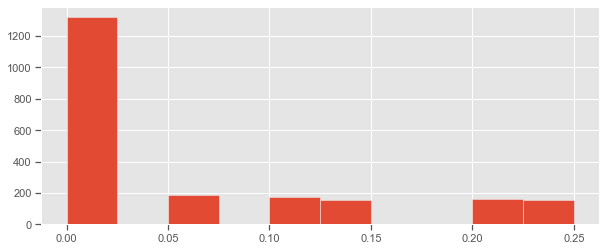

In [6]:
print("Number of unique discount values:", df.Discount.nunique())
print(df.Discount.value_counts())
df.Discount.hist(figsize=(10,4));

I can see from the above cell that the discounts are given as percentages. They are mostly in increments of 5 from 0 to 25, but there are a few oddball values. It may be useful to create categorical bins later.

In [7]:
# Create a dataframe of all orders, with purchase totals and useful columns
cur.execute('''SELECT o.OrderID,
                      o.OrderDate,
                      SUM(od.Quantity) as ItemCount,
                      SUM(od.Quantity * od.UnitPrice * (1 - od.Discount)) as OrderTotal,
                      o.CustomerID,
                      c.CompanyName as CustomerCompany,
                      c.City as CustomerCity,
                      c.Region as CustomerRegion,
                      c.Country as CustomerCountry,
                      cd.CustomerDesc,
                      o.ShipCity,
                      o.ShipRegion,
                      o.ShipCountry,
                      o.EmployeeID,
                      e.HireDate as EmployeeHireDate,
                      e.City as EmployeeCity,
                      e.Region as EmployeeRegion,
                      e.Country as EmployeeCountry,
                      e.ReportsTo as EmployeeSuper
                      FROM Order o
                      JOIN OrderDetail od USING(OrderID)
                      JOIN Employee e USING(EmployeeID) 
                      JOIN Customer c USING(CustomerID)
                      JOIN CustomerCustomerDemo ccd USING(CustomerID)
                      JOIN CustomerDemographic cd USING(CustomerTypeID)
                      GROUP BY OrderID
                      ORDER BY OrderDate
                      ''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

OperationalError: near "Order": syntax error

In [8]:
# This has thrown an error over the name of the table, checking names:
tables = cur.execute('''SELECT name FROM sqlite_master WHERE type="table";''')
for name in tables:
    print(name[0])

Employee
Category
Customer
Shipper
Supplier
Order
Product
OrderDetail
CustomerCustomerDemo
CustomerDemographic
Region
Territory
EmployeeTerritory


In [9]:
# I have figured out that the word Order must be in quotes with SQL queries, adjustment made.
# Taking a look at the Order table, we see that the ID column is not labeled OrderID as the
# chart would indicate, but rather labeled 'Id'
cur.execute('''SELECT * FROM "Order"''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(1)

Id CustomerId  EmployeeId   OrderDate RequiredDate ShippedDate  ShipVia  \
0  10248      VINET           5  2012-07-04   2012-08-01  2012-07-16        3   

   Freight                   ShipName         ShipAddress ShipCity  \
0    32.38  Vins et alcools Chevalier  59 rue de l'Abbaye    Reims   

       ShipRegion ShipPostalCode ShipCountry  
0  Western Europe          51100      France

In [10]:
# In the OrderDetail Table the Id and OrderId are different
cur.execute('''SELECT * FROM "OrderDetail"''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(1)

Id  OrderId  ProductId  UnitPrice  Quantity  Discount
0  10248/11    10248         11       14.0        12       0.0

In [11]:
# Need to check format for other tables now:
cur.execute('''SELECT * FROM Employee''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(1)

Id LastName FirstName                 Title TitleOfCourtesy   BirthDate  \
0   1  Davolio     Nancy  Sales Representative             Ms.  1980-12-08   

     HireDate                     Address     City         Region PostalCode  \
0  2024-05-01  507 - 20th Ave. E. Apt. 2A  Seattle  North America      98122   

  Country       HomePhone Extension Photo  \
0     USA  (206) 555-9857      5467  None   

                                               Notes  ReportsTo  \
0  Education includes a BA in psychology from Col...        2.0   

                              PhotoPath  
0  http://accweb/emmployees/davolio.bmp

In [12]:
# Each table seems to just call its own ID column 'Id'
# This will make the syntax for the JOIN statements more complicated, but not an issue
cur.execute('''SELECT * FROM Customer''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(1)

Id          CompanyName   ContactName          ContactTitle  \
0  ALFKI  Alfreds Futterkiste  Maria Anders  Sales Representative   

         Address    City          Region PostalCode  Country        Phone  \
0  Obere Str. 57  Berlin  Western Europe      12209  Germany  030-0074321   

           Fax  
0  030-0076545

In [13]:
# It also seems to appear that these two tables are empty:
cur.execute('''SELECT * FROM CustomerCustomerDemo''')
print(cur.fetchall())
cur.execute('''SELECT * FROM CustomerDemographic''')
print(cur.fetchall())

[]
[]


In [3]:
# Retrying to make DataFrame with new info:
# Note: I am using a weighted average of discount for each order
cur.execute('''SELECT o.Id AS OrderID,
                      o.OrderDate,
                      o.RequiredDate,
                      SUM(od.Quantity) as ItemCount,
                      SUM(od.Quantity * od.UnitPrice * (1 - od.Discount)) as OrderTotal,
                      SUM(od.Discount * od.Quantity) / SUM(od.Quantity) as WeightedDiscount,
                      o.CustomerID,
                      c.CompanyName AS CustomerCompany,
                      c.City AS CustomerCity,
                      c.Region AS CustomerRegion,
                      c.Country AS CustomerCountry,
                      o.ShipCity,
                      o.ShipRegion,
                      o.ShipCountry,
                      o.EmployeeID,
                      e.HireDate AS EmployeeHireDate,
                      e.City AS EmployeeCity,
                      e.Region AS EmployeeRegion,
                      e.Country AS EmployeeCountry,
                      e.ReportsTo AS EmployeeSuper
                      FROM "Order" o
                      JOIN OrderDetail od ON o.Id = od.OrderId
                      JOIN Employee e ON o.EmployeeID = e.Id
                      JOIN Customer c ON o.CustomerID = c.Id
                      GROUP BY 1
                      ORDER BY OrderDate
                      ''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

OrderID   OrderDate RequiredDate  ItemCount  OrderTotal  WeightedDiscount  \
0    10248  2012-07-04   2012-08-01         27      440.00          0.000000   
1    10249  2012-07-05   2012-08-16         49     1863.40          0.000000   
2    10250  2012-07-08   2012-08-05         60     1552.60          0.125000   
3    10251  2012-07-08   2012-08-05         41      654.06          0.025610   
4    10252  2012-07-09   2012-08-06        105     3597.90          0.030952   

  CustomerId            CustomerCompany    CustomerCity  CustomerRegion  \
0      VINET  Vins et alcools Chevalier           Reims  Western Europe   
1      TOMSP         Toms Spezialitäten         Münster  Western Europe   
2      HANAR              Hanari Carnes  Rio de Janeiro   South America   
3      VICTE       Victuailles en stock            Lyon  Western Europe   
4      SUPRD           Suprêmes délices       Charleroi  Western Europe   

  CustomerCountry        ShipCity      ShipRegion ShipCountry  EmployeeId  \
0          France           Reims  Western Europe      France           5   
1         Germany         Münster  Western Europe     Germany           6   
2          Brazil  Rio de Janeiro   South America      Brazil           4   
3          France            Lyon  Western Europe      France           3   
4         Belgium       Charleroi  Western Europe     Belgium           4   

  EmployeeHireDate EmployeeCity EmployeeRegion EmployeeCountry  EmployeeSuper  
0       2025-10-17       London  British Isles              UK            2.0  
1       2025-10-17       London  British Isles              UK            5.0  
2       2025-05-03      Redmond  North America             USA            2.0  
3       2024-04-01     Kirkland  North America             USA            2.0  
4       2025-05-03      Redmond  North America             USA            2.0

In [6]:
# Checking dataframe for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 20 columns):
OrderID             801 non-null int64
OrderDate           801 non-null object
RequiredDate        801 non-null object
ItemCount           801 non-null int64
OrderTotal          801 non-null float64
WeightedDiscount    801 non-null float64
CustomerId          801 non-null object
CustomerCompany     801 non-null object
CustomerCity        801 non-null object
CustomerRegion      801 non-null object
CustomerCountry     801 non-null object
ShipCity            801 non-null object
ShipRegion          801 non-null object
ShipCountry         801 non-null object
EmployeeId          801 non-null int64
EmployeeHireDate    801 non-null object
EmployeeCity        801 non-null object
EmployeeRegion      801 non-null object
EmployeeCountry     801 non-null object
EmployeeSuper       707 non-null float64
dtypes: float64(3), int64(3), object(14)
memory usage: 125.3+ KB


In [ ]:
# We can see that the only column that has missing values is EmployeeSuper

Stats for OrderTotal:


count      801.000000
mean      1533.053014
std       1851.077071
min         12.500000
25%        458.755000
50%        954.400000
75%       1885.000000
max      16387.500000
Name: OrderTotal, dtype: float64

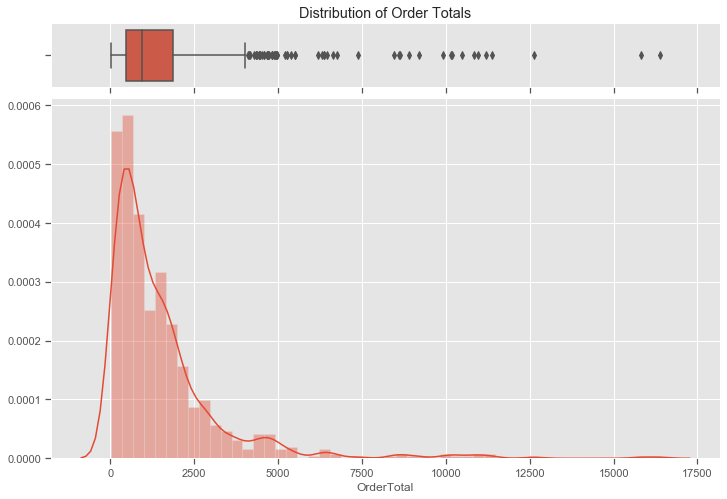

Skewness of OrderTotals: 3.448723144851842


In [4]:
# Now to take a look at the distribution of Order totals and some statistics
print("Stats for OrderTotal:")
display(df.OrderTotal.describe())
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8), 
                               gridspec_kw={"height_ratios": (.15, .85),
                                           "hspace": 0.05})
ax1.set_title('Distribution of Order Totals')
sns.boxplot(df.OrderTotal, ax=ax1)
ax1.set(xlabel='')
sns.distplot(df.OrderTotal, ax=ax2)
plt.show()

print("Skewness of OrderTotals:", skew(df.OrderTotal))

In [8]:
# I can see that the data is heavily positively skewed, with quite a few large outliers
# The mean is well above the median

In [9]:
# Another feature of interest is the number of items ordered, I will repeat this visualization
# process for this feature:
print("Stats for ItemCount:")
display(df.ItemCount.describe())
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8), 
                               gridspec_kw={"height_ratios": (.15, .85),
                                           "hspace": 0.05})
ax1.set_title('Distribution of Item Counts')
sns.boxplot(df.ItemCount, ax=ax1)
ax1.set(xlabel='')
sns.distplot(df.ItemCount, ax=ax2)
plt.show()

print("Skewness of Item Counts:", skew(df.ItemCount))

Stats for ItemCount:


count    801.000000
mean      62.066167
std       51.202362
min        1.000000
25%       26.000000
50%       50.000000
75%       81.000000
max      346.000000
Name: ItemCount, dtype: float64

Skewness of Item Counts: 1.7325244314590724


In [10]:
# I can see that the item counts follow a similar curve, with positive skew.
# I believe that both of these features, with logarithmic or square root transformation, can
# be used as target variables for predictive models.

In [11]:
# We can see here that the GROUP BY has produced a continous variable WeightedDisount
df.WeightedDiscount.value_counts()

0.000000    434
0.050000     49
0.100000     36
0.200000     36
0.250000     35
           ... 
0.061272      1
0.141892      1
0.038235      1
0.039583      1
0.140741      1
Name: WeightedDiscount, Length: 152, dtype: int64

In [12]:
# Checking to stats and making sure the math in SQL query has produced proper min and max
df.WeightedDiscount.describe()

count    801.000000
mean       0.054130
std        0.075352
min        0.000000
25%        0.000000
50%        0.000000
75%        0.100000
max        0.250000
Name: WeightedDiscount, dtype: float64

In [13]:
# We can see that the averaging of discount amounts has produced a lot of discrete values,
# I will now bin them into increments of 5% for ease of comparison, with bin edges set to round
# data points to their nearest increment
df['Discount'] = pd.cut(x = df.WeightedDiscount, 
                              bins = [-1, 0, 0.075, 0.125, 0.175, 0.22, 0.25],
                              labels = [0, 0.05, 0.10, 0.15, 0.20, 0.25])

Showing stats for OrderTotal grouped by Discount


Mean      Median          Std  Size
0.00  1400.628525   834.70000  1816.561587   434
0.05  1847.204819  1339.95000  2071.651496   124
0.10  1643.264321  1185.75000  1788.996111    95
0.15  1494.366535  1170.37500  1228.500375    57
0.20  1812.667709  1332.00000  2355.640248    55
0.25  1390.654444   853.37625  1447.366594    36

Grouping DataFrame by Discount
Target Features: OrderTotal


Showing stats for ItemCount grouped by Discount


Mean  Median        Std  Size
0.00  53.080645    35.0  48.835307   434
0.05  70.387097    64.5  48.405084   124
0.10  71.768421    60.0  49.315410    95
0.15  74.333333    67.0  50.132444    57
0.20  81.690909    59.0  67.381136    55
0.25  66.722222    55.0  47.467650    36

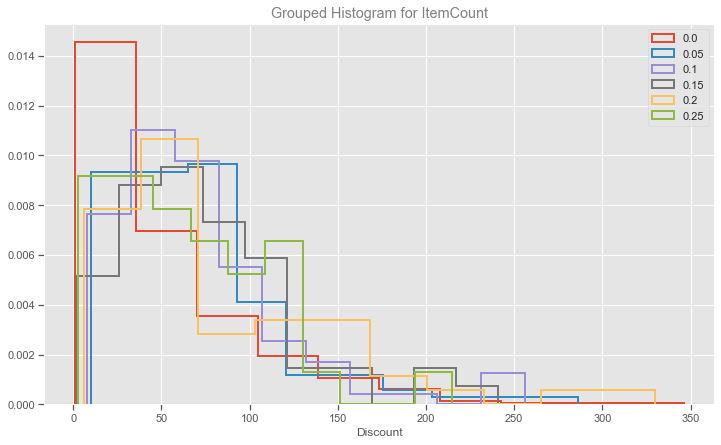

Grouping DataFrame by Discount
Target Features: ItemCount


In [19]:
def group_hist(data, feature, target, show_hist=True, return_groups=False):
    print('Showing stats for {} grouped by {}'.format(target, feature))
    grouped = data.groupby([feature])[target]
    stats = {}
    for group in grouped:
        temp = pd.Series(group[1])
        stats[group[0]] = {}
        stats[group[0]]['Mean'] = temp.mean()
        stats[group[0]]['Median'] = temp.median()
        stats[group[0]]['Std'] = temp.std(ddof=1)
        stats[group[0]]['Size'] = len(temp)
    
    stats = pd.DataFrame.from_dict(stats, orient='index')
    display(stats)
    
    if show_hist:
        plt.figure(figsize=(12,7))
        grouped.hist(density=True, histtype='step', alpha=1, stacked=True, lw=2)
        plt.legend([x[0] for x in grouped])
        plt.title('Grouped Histogram for {}'.format(target), color='gray')
        plt.xlabel(feature)
        plt.show()
    
    if return_groups:
        return stats, grouped
    else:
        return stats

targets = ['OrderTotal','ItemCount']
for target in targets:
    group_hist(df, 'Discount', target);
    mf.ecdf(df, group_by='Discount', targets=target)

<a id='transform1'></a>
# Transforming Data and Removing Outliers 1

Since many frequentist statistical tests rely on a normality assumption, we will need to adjust our target variables become more normal. First, let's run a normality test on each of them to see what kind of results we get. I will build the function with 3 popular tests of normality to compare their differences, while only depending on one for analysis. The three tests are Kolmogorov-Smirnov (non-parametric comparison of ECDFs), Shapiro-Wilk, and Anderson-Darling (another comparison of ECDFs). According to wikipedia, in a study by [Razali and Wah (2011)](https://web.archive.org/web/20150630110326/http://instatmy.org.my/downloads/e-jurnal%202/3.pdf), "Monte Carlo simulation has found that Shapiro–Wilk has the best power for a given significance, followed closely by Anderson–Darling when comparing the Shapiro–Wilk, Kolmogorov–Smirnov, Lilliefors and Anderson–Darling tests." For this project, I will work with the conclusions of the Shapiro-Wilk test, while watching the others for comparison.

In [20]:
def check_normality(data, cols, display_results=True):
    info = {}
    ad_results = {}
    
    for col in cols:
        if type(data) == pd.core.frame.DataFrame:
            x = data[col]
        else:
            x = data
        
         # Perform Anderson-Darling test on data
        stat, crit, p = stats.anderson(x, 'norm')
        ad_results[col] = {}
        ad_results[col]['statistic'] = stat
        ad_results[col]['critical'] = crit[2]
        
        info[col] = {}
        info[col]['K-S'] = {}
        info[col]['Shapiro-Wilk'] = {}
        info[col]['K-S']['Statistic'], info[col]['K-S']['p-value'] = stats.kstest(x, 'norm')
        info[col]['Shapiro-Wilk']['Statistic'], info[col]['Shapiro-Wilk']['p-value'] = stats.shapiro(x)
        
    dict_of_df = {k: pd.DataFrame(v) for k,v in info.items()}
    test_results = pd.concat(dict_of_df, axis=0)
    #mux = pd.MultiIndex.from_tuples(ad_results.keys())
    ad_results = pd.DataFrame.from_dict(ad_results, orient='index')
    #ad_results = pd.DataFrame(ad_results, index=mux)
    if display_results == True:
        print("Normality Test Results for {}:".format(cols))
        print("-------------------------------------------------------------------------------------------")
        names = ["K-S and Shapiro-Wilk:", "Anderson-Darling:"]
        mf.display_side_by_side(test_results, ad_results, names=names)
        
    return test_results, ad_results

cols = ['OrderTotal', 'ItemCount']
check_normality(df, cols);

Normality Test Results for ['OrderTotal', 'ItemCount']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal 
 Statistic 
 1.000000 
 6.657786e-01 
 
 
 p-value 
 0.000000 
 6.845121e-37 
 
 
 ItemCount 
 Statistic 
 0.991159 
 8.531504e-01 
 
 
 p-value 
 0.000000 
 1.252841e-26 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal 
 64.046402 
 0.783 
 
 
 ItemCount 
 28.493404 
 0.783

In [21]:
# As we can see, the normality tests are rejecting the null hypothesis that these distributions
# are the same as a normal distribution. The p-values for the K-S and Shapiro-Wilk are near
# zero, and the Anderson-Darling statistic is above the critical value
# I will create new features in the dataframe which are transformed copies of the target features
# in an attempt to make them more normal
df['OrderTotalLog'] = np.log(df.OrderTotal)
df['ItemCountLog'] = np.log(df.ItemCount)
df.head()

OrderID   OrderDate RequiredDate  ItemCount  OrderTotal  WeightedDiscount  \
0    10248  2012-07-04   2012-08-01         27      440.00          0.000000   
1    10249  2012-07-05   2012-08-16         49     1863.40          0.000000   
2    10250  2012-07-08   2012-08-05         60     1552.60          0.125000   
3    10251  2012-07-08   2012-08-05         41      654.06          0.025610   
4    10252  2012-07-09   2012-08-06        105     3597.90          0.030952   

  CustomerId            CustomerCompany    CustomerCity  CustomerRegion  ...  \
0      VINET  Vins et alcools Chevalier           Reims  Western Europe  ...   
1      TOMSP         Toms Spezialitäten         Münster  Western Europe  ...   
2      HANAR              Hanari Carnes  Rio de Janeiro   South America  ...   
3      VICTE       Victuailles en stock            Lyon  Western Europe  ...   
4      SUPRD           Suprêmes délices       Charleroi  Western Europe  ...   

  ShipCountry EmployeeId EmployeeHireDate EmployeeCity  EmployeeRegion  \
0      France          5       2025-10-17       London   British Isles   
1     Germany          6       2025-10-17       London   British Isles   
2      Brazil          4       2025-05-03      Redmond   North America   
3      France          3       2024-04-01     Kirkland   North America   
4     Belgium          4       2025-05-03      Redmond   North America   

  EmployeeCountry EmployeeSuper Discount OrderTotalLog  ItemCountLog  
0              UK           2.0     0.00      6.086775      3.295837  
1              UK           5.0     0.00      7.530158      3.891820  
2             USA           2.0     0.10      7.347686      4.094345  
3             USA           2.0     0.05      6.483199      3.713572  
4             USA           2.0     0.05      8.188106      4.653960  

[5 rows x 23 columns]

Variable: OrderTotalLog
Normality Test Results for ['OrderTotalLog']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotalLog 
 Statistic 
 0.996958 
 9.848103e-01 
 
 
 p-value 
 0.000000 
 2.218259e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotalLog 
 3.472377 
 0.783

count    801.000000
mean       6.781252
std        1.134474
min        2.525729
25%        6.128516
50%        6.861083
75%        7.541683
max        9.704274
Name: OrderTotalLog, dtype: float64

Skew: -0.4836141611694507


Variable: ItemCountLog
Normality Test Results for ['ItemCountLog']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCountLog 
 Statistic 
 0.94251 
 9.705731e-01 
 
 
 p-value 
 0.00000 
 1.263156e-11 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCountLog 
 4.593804 
 0.783

count    801.000000
mean       3.775809
std        0.923551
min        0.000000
25%        3.258097
50%        3.912023
75%        4.394449
max        5.846439
Name: ItemCountLog, dtype: float64

Skew: -0.7320195471577295


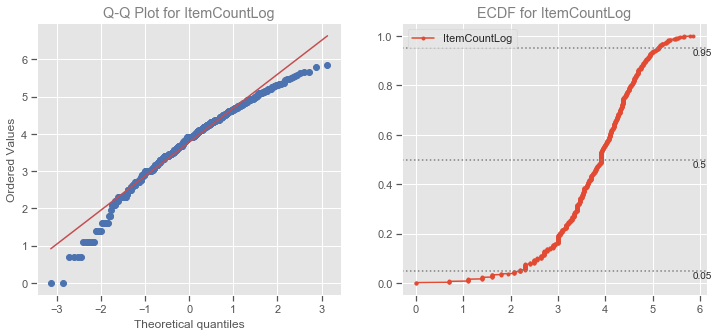

In [22]:
def visualize_distribution(data, targets=None):
    results = check_normality(data, targets, display_results=False)
    if type(data) != pd.core.frame.DataFrame:
        targets = ['Data']
        temp = pd.DataFrame()
        temp['Data'] = data
        data = temp
    
    for target in targets:
        
        mean = round(np.mean(data[target]), 5)
        median = round(np.median(data[target]), 5)
        print("Variable: {}".format(target))
        test_results = check_normality(data, [target])
        display(data[target].describe())
        print("Skew: {}".format(skew(data[target])))
        fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,6), 
                                   gridspec_kw={"height_ratios": (.15, .85),
                                               "hspace": 0.05})
        ax1.set_title('Distribution of {}'.format(target), color='gray')
        sns.boxplot(data[target], ax=ax1)
        ax1.set(xlabel='')
        ax1.annotate(s='Median: {}'.format(median), 
                    xy=(0.87, 0.1), xycoords="axes fraction")
        sns.distplot(data[target], ax=ax2)
        ax2.axvline(x=mean, ls=':', color='black', label='Mean: {}'.format(mean))
        ax2.legend()
        plt.show()
        
        fig2, (ax,ax2) = plt.subplots(ncols=2, figsize=(12,5))
        stats.probplot(data[target], dist='norm', plot=ax)
        ax.set_title('Q-Q Plot for {}'.format(target), color='gray')
        mf.ecdf(data[target], ax=ax2)
        
        plt.show()
        
    return results
        
targets = ['OrderTotalLog','ItemCountLog']
visualize_distribution(df, targets);

While these transformations have made the distributions visually much more normal, the normality tests still indicate they are non-normal, and the skew has been reversed, but not managed. I will now try square root transformations to see the difference.

In [23]:
df['OrderTotalSqrt'] = np.sqrt(df.OrderTotal)
df['ItemCountSqrt'] = np.sqrt(df.ItemCount)

Variable: OrderTotalSqrt
Normality Test Results for ['OrderTotalSqrt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotalSqrt 
 Statistic 
 0.999797 
 9.185522e-01 
 
 
 p-value 
 0.000000 
 2.368276e-20 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotalSqrt 
 11.815048 
 0.783

count    801.000000
mean      34.413993
std       18.685985
min        3.535534
25%       21.418567
50%       30.893365
75%       43.416587
max      128.013671
Name: OrderTotalSqrt, dtype: float64

Skew: 1.3152918062204297


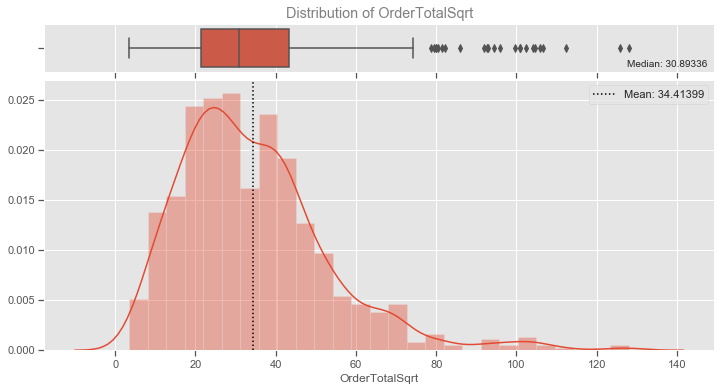

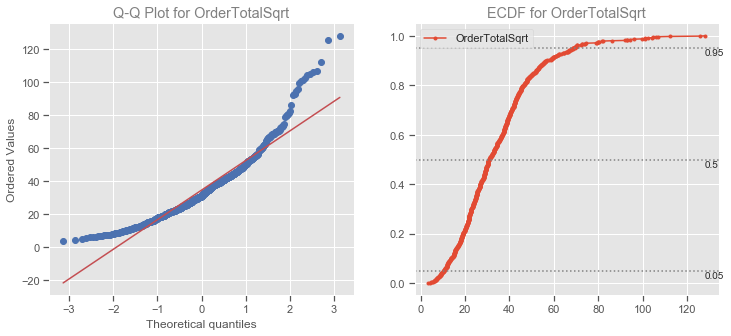

Variable: ItemCountSqrt
Normality Test Results for ['ItemCountSqrt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCountSqrt 
 Statistic 
 0.963606 
 9.776331e-01 
 
 
 p-value 
 0.000000 
 9.944316e-10 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCountSqrt 
 3.873497 
 0.783

count    801.000000
mean       7.271543
std        3.033533
min        1.000000
25%        5.099020
50%        7.071068
75%        9.000000
max       18.601075
Name: ItemCountSqrt, dtype: float64

Skew: 0.592567524776337


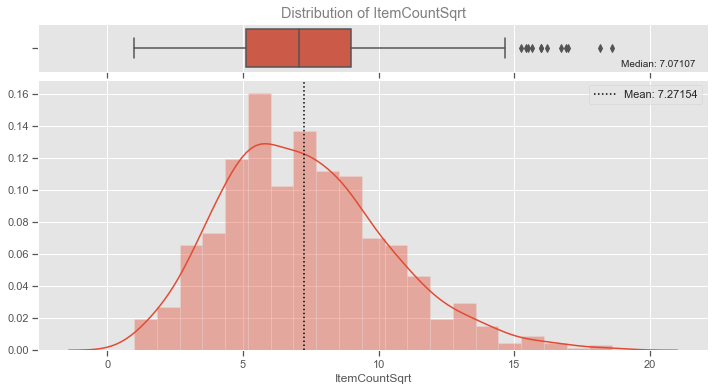

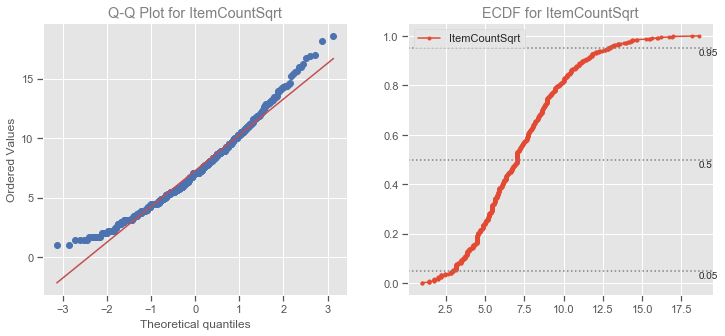

In [24]:
cols = ['OrderTotalSqrt','ItemCountSqrt']
visualize_distribution(df, cols);

As we can see, neither log transformation nor square root transformation has made our target variables get a result from the K-S or Shapiro Wilk tests indicating normality, but it can be visually observed that the transformations have made the distributions more normal. The log transformations seem to have reversed the skew, and added some outliers on the low side, whereas the square root transformations have maintained the positive skew, with outliers on the upper side. I will try using higher roots to see if that gets the right shape.

In [25]:
df['OrderTotalCbrt'] = df.OrderTotal**(1/3)
df['ItemCountCbrt'] = df.ItemCount**(1/3)

Variable: OrderTotalCbrt
Normality Test Results for ['OrderTotalCbrt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotalCbrt 
 Statistic 
 0.995492 
 9.723304e-01 
 
 
 p-value 
 0.000000 
 3.497968e-11 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotalCbrt 
 3.430533 
 0.783

count    801.000000
mean      10.255771
std        3.693402
min        2.320794
25%        7.712472
50%        9.845629
75%       12.352943
max       25.400225
Name: OrderTotalCbrt, dtype: float64

Skew: 0.6992257750652395


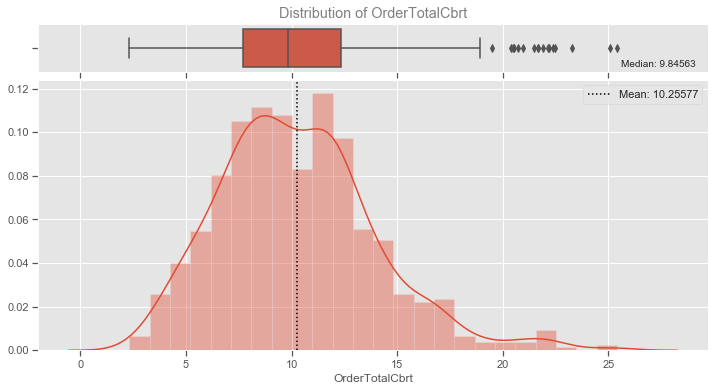

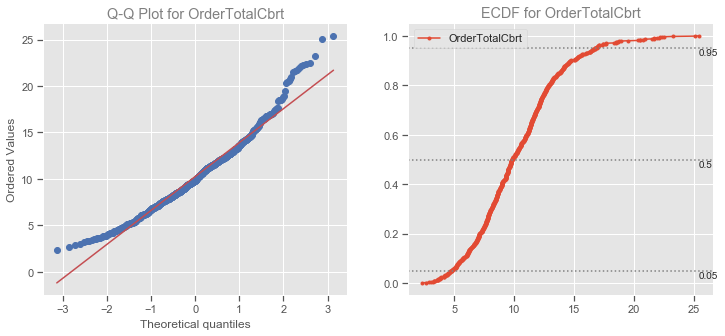

Variable: ItemCountCbrt
Normality Test Results for ['ItemCountCbrt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCountCbrt 
 Statistic 
 0.938548 
 0.995999 
 
 
 p-value 
 0.000000 
 0.037878 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCountCbrt 
 0.693509 
 0.783

count    801.000000
mean       3.679211
std        1.044858
min        1.000000
25%        2.962496
50%        3.684031
75%        4.326749
max        7.020349
Name: ItemCountCbrt, dtype: float64

Skew: 0.19947561322842527


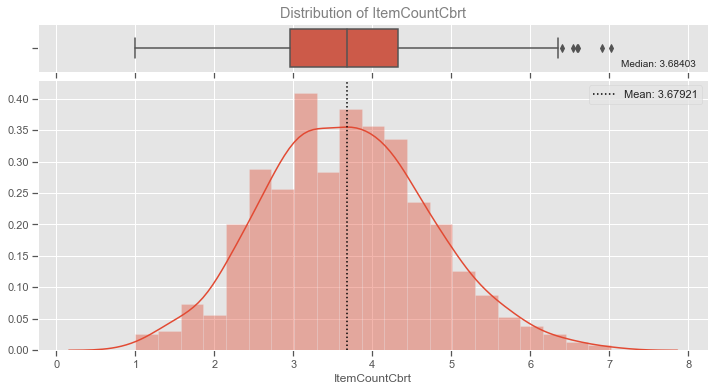

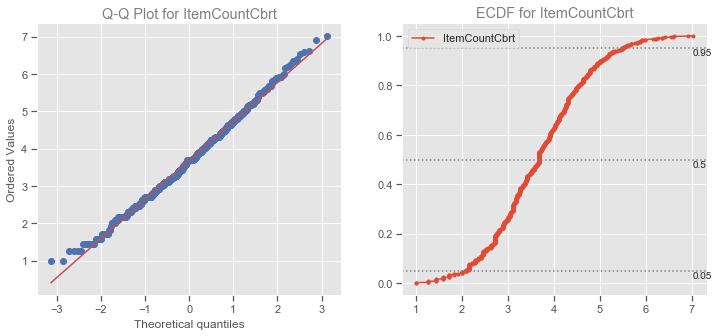

In [26]:
cols = ['OrderTotalCbrt','ItemCountCbrt']
visualize_distribution(df, cols);

In [27]:
# Using the Cube root has improved normality for the target features
# I am going to go a step further and see how the 4th root does
df['OrderTotal4rt'] = df.OrderTotal**(1/4)
df['ItemCount4rt'] = df.ItemCount**(1/4)

Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 0.987036 
 0.988551 
 
 
 p-value 
 0.000000 
 0.000007 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 1.291844 
 0.783

count    801.000000
mean       5.661906
std        1.536153
min        1.880302
25%        4.628020
50%        5.558180
75%        6.589126
max       11.314313
Name: OrderTotal4rt, dtype: float64

Skew: 0.40366192328569206


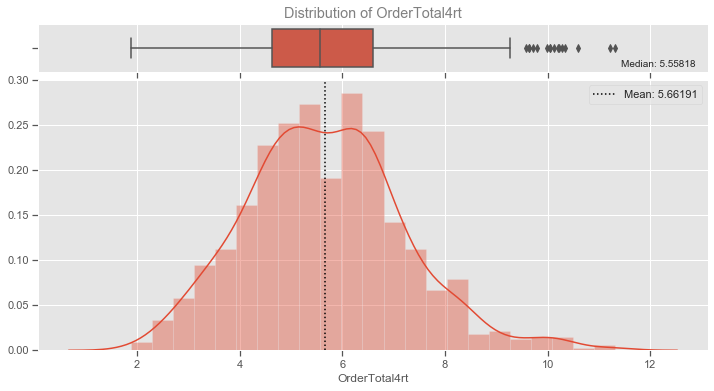

Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 0.914994 
 0.998372 
 
 
 p-value 
 0.000000 
 0.666446 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.288787 
 0.783

count    801.000000
mean       2.635777
std        0.569759
min        1.000000
25%        2.258101
50%        2.659148
75%        3.000000
max        4.312896
Name: ItemCount4rt, dtype: float64

Skew: -0.009408624536717971


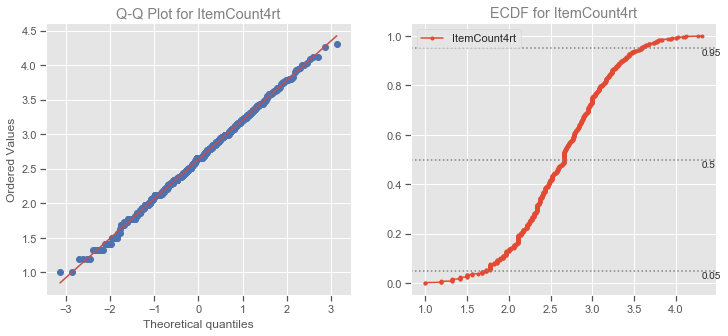

In [28]:
cols = ['OrderTotal4rt','ItemCount4rt']
visualize_distribution(df, cols);

These are the best transformation results so far. We can see that for OrderTotal4rt all of the normality tests have rejected the null hypothesis of normality. The Shapiro-Wilk and Anderson-Darling tests have failed to reject the null hypothesis of normality for ItemCount4rt, though the K-S did. From the results I've seen so far, it seems the K-S test is very liberal in rejecting the null hypothesis, at least for this data. In any case, the Q-Q plots, histograms, and ECDFs look sufficiently normal to test on. I will proceed in further tests using these 4th root transformations.

I would like to see the effect that removing outliers will have on this lack of normality. I will start by trimming the DataFrame based on a percentage of the target data.

In [29]:
# Some helper functions to do this
def trim(data, percent, side='both'):
    data = np.array(sorted(data))
    trim = int(percent*data.size/100.0)
    if side == 'both':
        return data[trim:-trim]
    elif side == 'low':
        return data[trim:]
    elif side == 'high':
        return data[:-trim]
    else:
        print("Error: improper value for side. Options are 'both', 'high', 'low'.")

def trim_df_by_col(df, col, percent, side='both'):
    trimmed_data = trim(df[col], percent, side)
    trimmed_df = df[df[col].isin(trimmed_data)]
    print("Length of old DataFrame:", len(df))
    print("Length of trimmed DataFrame:", len(trimmed_df))
    print(" ")
    return trimmed_df

def winsorize_df(df, col, percent):
    percent *= .01
    print("Length of old DataFrame:", len(df))
    dataframe = df.copy()
    dataframe[col] = stats.mstats.winsorize(df[col], limits=(percent,percent), inplace=False)
    print("Length of Winsorized DataFrame:", len(dataframe))
    print(" ")
    return dataframe

def sigma_trim(df, col, num_sigmas=3):
    range_ = num_sigmas * df[col].std(ddof=1)
    mean = df[col].mean()
    upper_boundary = mean + range_
    lower_boundary = mean - range_
    trimmed_df = df[(df[col] <= upper_boundary) & (df[col] >= lower_boundary)]
    print("Length of old DataFrame:", len(df))
    print("Length of Trimmed DataFrame:", len(trimmed_df))
    print(" ")
    return trimmed_df

def tukey_trim(data, col, coef=3):
    # Found a useful function in the scikit_posthoc that uses the Tukey fence method
    trimmed = sp.outliers_iqr(data[col], coef=coef)
    print("Length of old DataFrame:", len(data))
    data = data[data[col].isin(trimmed)]
    print("Length of Tukey trimmed DataFrame", len(data))
    return(data)

In [30]:
test = trim(df['OrderTotal4rt'], 5, 'high')
print(len(df['OrderTotal4rt']))
print(len(test))

801
761


In [31]:
# Testing the functions:
test = trim_df_by_col(df, 'OrderTotal4rt', 6, 'low')

Length of old DataFrame: 801
Length of trimmed DataFrame: 753
 


Length of old DataFrame: 801
Length of trimmed DataFrame: 721
 
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 0.999399 
 0.985901 
 
 
 p-value 
 0.000000 
 0.000002 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 1.946379 
 0.783

count    721.000000
mean       5.622064
std        1.186705
min        3.238532
25%        4.701761
50%        5.558180
75%        6.501654
max        8.283207
Name: OrderTotal4rt, dtype: float64

Skew: 0.08641401910665716


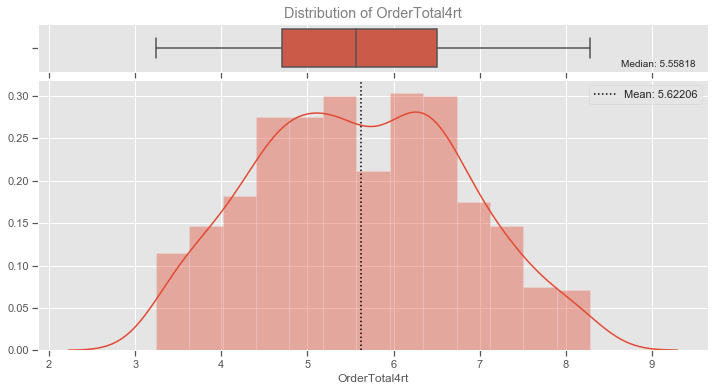

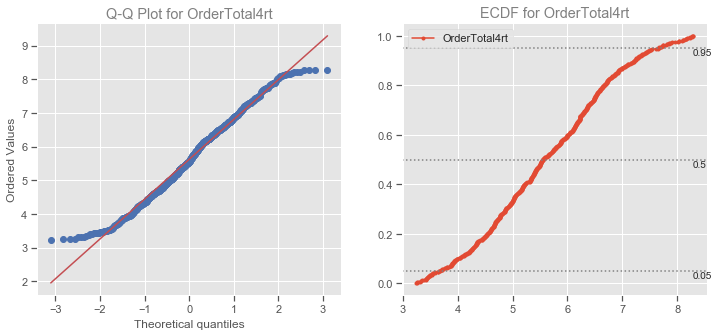

Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 0.939826 
 0.996585 
 
 
 p-value 
 0.000000 
 0.125615 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.670779 
 0.783

count    721.000000
mean       2.644903
std        0.491789
min        1.316074
25%        2.300327
50%        2.659148
75%        2.990698
max        4.000000
Name: ItemCount4rt, dtype: float64

Skew: 0.06055365927413514


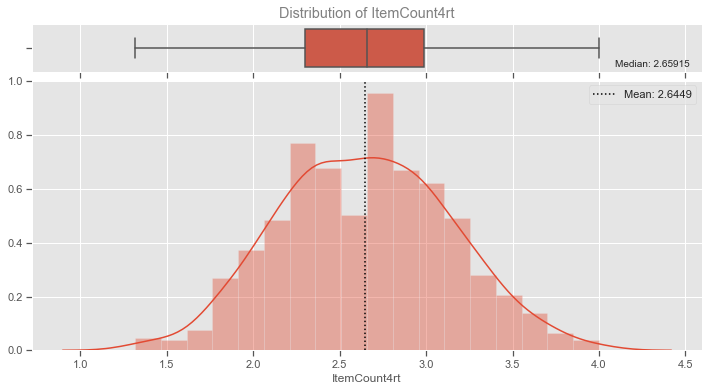

In [32]:
trimmed_df = trim_df_by_col(df, 'OrderTotal4rt', 5)

cols = ['OrderTotal4rt','ItemCount4rt']
visualize_distribution(trimmed_df, cols);

Length of old DataFrame: 801
Length of Winsorized DataFrame: 801
 
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 0.999399 
 9.739447e-01 
 
 
 p-value 
 0.000000 
 9.253854e-11 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 2.858133 
 0.783

count    801.000000
mean       5.635927
std        1.380360
min        3.238532
25%        4.628020
50%        5.558180
75%        6.589126
max        8.283207
Name: OrderTotal4rt, dtype: float64

Skew: 0.12015861252077017


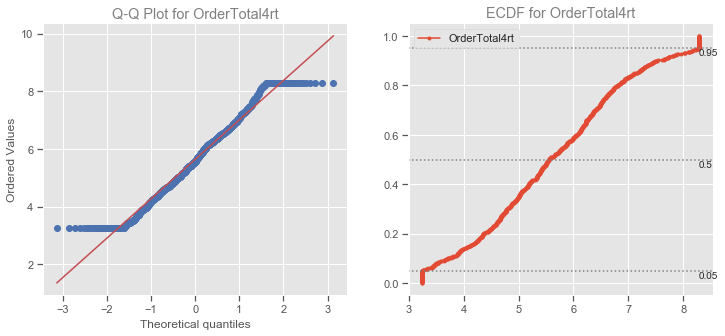

Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 0.914994 
 0.998372 
 
 
 p-value 
 0.000000 
 0.666446 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.288787 
 0.783

count    801.000000
mean       2.635777
std        0.569759
min        1.000000
25%        2.258101
50%        2.659148
75%        3.000000
max        4.312896
Name: ItemCount4rt, dtype: float64

Skew: -0.009408624536717971


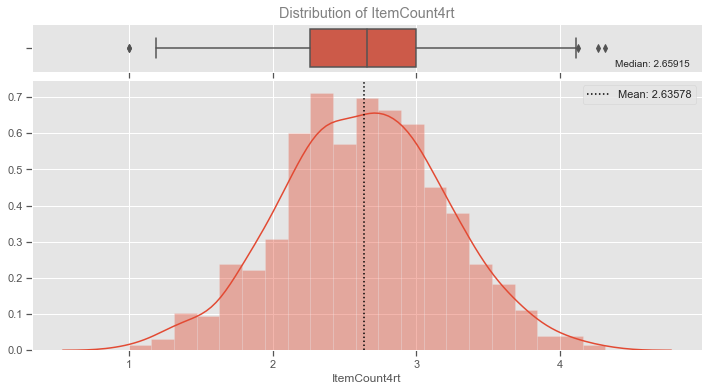

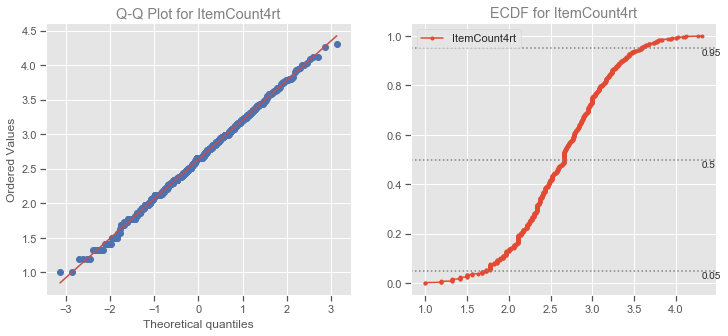

In [33]:
# The above trim did not improve normality test results
# Seeing the effects of a 5% winsorization
winsorized_df = winsorize_df(df, 'OrderTotal4rt', 5)
cols = ['OrderTotal4rt','ItemCount4rt']
visualize_distribution(winsorized_df, cols);

Length of old DataFrame: 801
Length of Trimmed DataFrame: 796
 
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 0.987005 
 0.993621 
 
 
 p-value 
 0.000000 
 0.001834 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 0.725398 
 0.783

count    796.000000
mean       5.629959
std        1.486510
min        1.880302
25%        4.619787
50%        5.541870
75%        6.552092
max       10.230144
Name: OrderTotal4rt, dtype: float64

Skew: 0.2551634476686304


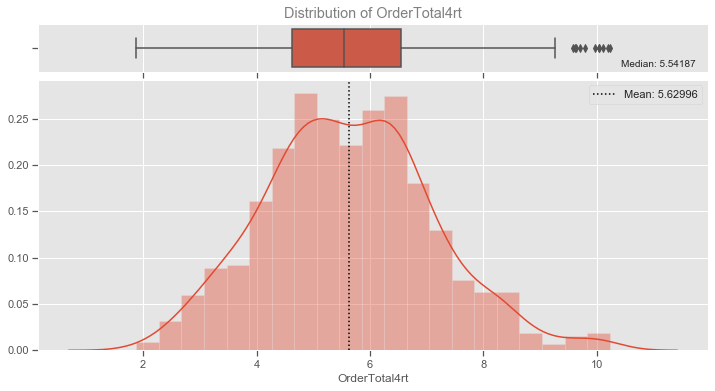

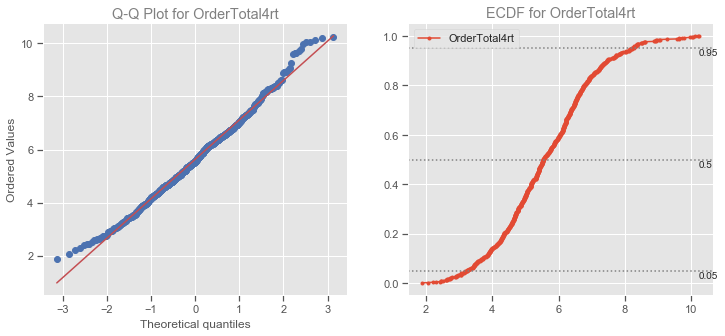

Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 0.914751 
 0.998275 
 
 
 p-value 
 0.000000 
 0.618700 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.294726 
 0.783

count    796.000000
mean       2.631221
std        0.567198
min        1.000000
25%        2.258101
50%        2.659148
75%        2.993023
max        4.312896
Name: ItemCount4rt, dtype: float64

Skew: -0.0213784167626664


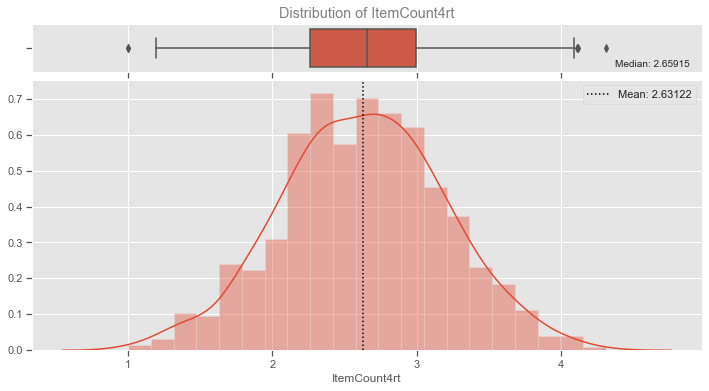

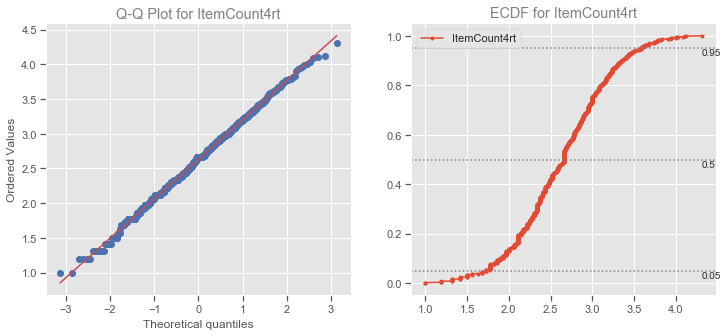

In [34]:
# The above winsorization reduced the normality of the variable it was done on. Moving on
# Testing the sigma trim, going out to 3 standard deviations:
sigma_df = sigma_trim(df, 'OrderTotal4rt')
cols = ['OrderTotal4rt','ItemCount4rt']
visualize_distribution(sigma_df, cols);

Length of old DataFrame: 801
Length of Tukey trimmed DataFrame 785
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 0.986934 
 0.995940 
 
 
 p-value 
 0.000000 
 0.038774 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 0.532609 
 0.783

count    785.000000
mean       5.570022
std        1.407008
min        1.880302
25%        4.605779
50%        5.525276
75%        6.526904
max        9.271800
Name: OrderTotal4rt, dtype: float64

Skew: 0.03520806355793502


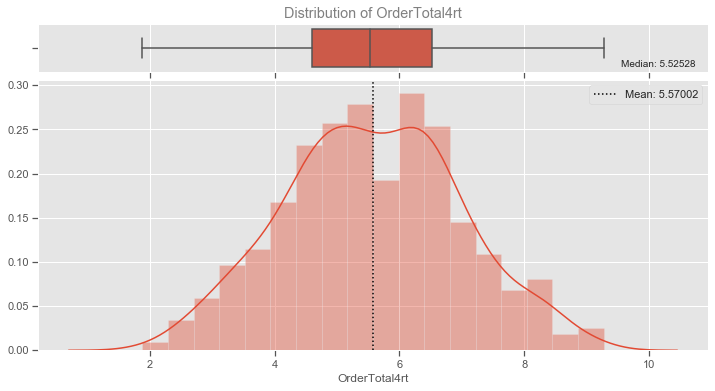

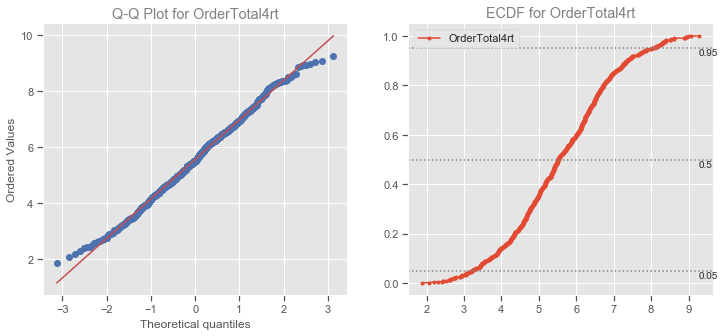

Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 0.914205 
 0.998270 
 
 
 p-value 
 0.000000 
 0.627946 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.311849 
 0.783

count    785.000000
mean       2.620253
std        0.561310
min        1.000000
25%        2.236068
50%        2.659148
75%        2.990698
max        4.312896
Name: ItemCount4rt, dtype: float64

Skew: -0.03269580788063369


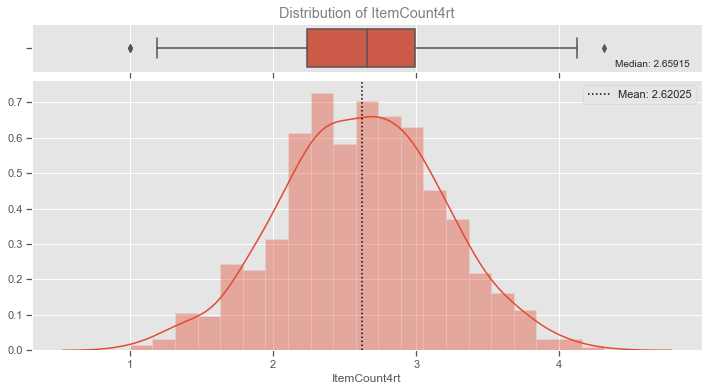

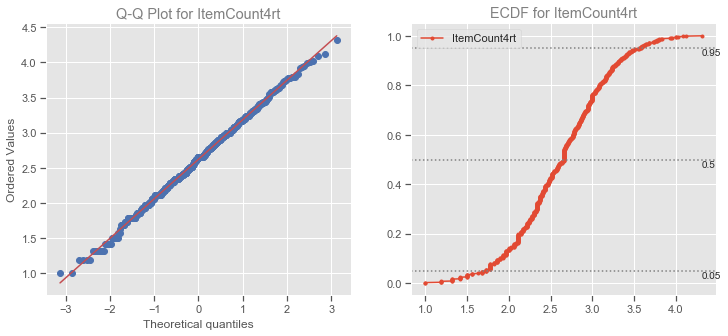

In [35]:
# The above trim to everything within 3 standard devs improved the normality of OrderTotal4rt
# compared to the untrimmed dataframe. One more method to try
# Testing the Tukey trim:
tukey_df = tukey_trim(df, 'OrderTotal4rt', coef=1.5)
visualize_distribution(tukey_df, cols);

The results from the Tukey method are quite favorable. Though the K-S tests still are showing p-values of zero, the Shapiro-Wilk tests have improved drastically, and in the case of ItemCount4rt, it is failing to reject the null hypothesis, indicating the distribution is not statistically different than a normal distribution. The Anderson-Darling test has failed to reject the null hypothesis of normality for both variables after this outlier removal. According to Matthew E. Clapham in his YouTube Video "9: Shapiro-Wilk test", the Shapiro-Wilk test is overly sensitive for satisfying normality assumptions of t-tests, and that histograms and Q-Q plots are enough. In this case, we are just on the edge of satisfying the Shapiro-Wilk tests, so we can assume the data is normal enough to move forward. From the histogram and Q-Q plot, it looks as though the distributions are normal enough to work with. Taking in this new insight, I can see why the Anderson-Darling test is usually the one I hear recommended for normality assumption checking, since it has a bit less power than the Shapiro-Wilk test and therefore less liberal with rejecting the null hypothesis. I will side with using the Anderson-Darling test when it comes to normality assumptions, though I will still compare it to the others. The K-S test has had extremely low p-values thus far, it likely has something to do with the fact that it only pays attention to the largest gap between two ECDFs, and with this many data points, there are likely to be some big ones when compared to a smooth normal distribution.

From here onward, I will be doing hypothesis tests with the tukey_df. Normality assumptions will be done visually and with support from the Anderson-Darling test.

In [36]:
# releasing test dataframes from memory:
delete = [test, trimmed_df, winsorized_df, sigma_df]
del delete

<a id='hypothesis_testing'> </a>
# Hypothesis Testing: DataFrame 1

In [37]:
def explore_groups(dataframe, feature, target):
    percentages = {}
    group_stats, groups = group_hist(dataframe, feature, target, show_hist=False, return_groups=True)
    for name, group in groups:
        percentages[name] = group.sum() / dataframe[target].sum()
    percent_df = pd.DataFrame.from_dict(percentages, orient='index')
    column_name = 'Percent of Total {}'.format(target)
    percent_df.columns = [column_name]

    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), 
                                       gridspec_kw={"height_ratios": (.40, .20, .40),
                                                   "hspace": 0.05})
    percent_df[column_name].plot(kind='bar', ax=ax1, alpha=0.7)
    ax1.legend()
    ax1.set_title('Percent of Total {}, Order Frequency, and Avg {} per {}'.format(target,
                                                                                   target,
                                                                                   feature),
                 c='gray', size=16)
    ax2.plot(list(range(len(group_stats))), group_stats.Size, label='Order Frequency', 
             c='green', alpha=0.7)
    ax2.legend()
    ax3 = group_stats.Mean.plot(kind='bar', label='Avg {}'.format(target), alpha=0.6, color='blue')
    ax3.legend()
    plt.show()
    
    return pd.concat([group_stats, percent_df], axis=1)

<a id='discount_ordertotal'></a>
## Effects of Discount on Order Total

Showing stats for OrderTotal4rt grouped by Discount


Mean    Median       Std  Size
0.00  5.373950  5.335246  1.458158   426
0.05  5.971670  6.034681  1.225582   121
0.10  5.808528  5.825143  1.220224    93
0.15  5.823139  5.848995  1.321069    57
0.20  5.557790  5.830237  1.439444    52
0.25  5.540986  5.404811  1.539076    36

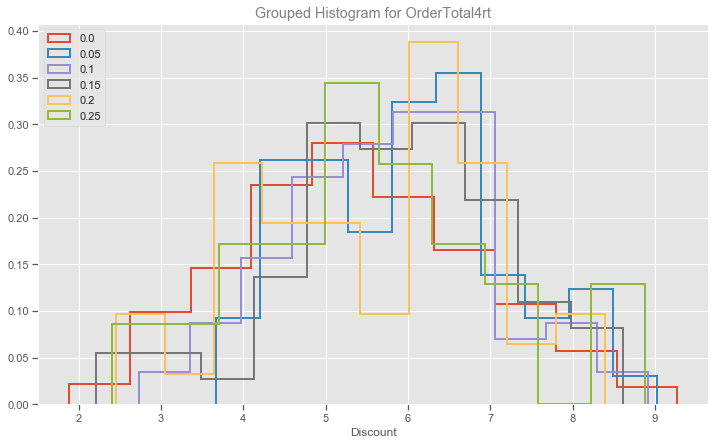

Grouping DataFrame by Discount
Target Features: OrderTotal4rt


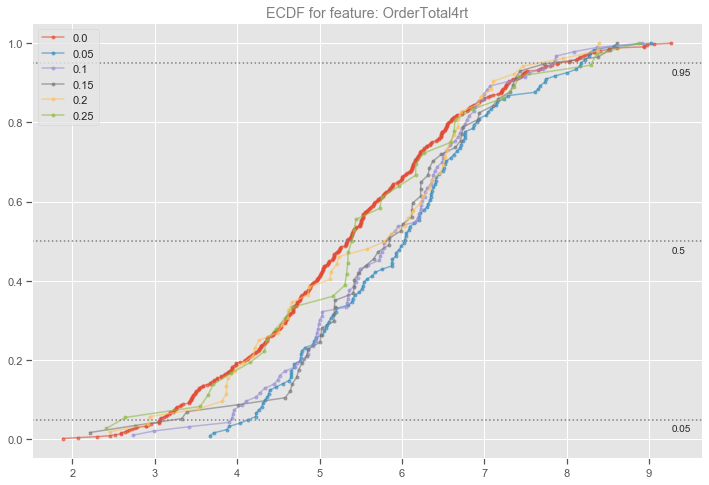

Showing stats for OrderTotal4rt grouped by Discount


Mean    Median       Std  Size
0.00  5.373950  5.335246  1.458158   426
0.05  5.971670  6.034681  1.225582   121
0.10  5.808528  5.825143  1.220224    93
0.15  5.823139  5.848995  1.321069    57
0.20  5.557790  5.830237  1.439444    52
0.25  5.540986  5.404811  1.539076    36

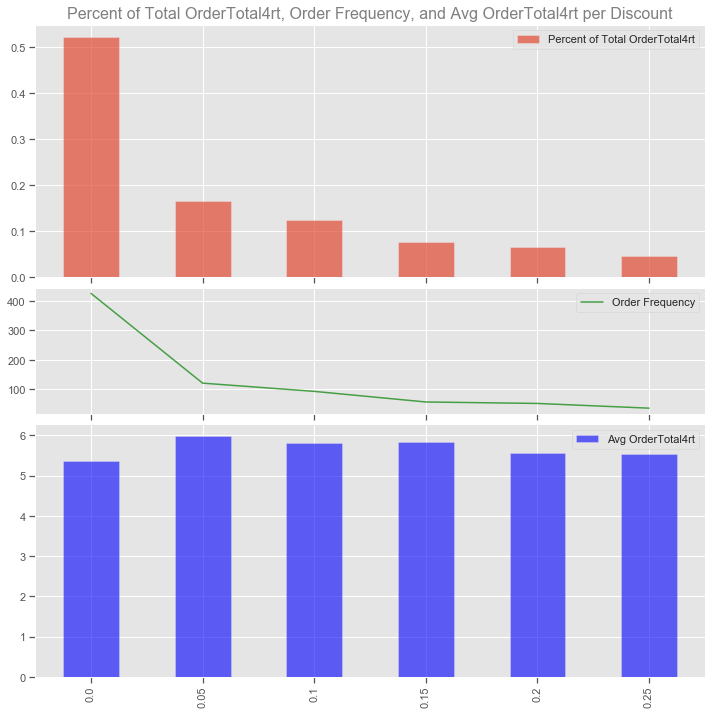

In [38]:
# First, a look at the layered histogram for transformed variable OrderTotal4rt
group_hist(tukey_df, 'Discount', 'OrderTotal4rt');
mf.ecdf(tukey_df, 'Discount', 'OrderTotal4rt')
explore_groups(tukey_df, 'Discount', 'OrderTotal4rt');

Looking at OrderTotal4rt, it seems there is a jump upward in means from the 0.0 discount group to the 0.05 discount group, but the means seem to decline from there. This makes sense intuitively, since a larger weighted discount on an order would mean a lower overall total. However,
the means for all of the treatment groups are larger than the control mean, indicating that 
any offered discount leads to a larger OrderTotal. The peak at 0.05 may indicate a sweet spot between offered discount and buying incentive.

<a id='frequentist1'></a>
### Frequentist Approaches

<a id='assumptions1'></a>
#### Testing for Assumptions

Normality Assumptions

Side by side comparison of all group distributions:


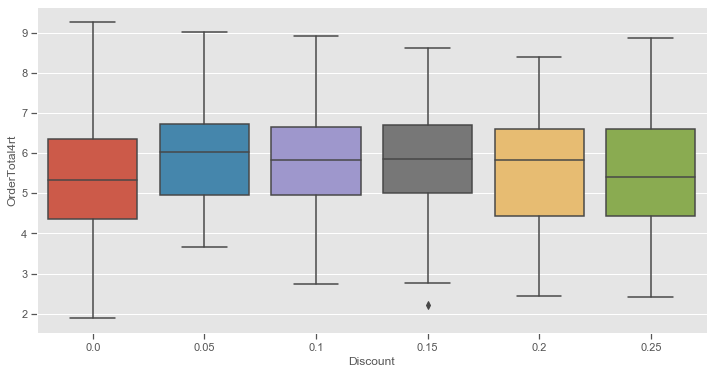

Checking normality and visualizing distributions for 0.0 group
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 0.985805 
 0.993112 
 
 
 p-value 
 0.000000 
 0.048294 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 0.485394 
 0.78

count    426.000000
mean       5.373950
std        1.458158
min        1.880302
25%        4.355877
50%        5.335246
75%        6.364631
max        9.271800
Name: OrderTotal4rt, dtype: float64

Skew: 0.16454762657772642


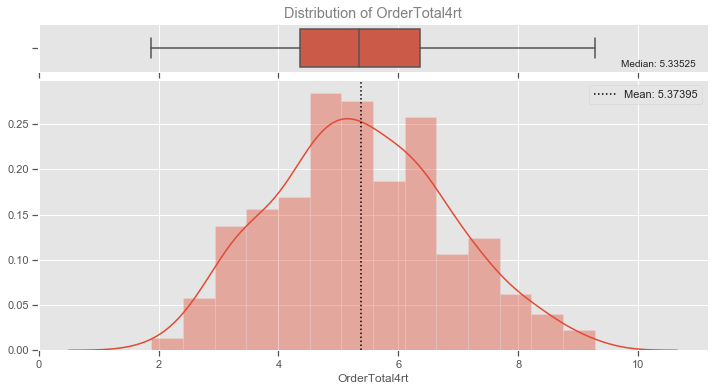

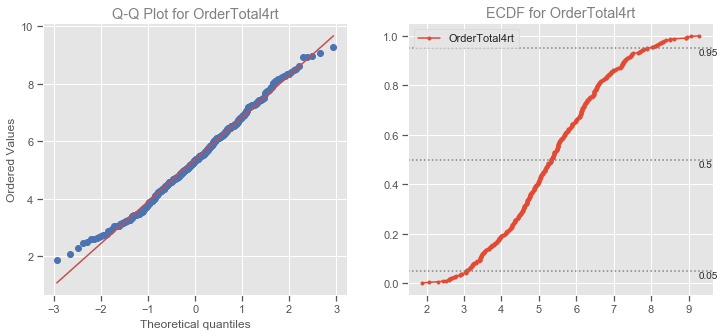

Checking normality and visualizing distributions for 0.05 group
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 0.999876 
 0.979075 
 
 
 p-value 
 0.000000 
 0.056545 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 0.617718 
 0.763

count    121.000000
mean       5.971670
std        1.225582
min        3.665281
25%        4.954174
50%        6.034681
75%        6.735745
max        9.025364
Name: OrderTotal4rt, dtype: float64

Skew: 0.23183204175253858


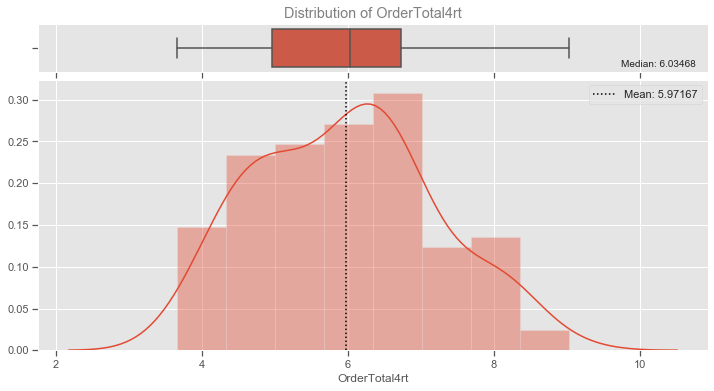

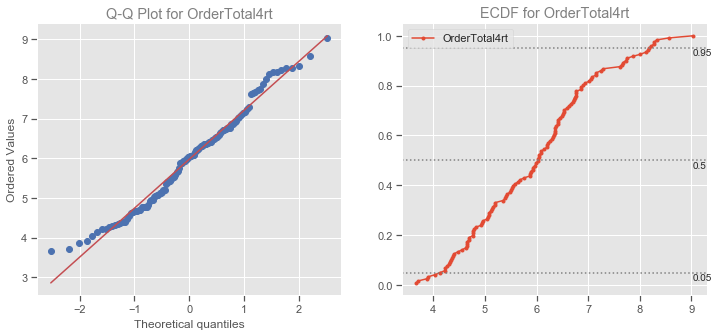

Checking normality and visualizing distributions for 0.1 group
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 9.968631e-01 
 0.993506 
 
 
 p-value 
 2.987912e-233 
 0.934550 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 0.271231 
 0.757

count    93.000000
mean      5.808528
std       1.220224
min       2.733119
25%       4.957901
50%       5.825143
75%       6.642242
max       8.911332
Name: OrderTotal4rt, dtype: float64

Skew: -0.04801213347744495


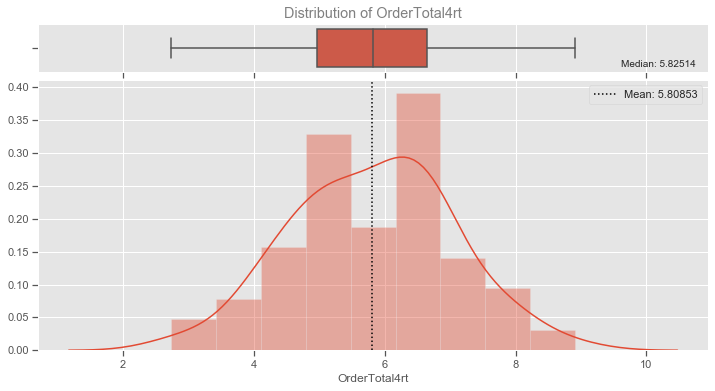

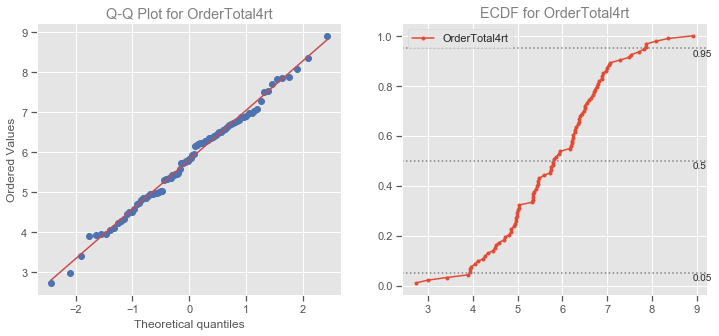

Checking normality and visualizing distributions for 0.15 group
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 9.864036e-01 
 0.981034 
 
 
 p-value 
 8.058346e-107 
 0.509034 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 0.312521 
 0.741

count    57.000000
mean      5.823139
std       1.321069
min       2.208738
25%       5.014735
50%       5.848995
75%       6.712672
max       8.615879
Name: OrderTotal4rt, dtype: float64

Skew: -0.2706668485907476


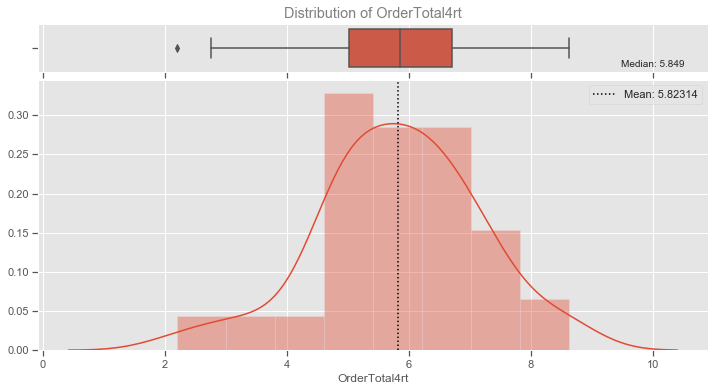

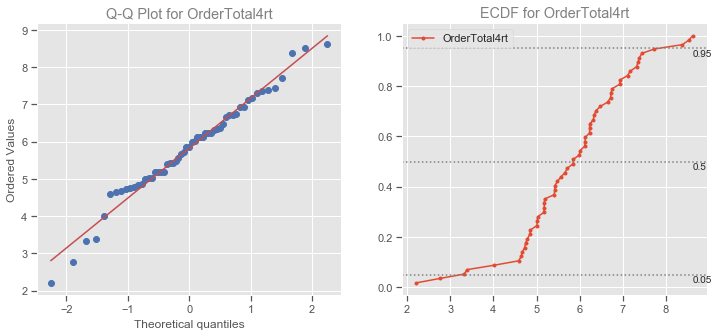

Checking normality and visualizing distributions for 0.2 group
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 9.928471e-01 
 0.972987 
 
 
 p-value 
 5.422828e-112 
 0.281718 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 0.592778 
 0.737

count    52.000000
mean      5.557790
std       1.439444
min       2.449490
25%       4.433943
50%       5.830237
75%       6.594083
max       8.392476
Name: OrderTotal4rt, dtype: float64

Skew: -0.11554650470960377


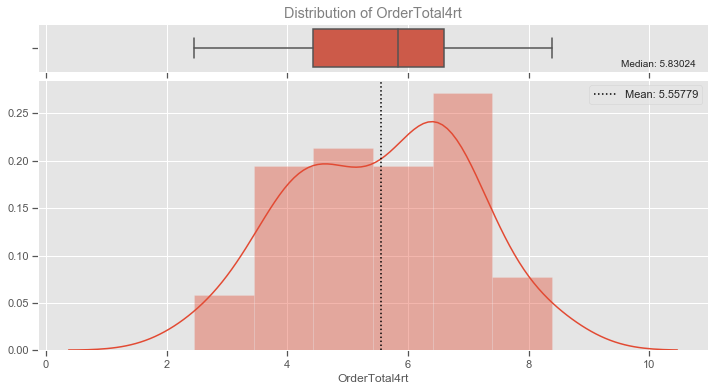

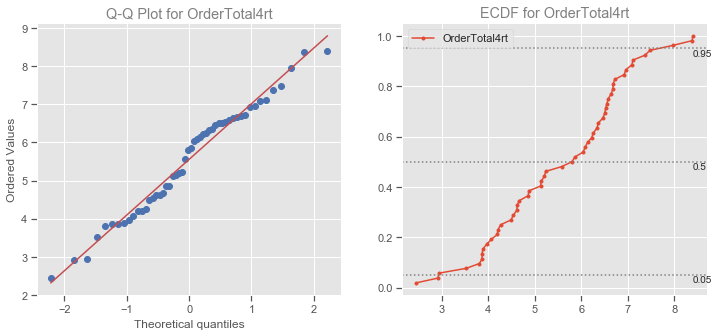

Checking normality and visualizing distributions for 0.25 group
Variable: OrderTotal4rt
Normality Test Results for ['OrderTotal4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 OrderTotal4rt 
 Statistic 
 9.920300e-01 
 0.986271 
 
 
 p-value 
 5.669968e-76 
 0.926025 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 OrderTotal4rt 
 0.182645 
 0.721

count    36.000000
mean      5.540986
std       1.539076
min       2.410285
25%       4.438450
50%       5.404811
75%       6.605410
max       8.873757
Name: OrderTotal4rt, dtype: float64

Skew: 0.12487099304741266


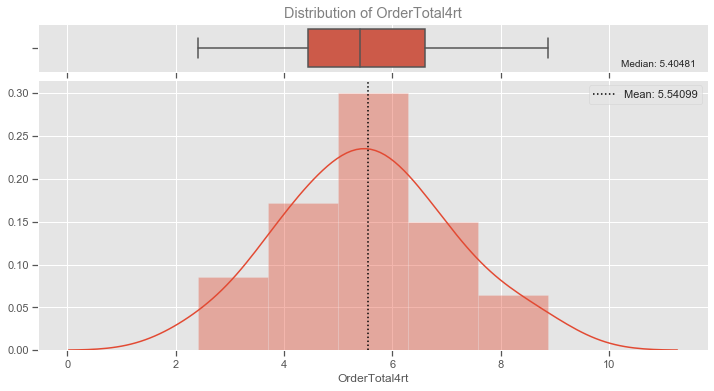

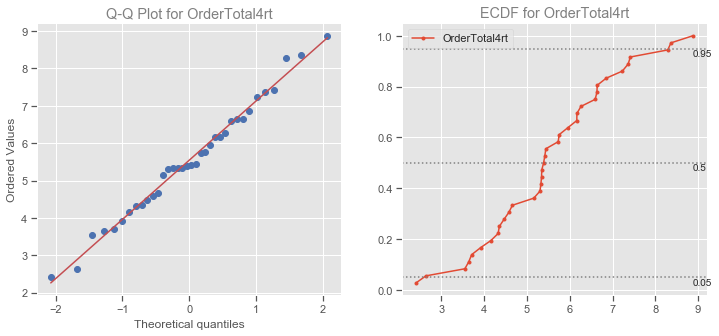

In [41]:
# Before testing, I am going to check for normality of each group:
# Side-by-side boxplot of groups:
fig, ax = plt.subplots(figsize=(12,6))
print("Side by side comparison of all group distributions:")
sns.boxplot(x=tukey_df.Discount, y=tukey_df.OrderTotal4rt)
plt.show()

# Visualizing each distribution with Q-Q plots and normality tests
targets = ['OrderTotal4rt']
grouped = tukey_df.groupby(['Discount'])[targets]
group_tests1 = {}
group_tests2 = {}

for group in grouped:
    print('Checking normality and visualizing distributions for {} group'.format(group[0]))
    temp_df = pd.DataFrame(group[1])
    temp_df.columns = tukey_df.columns
    res1, res2 = visualize_distribution(temp_df, targets)
    group_tests1[group[0]] = res1
    group_tests2[group[0]] = res2
    
group_tests1 = pd.concat(group_tests1.values(), axis=0, keys=group_tests1.keys())
group_tests2 = pd.concat(group_tests2.values(), axis=0, keys=group_tests2.keys())

In [42]:
# Looking at compiled numeric test results:
names = ['K-S and Shapiro-Wilk', 'Anderson-Darling']
mf.display_side_by_side(group_tests1, group_tests2, names=names)

K-S and Shapiro-Wilk 
 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 0.00 
 OrderTotal4rt 
 Statistic 
 9.858048e-01 
 0.993112 
 
 
 p-value 
 0.000000e+00 
 0.048294 
 
 
 0.05 
 OrderTotal4rt 
 Statistic 
 9.998765e-01 
 0.979075 
 
 
 p-value 
 0.000000e+00 
 0.056545 
 
 
 0.10 
 OrderTotal4rt 
 Statistic 
 9.968631e-01 
 0.993506 
 
 
 p-value 
 2.987912e-233 
 0.934550 
 
 
 0.15 
 OrderTotal4rt 
 Statistic 
 9.864036e-01 
 0.981034 
 
 
 p-value 
 8.058346e-107 
 0.509034 
 
 
 0.20 
 OrderTotal4rt 
 Statistic 
 9.928471e-01 
 0.972987 
 
 
 p-value 
 5.422828e-112 
 0.281718 
 
 
 0.25 
 OrderTotal4rt 
 Statistic 
 9.920300e-01 
 0.986271 
 
 
 p-value 
 5.669968e-76 
 0.926025 
 
 
 Anderson-Darling 
 
 
 
 
 statistic 
 critical 
 
 
 
 
 0.00 
 OrderTotal4rt 
 0.485394 
 0.780 
 
 
 0.05 
 OrderTotal4rt 
 0.617718 
 0.763 
 
 
 0.10 
 OrderTotal4rt 
 0.271231 
 0.757 
 
 
 0.15 
 OrderTotal4rt 
 0.312521 
 0.741 
 
 
 0.20 
 OrderTotal4rt 
 0.592778 
 0.737 
 
 
 0.25 
 OrderTotal4rt 
 0.182645 
 0.721

From these tests of normality, we can see that the groups of the target variable are sufficiently normal for linear regression and t-tests assumptions. All of the plots look mostly normal, and the Anderson-Darling test has failed to reject the null hypothesis of normality for every group. The Shapiro-Wilk tests have failed to reject the null hypothesis of normality for every group except for the control group, as well, meaning these groups are normal enough for our tests.

Equality of Variance Assumptions:

For some tests I would like to do, it would be helpful to know if the variances of the groups are statistically similar. I will make a function to perform an F-test (located in my_functions.py) to see what results I will get. It should be noted that, according to [Wikipedia](https://en.wikipedia.org/wiki/F-test_of_equality_of_variances), "the test is so sensitive to the assumption of normality that it would be inadvisable to use it as a routine test for the equality of variances. In other words, this is a case where 'approximate normality' (which in similar contexts would often be justified using the central limit theorem), is not good enough to make the test procedure approximately valid to an acceptable degree." This means that even though we have shown our data groups to be mostly normal, they may not be normal enough to make the classic F-test meaningful, and I may need to look into alternatives.

In [43]:
mf.f_test_groups(tukey_df, group_var='Discount', target='OrderTotal4rt')

0.00      0.05      0.10      0.15      0.20      0.25
0.00       NaN  0.023264  0.038481  0.365667  0.946043  0.609765
0.05  0.023264       NaN  0.971315  0.491989  0.156878  0.073989
0.10  0.038481  0.971315       NaN  0.494172  0.168928  0.081770
0.15  0.365667  0.491989  0.494172       NaN  0.529479  0.302870
0.20  0.946043  0.156878  0.168928  0.529479       NaN  0.652999
0.25  0.609765  0.073989  0.081770  0.302870  0.652999       NaN

As we can see, the null hypothesis that the variances are the same has been rejected for the comparisons between the control group and both 0.05 and 0.10 discount groups. However, knowing that the F-test is too sensitive, I will now look to an alternative recommendation. According to [Mara and Cribbie (2017)](https://yorkspace.library.yorku.ca/xmlui/bitstream/handle/10315/33151/equiv_based_hov_tests_mara_cribbie_jxe.pdf?sequence=1), of the many approaches they tested in their paper, "the Levene-Wellek-Welch equivalence of variances test based on
the absolute deviations from the median was the best-performing test statistic in terms of
accurate Type I error rates and highest power for detecting equivalence across the
conditions evaluated. Therefore, researchers should evaluate research hypotheses of
equivalent population variances using this median-based Levene-Wellek-Welch
equivalence test" (28). I was unable to find a way to get a function for this recommended test, but they also mention that a median-based Levene test was a long-time champion for robust comparison of group variances, I will use this instead.

In [44]:
# First, it appears scipy.stats has a Levene test which has 'median' as the default parameter
# The adjustment to use median instead of mean in the Levene test was originally suggested
# by Brown & Forsythe (1974), so this is also called a Brown & Forsythe test.
# being tested. The null hypothesis of the test is that all the samples/groups come from 
# populations with equal variances. I will reject the null hypothesis at p<0.05
samples = {k: v for k,v in tukey_df.groupby('Discount').OrderTotal4rt}
stats.levene(samples[0.0],
             samples[0.05],
             samples[0.1],
             samples[0.15],
             samples[0.20],
             samples[0.25]
            )

LeveneResult(statistic=1.8024930228177614, pvalue=0.1099467052406907)

In [45]:
# The test fails to reject the null hypothesis that the variances are homogeneous.

According to the docstring for stats.levene, the above is a more robust alternative to 
bartlett's test when there is significant deviation from normality in the samples. In this 
case, the groups are mostly normal, as we saw before, so I'd like to see what bartlett says. The thing to bear in mind, according to the [Air Force Institute of Technology](https://afit-r.github.io/assumptions_homogeneity#fligner), is that "Bartlett’s test can provide false positive results when the data is non-normal." When the data is normal, however, Bartlett's test is said to have more power for rejecting the null hypothesis.

In [46]:
stats.bartlett(samples[0.0],
               samples[0.05],
               samples[0.1],
               samples[0.15],
               samples[0.20],
               samples[0.25]
              )

BartlettResult(statistic=9.513786880851463, pvalue=0.09024403288030564)

In [47]:
# We can see that the results of the test are mostly equivalent, and both fail to reject the
# null hypothesis that the variances of all of the groups are equal. It can be seen that the
# p-value from the Bartlett test is lower by about 1%, showing the propensity for a false
# positive, as these groups are not perfectly normal.
# I personally don't see why
# a data scientist wouldn't make a habit of using the most robust tests possible, so when
# choosing a parametric test for homogeneity of means, I will tend toward a mean-based Levene 
# (Brown & Forsythe) test.

In [48]:
# A Fligner-Killeen test is a non-parametric alternative to a Levene test for k-variances
stats.fligner(samples[0.0],
              samples[0.05],
              samples[0.1],
              samples[0.15],
              samples[0.20],
              samples[0.25]
             )

FlignerResult(statistic=8.964778789755968, pvalue=0.11047728724892886)

We can see that the Fligner-Killeen and Brown & Forsythe tests have produced nearly identical results, and fail to reject the null hypothesis that the groups are sampled from distributions with equal variances.

<a id='linreg1'></a>
#### Linear Regressions

In [49]:
# First I'd like to run some linear regressions to see the effect of Discount on OrderTotal4rt
# Here is a helper function to perform and visualize linear regressions
# It is important to check the for normality and homoscedasticity of the model residuals,
# because if these assumptions are not met, then the confidence intervals surrounding model
# parameters (coefficients) may be incorrect, causing their p-values to be incorreect, which
# can lead to erroneous acceptance/rejectance of null hypotheses. Failing to satisfy these
# assumptions also leads to unreliable models. I will use Q-Q plots and a Goldfeld-Quandt test
def do_a_linreg(dataframe, feature, target):
    print("Linear Regression for {} ~ {}".format(target,feature))
    
    # Use scipy to generate a graph of regression over data
    linreg = LinearRegression().fit(np.reshape([dataframe[feature]],(-1,1)), dataframe[target])
    X = np.linspace(dataframe[feature].min(), dataframe[feature].max(), 500).reshape(-1,1)
    y = linreg.predict(X)
    plt.figure(figsize=(12,6))
    plt.scatter(dataframe[feature], dataframe[target], color='green')
    plt.xlabel(feature, color='gray')
    plt.ylabel(target, color='gray')
    plt.title("Linear Regression for {} ~ {}".format(target,feature), color='gray')
    plt.plot(X,y)
    plt.show()
    
    # Build statsmodels model
    formula = '{} ~ {}'.format(target, feature)
    model = ols(formula, dataframe).fit()
    display(model.summary())
    
    # Plot Q-Q plot of residuals
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    ax1.set_title("Q-Q plot for model residuals", color='gray')
    sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax1);
    
    # Perform Goldfeld-Quandt test of homoscedasticity
    GQ_results = mf.goldfeld_quandt(dataframe, target, model, ax2)
    
    print("Test for homoscedasticity of residuals:")
    display(GQ_results)
    # Perform normality check on residuals
    check_normality(model.resid, cols=['residuals']);
    
    plt.show()
    
    return model

Linear Regression for OrderTotal4rt ~ WeightedDiscount


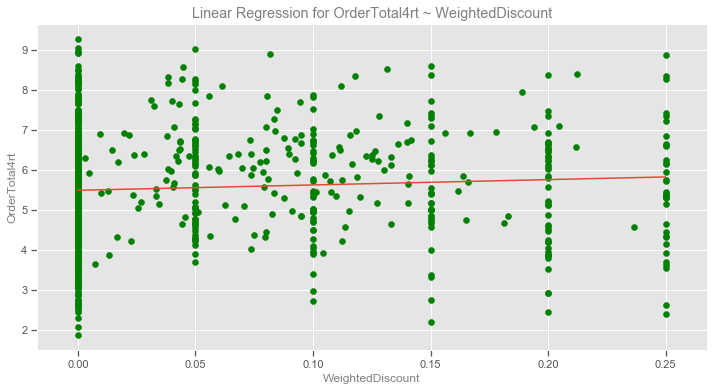

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          OrderTotal4rt   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.034
Date:                Sun, 05 Apr 2020   Prob (F-statistic):             0.0449
Time:                        22:54:08   Log-Likelihood:                -1379.4
No. Observations:                 785   AIC:                             2763.
Df Residuals:                     783   BIC:                             2772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.4978      0.062     89.129      0.000       5.377       5.619
WeightedDiscount     1.3369      0.666      2.008      0.045       0.030       2.643
==============================================================================
Omnibus:                        6.011   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                4.436
Skew:                           0.042   Prob(JB):                        0.109
Kurtosis:                       2.642   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic    p_value
Goldfeld-Quandt     1.16512  0.0763808

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 0.091547 
 0.996294 
 
 
 p-value 
 0.000004 
 0.061586 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 0.490054 
 0.783

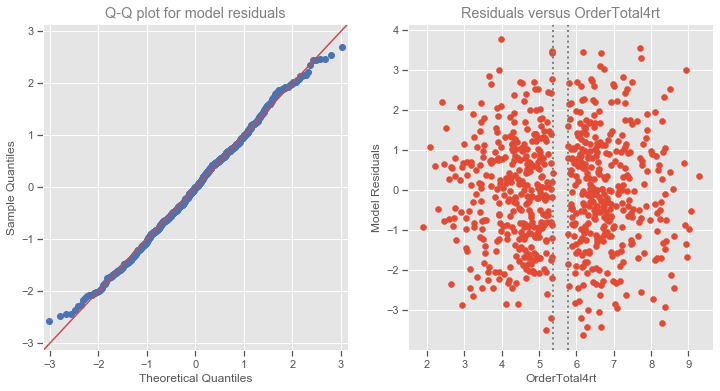

In [50]:
# Performing a regression with the continuous variable WeightedDiscount:
# Null Hypothesis: the coefficient for the predictor is actually zero
# Alternative Hypothesis: the coefficient is nonzero and there is a linear relationship
# Alpha = 0.05 (95% confidence)
do_a_linreg(tukey_df, 'WeightedDiscount', 'OrderTotal4rt');

In [51]:
# Checking for reliability of regression results:
#   -The null hypothesis is not rejected for normality of residuals
#   -The null hypothesis is not rejected that the residuals are homoscedastic
#   -The null hypothesis of the J-B test that skew and kurtosis are non-normal is not rejected

# Establishing that the model is efficient, we can reject the null hypothesis that the 
# coefficient for WeightedDiscount is zero, since it has p-value lower than our alpha of 0.05. 
# This is equal to the p-value from the F-test,
# since only one predictor was used and thus only one coefficient was generated. 

# It can be observed from the model summary that the Jarque-Bera test result on the 
# residuals is failing to reject the null hypothesis that the residuals are normally 
# distributed, based on skew and kurtosis measurements.
# From the tests on the residuals we can see that the Q-Q plot looks normal, and that the
# Shapiro-Wilk and Anderson-Darling tests have failed to reject the null hypothesis that
# the residuals are normal. Additionally, the Goldfeld-Quandt test has failed to reject the 
# null hypothesis that the data is homoscedastic. This all points to reliable parameter
# estimates. 

# All this being said, I think that this is probably not the best way to model the data.
# When I originally looked at the group data, it seemed to me that there were positive 
# effects for every group, but that
# those positive effects began to diminish in every discount group after 0.5.
# This would make sense intuitively since larger average discount on an order would decrease 
# the overall total of the order.

In [52]:
# I want to test if there is a negative linear relationship between WeightedDiscount over 0.0  
# and OrderTotal4rt.

# To do this, I will use 2 tests: a linear regression to test for a negative linear coefficient
# with a significance threshold (alpha) of 0.05, and a pearson correlation score testing for a 
# negative score with the same significance threshold.

Linear Regression for OrderTotal4rt ~ WeightedDiscount


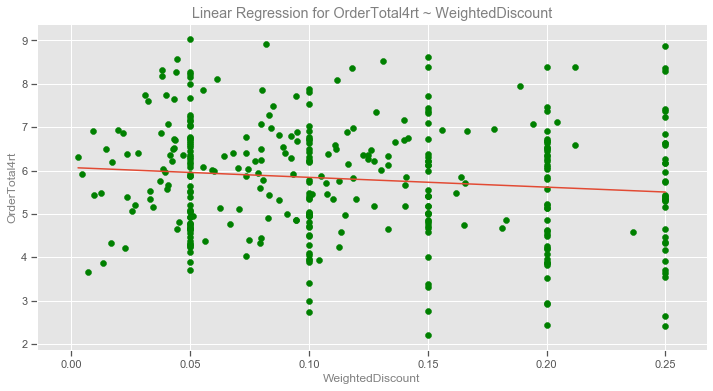

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          OrderTotal4rt   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.230
Date:                Sun, 05 Apr 2020   Prob (F-statistic):             0.0228
Time:                        22:54:23   Log-Likelihood:                -602.71
No. Observations:                 359   AIC:                             1209.
Df Residuals:                     357   BIC:                             1217.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.0695      0.135     44.838      0.000       5.803       6.336
WeightedDiscount    -2.2590      0.988     -2.287      0.023      -4.202      -0.316
==============================================================================
Omnibus:                        1.323   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.516   Jarque-Bera (JB):                1.255
Skew:                           0.011   Prob(JB):                        0.534
Kurtosis:                       2.711   Cond. No.                         14.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic   p_value
Goldfeld-Quandt      1.0566  0.364045

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 0.100782 
 0.99522 
 
 
 p-value 
 0.001257 
 0.33692 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 0.506045 
 0.778

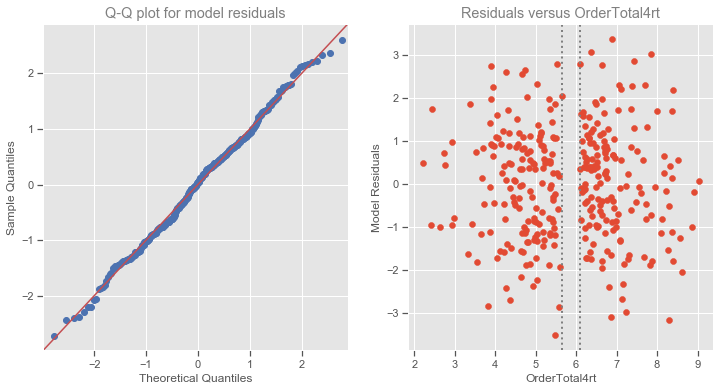

In [53]:
# Checking linear relationship between continuous WeightedDiscount and OrderTotal4rt
# Null Hypothesis: the coefficient is zero and there is no linear relationship
# Alternative Hypothesis: there is a linear relationship btw the variables
# alpha = 0.05
do_a_linreg(tukey_df[tukey_df['WeightedDiscount'] > 0.0], 'WeightedDiscount', 'OrderTotal4rt');

In [54]:
# The null hypothesis that the residuals from the model are normal is not rejected.
# The null hypothesis that the residuals are homoscedastic is not rejected.
# The null hypothesis of the J-B and Omnibus are not rejected
# The null hypothesis of the F-test is rejected, establishing at least one coefficient is
# nonzero.
# Given the assumptions of the model have been met,
# the significant p-value for the coefficient can allow us to confidently reject the
# null hypothesis that the coefficient is zero, and there is no linear relationship.
# The coefficient in this model is greater in magnitude, and also has a lower p-value than
# the positive coefficient generated when the control group was included in the regression.
# Modeling the data in this way greatly increased the normality and homoscedasticity of the
# residuals from the last model.
# Modelling the relationship without the control group shows us that profits can be maximized
# using smaller, non-zero discounts.

In [55]:
# Performing the pearson correlation test:
# Null Hypothesis: there is no linear correlation
# Alternative Hypothesis: there is a linear correlation
# alpha = 0.05
corr, pval = stats.pearsonr(tukey_df[tukey_df.WeightedDiscount > 0.0].WeightedDiscount, 
                            tukey_df[tukey_df.WeightedDiscount > 0.0].OrderTotal4rt)
print("Pearson r: {}\np-val: {}".format(corr,pval))

Pearson r: -0.12015665151020724
p-val: 0.022788669908861883


In [56]:
# Again we can see a significant negative correlation, meaning that we can say with 95%
# confidence that there is a linear relationship between WeightedDiscount > 0.0 and OrderTotal4rt,
# meaning that when considering orders that have a non-zero discount applied, higher
# discounts lead to lower overall sales totals. Combining this with the knowledge that a
# weighted order discount of 0.05 has a large, statistically significant positive effect on 
# OrderTotal, we could conclude that 0.05 discount for an order is the most profitable group.

In order to make comparisons between the groups and their effect on OrderTotal compared to the control group, we can use a linear regression with the categorical Discount variable.

Linear Regression for OrderTotal4rt ~ Discount


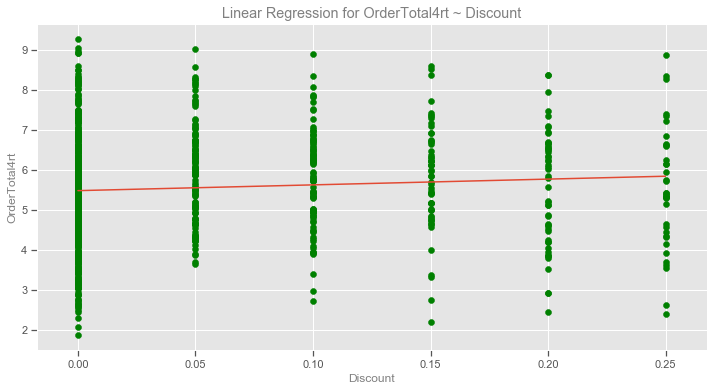

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          OrderTotal4rt   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.639
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           0.000353
Time:                        22:54:37   Log-Likelihood:                -1369.9
No. Observations:                 785   AIC:                             2752.
Df Residuals:                     779   BIC:                             2780.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.3740      0.067     79.741      0.000       5.242       5.506
Discount[T.0.05]     0.5977      0.143      4.171      0.000       0.316       0.879
Discount[T.0.1]      0.4346      0.159      2.730      0.006       0.122       0.747
Discount[T.0.15]     0.4492      0.196      2.290      0.022       0.064       0.834
Discount[T.0.2]      0.1838      0.204      0.900      0.369      -0.217       0.585
Discount[T.0.25]     0.1670      0.241      0.692      0.489      -0.307       0.641
==============================================================================
Omnibus:                        6.610   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                5.309
Skew:                           0.107   Prob(JB):                       0.0703
Kurtosis:                       2.659   Cond. No.                         5.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic   p_value
Goldfeld-Quandt     1.14564  0.102947

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 0.094731 
 0.996381 
 
 
 p-value 
 0.000001 
 0.068999 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 0.470935 
 0.783

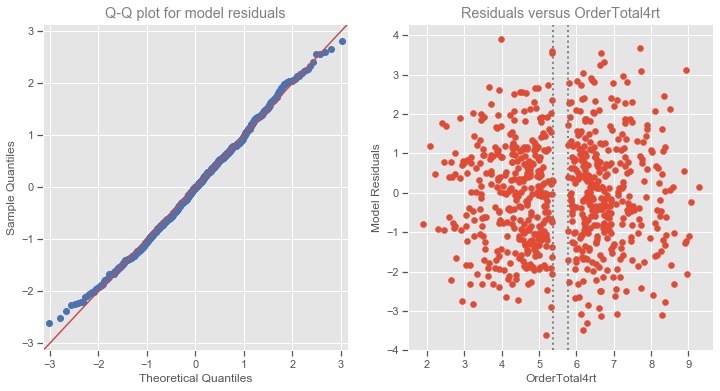

In [57]:
# Performing a linear regression with Discount categories, 
# looking for coefficients w p-val < 0.05 to reject null hypothesis that the corresponding group
# coefficient is zero.
# The Null hypothesis for the F-test is that the variance between the groups is caused by chance,
# a p-value < 0.05 will support alternate hypothesis that the variance is not due to chance,
# and that all of the coefficients are not equal to zero.
lm = do_a_linreg(tukey_df, 'Discount', 'OrderTotal4rt')

In [58]:
# The null hypothesis that the residuals are normal is not rejected
# The null hypothesis that the residuals are homoscedastic is not rejected.
# The null hypothesis of J-B test is not rejected, though it is for Omnibus
# The null hypothesis of the F test is rejected, indicated at least on nonzero coefficient
# From this regression, we can see that the 0.05, 0.10, and 0.15 discount groups have positive
# coefficients with significant p-values. The coefficients have a downward trend from 0.05 to
# 0.25, which indicates the negative linear relationship between OrderTotal and Discount when
# considering only the treatment groups.

<a id='anova1'></a>
#### ANOVA and Post-Hoc tests

In [59]:
# By generating an ANOVA table from the model, we can see that the F-statistic for the discount
# feature is the same as that for the linear model for that variable as listed above, with the
# same p-value. The null hypothesis of the F test is that all of the groups are derived from a 
# common distribution. If the F test is significant, it means one of the groups is statistically
# different from the rest.
anova_table = sm.stats.anova_lm(lm, typ=2)
anova_table

sum_sq     df         F    PR(>F)
Discount    44.877361    5.0  4.639039  0.000353
Residual  1507.185720  779.0       NaN       NaN

In [60]:
# There is a Welch's ANOVA that is available that does not assume equal variances of the groups.
# Even though we did not reject the homogeneity of the variances, it seems appropriate to use 
# a test which would be unaffected if the conclusion reached from those tests had been wrong.
pingouin.parametric.welch_anova(data=tukey_df, dv='OrderTotal4rt', between='Discount')

Source  ddof1    ddof2      F     p-unc
0  Discount      5  160.014  5.072  0.000242

In [61]:
# We can see that in this case of likely having equal variances, the results from the Welch's
# ANOVA and the classical ANOVA are nearly identical, which is a good reason to tend toward
# using the Welch's ANOVA in general.
# It seems as though the Welch's ANOVA has even more power in this scenario

I will start with some t-tests so that I can compare some other post-hoc tests and simulations to them. However, for hypothesis testing, I will be revisiting pairwise t-tests, so for now these are strictly for benchmarking.

In [62]:
# Pairwise Welch's t-test
results = sp.posthoc_ttest(tukey_df, 
                           val_col='OrderTotal4rt', 
                           group_col='Discount',
                           equal_var=False,
                           #p_adjust='holm'
                          )
results

0.00      0.05      0.10      0.15      0.20      0.25
0.00 -1.000000  0.000010  0.003159  0.019818  0.388507  0.533657
0.05  0.000010 -1.000000  0.334390  0.475607  0.073788  0.130001
0.10  0.003159  0.334390 -1.000000  0.946174  0.291502  0.353838
0.15  0.019818  0.475607  0.946174 -1.000000  0.319822  0.366818
0.20  0.388507  0.073788  0.291502  0.319822 -1.000000  0.958912
0.25  0.533657  0.130001  0.353838  0.366818  0.958912 -1.000000

In [63]:
# Pairwise student's t-test with pooled_sd
results = sp.posthoc_ttest(tukey_df, 
                           val_col='OrderTotal4rt', 
                           group_col='Discount',
                           pool_sd=True,
                           #p_adjust='holm'
                          )
results

0.00      0.05      0.10      0.15      0.20      0.25
0.00 -1.000000  0.000034  0.006482  0.022304  0.368537  0.489219
0.05  0.000034 -1.000000  0.395305  0.506443  0.073129  0.103307
0.10  0.006482  0.395305 -1.000000  0.950224  0.298183  0.327448
0.15  0.022304  0.506443  0.950224 -1.000000  0.320150  0.340970
0.20  0.368537  0.073129  0.298183  0.320150 -1.000000  0.955581
0.25  0.489219  0.103307  0.327448  0.340970  0.955581 -1.000000

In [64]:
# We can see that using the pooled variance in the groupwise t-tests reduced the p-values for
# groups which had small sample sizes and increased the p-value for those that had large sample
# sizes. This is likely because small samples have large sampling errors, and the larger they
# get that error decreases.

In [65]:
# A popular post-hoc test is the Tukey HSD. It assumes equal variance of the groups, which
# was tested for earlier, when the hypothesis was not rejected.
# It is important to note that the Tukey HSD compensates for multiple comparisons, and since
# we are making more here than is needed (because for this data there is a well defined control
# group, and no need to test the treatment groups against each other), this adjustment will 
# likely cause a lack of power in finding significant differences between each group and the
# control.
results = sp.posthoc_tukey_hsd(tukey_df.OrderTotal4rt,
                               tukey_df.Discount,
                               alpha=0.05
                              )
results

0.0  0.05  0.1  0.15  0.2  0.25
0.0    -1     1    0     0    0     0
0.05    1    -1    0     0    0     0
0.1     0     0   -1     0    0     0
0.15    0     0    0    -1    0     0
0.2     0     0    0     0   -1     0
0.25    0     0    0     0    0    -1

In [66]:
# We can see the tukey hsd function has produced a table of 0's for non-significance and 1's
# representing significant differences. Only the control vs 0.05 comparison is significant
# according to the Tukey HSD test, probably due to the multiple comparison compensation

In [304]:
# According to the Pingouin documentation, the Tukey HSD is optimal if assuming equal variances.
# They say that when not assuming equal variances, the Games & Howell test is best. Earlier,
# the Brown & Forsythe test did not reject the null hypothesis of equal variances, but it does
# not mean that the variances are equal among the groups. Let's see how the Games & Howell test
# compares to the Tukey HSD
pingouin.pairwise_gameshowell(data=tukey_df, dv='OrderTotal4rt', between='Discount')

A     B  mean(A)  mean(B)   diff     se       tail      T       df  \
0   0.00  0.05    5.374    5.972 -0.598  0.093  two-sided -4.531  225.598   
1   0.00  0.10    5.374    5.809 -0.435  0.102  two-sided -2.999  155.041   
2   0.00  0.15    5.374    5.823 -0.449  0.133  two-sided -2.380   75.481   
3   0.00  0.20    5.374    5.558 -0.184  0.150  two-sided -0.868   64.455   
4   0.00  0.25    5.374    5.541 -0.167  0.188  two-sided -0.628   40.492   
5   0.05  0.10    5.972    5.809  0.163  0.119  two-sided  0.968  198.490   
6   0.05  0.15    5.972    5.823  0.149  0.147  two-sided  0.716  102.733   
7   0.05  0.20    5.972    5.558  0.414  0.162  two-sided  1.810   84.252   
8   0.05  0.25    5.972    5.541  0.431  0.198  two-sided  1.540   48.944   
9   0.10  0.15    5.809    5.823 -0.015  0.153  two-sided -0.068  111.345   
10  0.10  0.20    5.809    5.558  0.251  0.167  two-sided  1.061   91.985   
11  0.10  0.25    5.809    5.541  0.268  0.202  two-sided  0.935   52.913   
12  0.15  0.20    5.823    5.558  0.265  0.188  two-sided  1.000  103.718   
13  0.15  0.25    5.823    5.541  0.282  0.220  two-sided  0.909   66.193   
14  0.20  0.25    5.558    5.541  0.017  0.230  two-sided  0.052   72.084   

        pval  hedges  
0   0.001000  -0.466  
1   0.033933  -0.343  
2   0.168352  -0.335  
3   0.900000  -0.127  
4   0.900000  -0.109  
5   0.900000   0.133  
6   0.900000   0.115  
7   0.460961   0.299  
8   0.617175   0.291  
9   0.900000  -0.011  
10  0.892304   0.183  
11  0.900000   0.183  
12  0.900000   0.190  
13  0.900000   0.192  
14  0.900000   0.011

In [ ]:
# We can see they by not assuming equal variance, we have lowered the p-value of the 0.10 group
# to the point of significance

In [67]:
# Some other tests I'd like to try need the groups to not have decimals in their names
# Fixing labels into a new discount column with no decimals for compatibility with tests:
tukey_df['Discount2'] = tukey_df['Discount'].replace({0.0: '0.0',
                                                     0.05: '0.05',
                                                     0.10: '0.10',
                                                     0.15: '0.15',
                                                     0.20: '0.20',
                                                     0.25: '0.25'})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
# Running parametric post-hoc test which assumes the population variances are equal
results = sp.posthoc_scheffe(tukey_df,
                             val_col='OrderTotal4rt',
                             group_col='Discount2',
                             #p_adjust='bonferroni'
                            )
results

0.0      0.05      0.10      0.15      0.20      0.25
0.0  -1.000000  0.004062  0.190566  0.387842  0.976348  0.992856
0.05  0.004062 -1.000000  0.981602  0.994076  0.666173  0.752147
0.10  0.190566  0.981602 -1.000000  1.000000  0.955416  0.965617
0.15  0.387842  0.994076  1.000000 -1.000000  0.963299  0.969559
0.20  0.976348  0.666173  0.955416  0.963299 -1.000000  1.000000
0.25  0.992856  0.752147  0.965617  0.969559  1.000000 -1.000000

In [69]:
# The Scheffe test seems very conservative, as even without a p-value adjustment, it has only
# shown the 0.5 group to be significant compared to the control.

In [70]:
# Comparing above test to another post-hoc test which does not assume equal pop variances
# This test also implicitly accounts for the multiple comparisons.
results = sp.posthoc_tamhane(tukey_df,
                             val_col='OrderTotal4rt',
                             group_col='Discount2',
                             welch=True, # makes this a Tamhane T2 test
                             sort=True)
results

0.0      0.05      0.10      0.15      0.20      0.25
0.0  -1.000000  0.000057  0.018802  0.113173  0.947718  0.989714
0.05  0.000057 -1.000000  0.913040  0.979206  0.368662  0.566378
0.10  0.018802  0.913040 -1.000000  1.000000  0.873517  0.927214
0.15  0.113173  0.979206  1.000000 -1.000000  0.900977  0.935558
0.20  0.947718  0.368662  0.873517  0.900977 -1.000000  1.000000
0.25  0.989714  0.566378  0.927214  0.935558  1.000000 -1.000000

In [71]:
# It looks as though the Tamhane T2 test produces lower p-values than the Scheffe test for these
# data, but both seem far more conservative than the t-tests above, because the p_values have
# been adjusted to account for multiple comparisons. 
# The Tamhane T2 is less conservative than the Scheffe, returning a significant p-value for both
# the 0.05 and 0.10 groups compared to the control.
# I will run the t-tests again below with a p-value adjustment turned on to compare to the 
# tamhane T2
results = sp.posthoc_ttest(tukey_df,
                           val_col='OrderTotal4rt',
                           group_col='Discount',
                           equal_var=False,
                           p_adjust='bonferroni'
                          )
results

0.00      0.05      0.10      0.15  0.20  0.25
0.00 -1.000000  0.000143  0.047379  0.297277   1.0   1.0
0.05  0.000143 -1.000000  1.000000  1.000000   1.0   1.0
0.10  0.047379  1.000000 -1.000000  1.000000   1.0   1.0
0.15  0.297277  1.000000  1.000000 -1.000000   1.0   1.0
0.20  1.000000  1.000000  1.000000  1.000000  -1.0   1.0
0.25  1.000000  1.000000  1.000000  1.000000   1.0  -1.0

In [72]:
# We can see that applying the bonferroni p-value adjustment to the t-tests has put them in
# between the Tamhane T2 and Scheffe test in terms of conservativeness.

<a id='kw1'></a>
#### Kruskal-Wallis and Dunn's test

In [73]:
# Kruskal-Wallis and Dunn's test are the non-parametric alternatives to ANOVA and t-tests
# Kruskal-Wallis is to Dunn's test what ANOVA is to pairwise t-tests. Kruskal-Wallis test
# uses ranked sums to determine if any one of the groups are statistically different than the
# others, then, if the null hypothesis that all groups are sampled from an identical
# distribution is rejected, one would follow up with a Dunn's test to get the pairwise
# comparisons between groups.

In [74]:
stats.kruskal(tukey_df.Discount, tukey_df.OrderTotal4rt)

KruskalResult(statistic=1201.6716138768602, pvalue=2.6424757914041336e-263)

In [75]:
# The null hypothesis that the groups are all drawn from the same distribution can be rejected.
# Now to follow up with the non-parametric Dunn's test, which uses ranked sums.
results = sp.posthoc_dunn(tukey_df, 
                          val_col='OrderTotal4rt', 
                          group_col='Discount2',
                          p_adjust='bonferroni',
                          sort=True)
results

0.0      0.05     0.10      0.15  0.20  0.25
0.0  -1.000000  0.000844  0.06885  0.213479   1.0   1.0
0.05  0.000844 -1.000000  1.00000  1.000000   1.0   1.0
0.10  0.068850  1.000000 -1.00000  1.000000   1.0   1.0
0.15  0.213479  1.000000  1.00000 -1.000000   1.0   1.0
0.20  1.000000  1.000000  1.00000  1.000000  -1.0   1.0
0.25  1.000000  1.000000  1.00000  1.000000   1.0  -1.0

In [315]:
# We can see that Dunn's test has produced p-values which are very similar to the t-test,
# except that it has a non-significant p-val for 0.10. 
# Since this test is non-parametric, I am curious to see how it performs on the non-transformed
# variable
results = sp.posthoc_dunn(tukey_df, 
                          val_col='OrderTotal', 
                          group_col='Discount2',
                          p_adjust='bonferroni',
                          sort=True)
results

0.0      0.05     0.10      0.15  0.20  0.25
0.0  -1.000000  0.000844  0.06885  0.213479   1.0   1.0
0.05  0.000844 -1.000000  1.00000  1.000000   1.0   1.0
0.10  0.068850  1.000000 -1.00000  1.000000   1.0   1.0
0.15  0.213479  1.000000  1.00000 -1.000000   1.0   1.0
0.20  1.000000  1.000000  1.00000  1.000000  -1.0   1.0
0.25  1.000000  1.000000  1.00000  1.000000   1.0  -1.0

In [ ]:
# We can see that the Dunn's test produces identical p-values when taking the non-transformed
# variable. This could make it very useful for comparing groups without having to do the 
# transformation step.

In [317]:
# Running the same test with an appropriate p-value adjustment for this study
results = sp.posthoc_dunn(tukey_df, 
                          val_col='OrderTotal', 
                          group_col='Discount2',
                          #p_adjust='bonferroni',
                          sort=True)
pd.DataFrame(results.drop(columns=['0.0']).loc['0.0'] * 5).T

0.05     0.10     0.15      0.20      0.25
0.0  0.000281  0.02295  0.07116  1.513772  2.652034

In [77]:
# I would like to do a makeshift Dunnett's post-hoc test, which tests each treatment 
# group against only the control group, using a pooled variance across all groups, and
# adjusting p-values to deal with the multiple comparison problem with less magnitude due to
# fewer comparisons as a result of not comparing treatment groups to one another. I was 
# unable to locate a prewritten function but as I understand it is just a pairwise t-test that
# takes the pooled variance across all treatment groups, then applies a p-value correction

In [78]:
# A function to run a (bootleg) Dunnett's test: (python does not seem to offer one)
def dunnets_test(dataframe, feature, target, control=0.0, alternate='both', p_adjust=True):
    groups = dataframe.groupby(feature)[target]
    pooled_var = mf.pooled_variance(groups)
    p_vals = {}
    for name, group in groups:
        if name == control:
            control_group = group
        else:
            group_dict = {}
            t_stat = mf.dunnets_tstat(group, control_group, pooled_var)
            if alternate == 'both':
                t_stat = np.abs(t_stat)
            df = len(control_group) + len(group) - 2
            lower_tail = stats.t.cdf(t_stat, df)
            upper_tail = 1 - stats.t.cdf(t_stat, df)
            
            if alternate == 'both':
                group_dict['p-val'] = 2 * upper_tail
            elif alternate == 'lower':
                group_dict['p-val'] = lower_tail
            elif alternate == 'higher':
                group_dict['p-val'] = upper_tail
            else:
                print("Error: invalid alternate hypothesis. Options are 'both', 'lower', and 'higher'0")
                break
                
            if p_adjust == True:
                group_dict['p-val'] *= (len(groups) - 1)
            if group_dict['p-val'] > 1:
                group_dict['p-val'] = 1
            p_vals[name] = group_dict
    results = pd.DataFrame.from_dict(p_vals)
    return results

In [79]:
dunnets_test(tukey_df, 'Discount', 'OrderTotal4rt', p_adjust=False)

0.05      0.10      0.15      0.20      0.25
p-val  0.000001  0.001365  0.007168  0.289163  0.414925

In [80]:
dunnets_test(tukey_df, 'Discount', 'OrderTotal4rt', p_adjust=True)

0.05      0.10      0.15  0.20  0.25
p-val  0.000006  0.006827  0.035841     1     1

In [81]:
# As we can see, using the pooled variance across all groups has helped the p-values for
# groups which had smaller sample sizes and thus large sampling errors. These results are
# similar to the t-tests earlier, but the test seems to be producing more liberal scores, 
# which are useful when making p-value adjustments
# It seems like perhaps the scikit function was using the pooled
# variances of only the groups being tested against one another

# Using the pooled variance, and establishing a clearly defined control group, has allowed
# for a p-value correction to be made to address the multiple comparison problem, without 
# having to multiply each p-value by k(k-1)/2, but rather only (k-1) since there is just one 
# set of comparisons.

After completing this section, I was pleasantly surprised to find a graphic on the internet that concisely summarizes the conclusions I reached in this process about the relative liberal/conservativeness of the different tests:
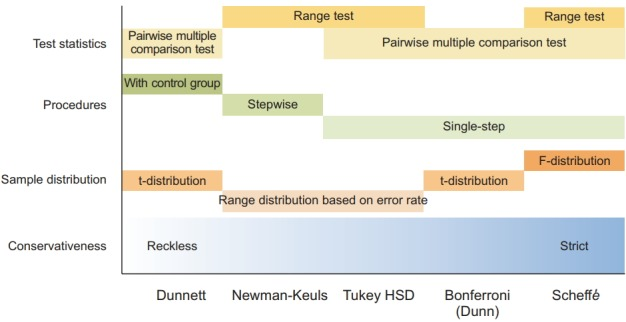
(image courtesy of https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6193594/figure/f3-kja-d-18-00242/)

In [82]:
# The source above informs me that the Dunnett and Newman-Keuls tests are similar in 
# conservativeness, but with a different mechanism. I had not yet heard of the Newman-Keuls
# test, so this is as good a time as any to try it for comparison
# According to wikipedia: "The Newman–Keuls method is similar to Tukey's range test as both 
# procedures use studentized range statistics.[5][6] Unlike Tukey's range test, the 
# Newman–Keuls method uses different critical values for different pairs of mean comparisons. 
# Thus, the procedure is more likely to reveal significant differences between group means and 
# to commit type I errors by incorrectly rejecting a null hypothesis when it is true. In other 
# words, the Neuman-Keuls procedure is more powerful but less conservative than Tukey's range 
# test.[6][7]"

On second thought, after some research on the test, I have found that [GraphPad.com](https://www.graphpad.com/support/faq/why-we-recommend-you-do-not-use-the-newman-keuls-multiple-comparison-test/) strongly recommends avoiding the Newman-Keuls test. I am going to move on instead.

<a id='ttest1'></a>
#### t-tests

The big issue with the post-hoc tests done above is that they were testing all of the groups against each other, and the p_value adjustments were tied to that number of comparisons. Since we have a well defined control group, it will only be necessary to make (k-1) comparisons, so I will write my own Welch's t-test function that will have this flexibility.

In [83]:
# The function uses independent Welch's t-tests to compare each treatment group to the control
# group (0.0 discount), then graph the results for comparison.

In [84]:
# Function for running a t-test for each discount group against the control group (no discount):
def compare_groups(dataframe, feature, targets, control_group=0.0, alpha=0.05, p_adjust=False):
    for target in targets:
        control = None
        info = {}
        grouped = dataframe.groupby([feature])[target]
        k = len(grouped) - 1
        for group in grouped:
            temp = {}
            if group[0] == control_group:
                control = np.array(group[1])
                continue
            else:
                test_group = np.array(group[1])
                stat, p = stats.ttest_ind(test_group, control, equal_var=False)
                if p_adjust:
                    p *= k
                    if p > 1:
                        p = 1
                effect_size = mf.cohen_d(test_group, control)
                size = len(test_group)
                temp['p-val'] = p
                temp['effect size'] = effect_size
                temp['size'] = size
                temp['power'] = tt_ind_solve_power(effect_size = effect_size,
                                                  nobs1 = size,
                                                  alpha = alpha)
                info[group[0]] = temp

        info = pd.DataFrame.from_dict(info)
        print('Testing {} groups for statistically significant effects on {}'.format(feature, target))
        display(info)
        X = list(info.columns)
        fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8), 
                                       gridspec_kw={"hspace": 0.05})
        ax1.set_title('Target: {}'.format(target), color='gray')
        ax1.plot(X, info.loc['p-val'], color='blue', label='p-value')
        ax1.axhline(y=alpha, ls='-.', label='alpha: {}'.format(alpha), alpha=0.7)
        ax1.set(xlabel='')
        ax1.legend()
        ax2.plot(X, info.loc['effect size'], color='g', label='effect size')
        ax2.set_xlabel('Discount Amount')
        ax2.legend()
        plt.show()

Testing Discount groups for statistically significant effects on OrderTotal4rt


0.05       0.10       0.15       0.20       0.25
p-val          0.000048   0.015793   0.099092   1.000000   1.000000
effect size    0.423841   0.306313   0.311317   0.126249   0.114059
size         121.000000  93.000000  57.000000  52.000000  36.000000
power          0.907169   0.546953   0.377585   0.097734   0.076482

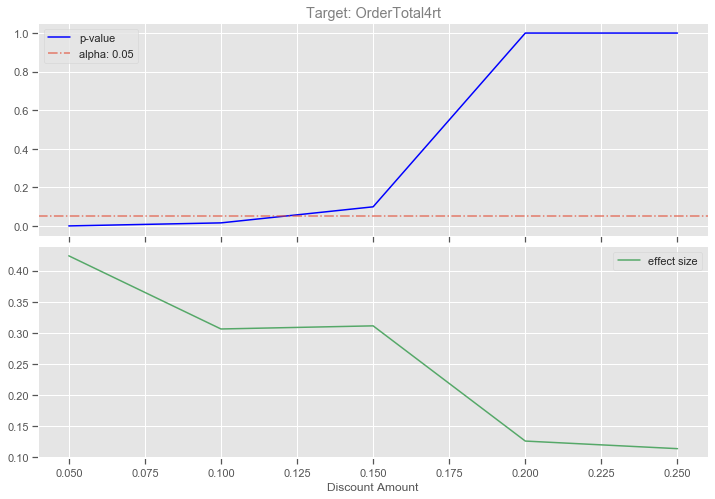

In [85]:
# The Null Hypothesis for each test is that the means of the control and test group are actually
# the same, that is, the effect size measured is due to chance, and is really zero.
# The Alternative Hypothesis is that the means of the control and test group are not the same, 
# resulting from treatment (a discount amount)
# This test will use alpha level 0.05 (95% confidence)
targets = ['OrderTotal4rt']
compare_groups(tukey_df, 'Discount', targets, 0.0, p_adjust=True)

In [86]:
# The null hypothesis can be rejected for the first 2 discount groups, supporting the
# alternative hypothesis that the effect size measured for these groups is not due to chance, 
# but rather due to the treatment of discount. The p-value adjustment was made to keep the
# overall chance of falsely finding significance in our groups to 5%. This means that with 
# a confidence of 95%, we can say that the 0.05 and 0.10 discount groups BOTH have postivie
# significant effects.

In [87]:
# We can see that there is a large and statistically significant effect on OrderTotal4rt
# associated with the 0.05 discount group, with positive effects diminishing as Discount
# increases, visually apparent in the graph above. Earlier we found that this linear
# relationship was significant. Pairing this with the knowledge that the effect on OrderTotal4rt
# by the 0.05 discount group is significant, we can conclude that the 0.05 discount group
# provides the highest Order Totals on average. This means that it is unneccessary to offer
# average discounts in an order in excess of 0.05 in order to get the maximum boost in sales,
# and that any more discount will decrease the gains acheived by offering a discount.

In [88]:
# It should be noted that the statistical power of these t-tests is only really satisfactory 
# for the first group, leaving increasing chance of failing to detect a significant difference 
# between the groups for each successive discount group. This may have something to do with the
# decreasing significance levels in each successive group. This is likely due to the smaller
# sample sizes of those treatment groups, and their disproportionality to the larger control group.
# To avoid the pitfalls of small sample sizes in frequentist analysis, I will turn to
# Bootstrap simulation, then finally to Bayesian Estimation

<a id='bootstrap1'></a>
#### Bootstrap Simulation

In [89]:
# A function to perform bootstrap simulations with a certain number of trials per group:
def bootstrap_sim(dataframe, feature, target, control_groups=None, num_trials=5000, alternate='both', param='mean', p_adjust=False, show_hist=False):
    controls = []
    groups = dataframe.groupby(feature)[target]
    if control_groups is None:
        controls = [x[0] for x in groups]
    else:
        try:
            it = iter(control_groups)
        except:
            controls = [control_groups]
        else:
            for cont in control_groups:
                controls.append(cont)
    results = pd.DataFrame()
    #k = len(groups) - 1
    #if len(controls) > 1:
    js = range(1, len(controls)+1)
    lst = [(len(groups) - j) for j in js]
    k = sum(lst)
    cols = len(groups) - 1
    row = 0
    string = ''
    
    if show_hist:
        fig, axes = plt.subplots(nrows=(k-cols)//cols + 1, 
                                 ncols=(cols),
                                 figsize=(12, 2*((k-cols)//cols + 1))
                                )
        fig.tight_layout(h_pad=2)
        axes = axes.flatten()
    
    if param == 'mean':
        param_function = np.mean
    elif param == 'median':
        param_function = np.median
    elif param == 'mode':
        param_function = pd.Series.mode
    elif param == 'var':
        param_function = np.var
    elif param == 'std':
        param_function = np.std
    else:
        return ("Error: invalid parameter passed.")
    
    print("Performing bootstrap simulation for parameter: {}".format(param))
    
    control_lists = []
    group_diffs = []
    combos = []
    measured_diffs = []
    prev_controls = []
    for control in controls:
        p_vals = {}
        #group_diffs = []
        print("Testing control group: {}".format(control))
        for name, group in groups:
            if name == control:
                control_group = group.copy()
                if param == 'mode':
                    control_param = np.mean(param_function(control_group))
                elif param == 'var' or param == 'std':
                    control_param = param_function(control_group, ddof=1)
                else:
                    control_param = param_function(control_group)
                
        for name, group in groups:
            group_p = {}
            diffs_list = []
            if name == control or name in prev_controls:
                continue
            if param == 'mode':
                exp_param = np.mean(param_function(group))
            elif param == 'var' or param == 'std':
                exp_param = param_function(group, ddof=1)
            else:
                exp_param = param_function(group)
            param_diff = exp_param - control_param
            further_diffs = 0

            if alternate == 'both':
                param_diff = np.abs(param_diff)            

            for i in range(num_trials):
                bA, bB = mf.bootstrap(list(control_group), list(group))
                if param == 'mode':
                    diff = np.mean(param_function(bB)) - np.mean(param_function(bA))
                    diffs_list.append(diff)
                else:
                    diff = param_function(bB) - param_function(bA)
                    diffs_list.append(diff)

                if alternate == 'both':
                    diff = np.abs(diff)

                if alternate == 'lower':
                    if diff <= param_diff:
                        further_diffs += 1
                elif alternate == 'both' or alternate == 'higher':
                    if diff >= param_diff:
                        further_diffs += 1
                else:
                    print("Error: invalid alternative hypothesis. Options are 'both', 'higher', or 'lower'")
                    break

            p = further_diffs / num_trials
            if p_adjust:
                string = "p-values adjusted for {} group comparisons".format(k)
                p *= k
                if p > 1:
                    p = 1
            group_p['p_val to {}'.format(control)] = p
            p_vals[name] = group_p
            measured_diffs.append(param_diff)
            group_diffs.append(diffs_list)
            combos.append((control, name))
            prev_controls.append(control)
            
        result = pd.DataFrame.from_dict(p_vals)
        results = pd.concat([results, result], axis=0)
            
    if show_hist:
        list_num = 0
        for ax in axes:
            if list_num > len(group_diffs):
                break
            group_list = group_diffs[list_num]
            diff_mean = round(np.mean(group_list), 2)
            diff_std = np.std(group_list, ddof=1)
            xs = np.linspace(min(group_list), max(group_list), 1000)
            ys = stats.norm.pdf(xs, loc=diff_mean, scale=diff_std)
            ax.plot(xs, ys, color='gray')
            ax.hist(group_list, alpha=0.6, density=True)
            ax.axvline(x=measured_diffs[list_num], 
                       ls=':', 
                       label='Mean: {}'.format(diff_mean),
                       color='black')
            ax.set_title('{} vs {}'.format(combos[list_num][0], combos[list_num][1]),
                        color='gray')
            #ax.legend()
            list_num += 1

        plt.show()
    print(string)
    
    return results             

Performing bootstrap simulation for parameter: mean
Testing control group: 0.0


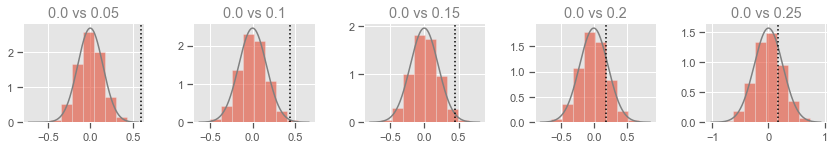

p-values adjusted for 5 group comparisons


0.05     0.10     0.15  0.20  0.25
p_val to 0.0  0.00025  0.03925  0.14725     1     1

In [90]:
# Running the simulation with 20000 trials per group
boot_results = bootstrap_sim(tukey_df, 
                             feature='Discount', 
                             target='OrderTotal4rt', 
                             control_groups=0.0,
                             num_trials=20000,
                             p_adjust=True,
                             show_hist=True,
                             #alternate='higher'
                            )
# Displaying calculated p-values from simulation
boot_results

In [91]:
# Using the function to compare all groups:
boot_results = bootstrap_sim(tukey_df,
                             feature='Discount',
                             target='OrderTotal4rt',
                             num_trials=20000,
                             p_adjust=False
                            )
boot_results

Performing bootstrap simulation for parameter: mean
Testing control group: 0.0
Testing control group: 0.05
Testing control group: 0.1
Testing control group: 0.15
Testing control group: 0.2
Testing control group: 0.25



0.05     0.10     0.15     0.20     0.25
p_val to 0.0    0.0  0.00865  0.02690  0.39085  0.51115
p_val to 0.05   NaN  0.33000  0.45935  0.05270  0.08155
p_val to 0.1    NaN      NaN  0.94730  0.26185  0.29765
p_val to 0.15   NaN      NaN      NaN  0.31545  0.34305
p_val to 0.2    NaN      NaN      NaN      NaN  0.95695

In [200]:
# We can see that the bootstrapping simulation has produced p-values that are very similar to
# the values that we have been getting from the pairwise t-tests. The Dunn's test also produced
# values similar to those from this simulation. It seems the bootleg Dunnett's test was too
# liberal, and the Scheffe and Tamhane T2 tests were too conservative, missing the significant
# effects, and therefore lacking power.

In [169]:
# One of the benefits of bootstrapping is that there is no normality assumption, which means 
# that I can run the raw OrderTotal feature in to compare the results to all of the tests which
# have been done on the transformed variable
boot_results = bootstrap_sim(tukey_df, 
                             feature='Discount', 
                             target='OrderTotal', 
                             control_groups=0.0,
                             num_trials=20000,
                             #alternate='higher'
                            )
boot_results

Performing bootstrap simulation for parameter: mean
Testing control group: 0.0
None


0.05    0.10     0.15     0.20    0.25
p_val to 0.0  0.0036  0.1213  0.12815  0.55125  0.4518

Performing bootstrap simulation for parameter: median
Testing control group: 0.0


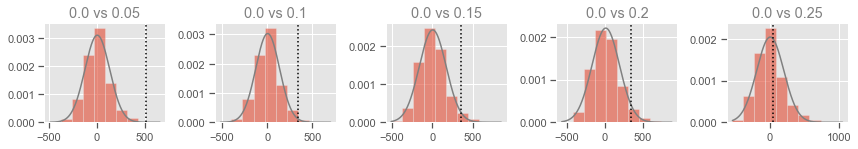

p-values adjusted for 5 group comparisons


0.05   0.10     0.15   0.20  0.25
p_val to 0.0  0.00225  0.071  0.17625  0.285     1

In [318]:
# This has changed the results drastically. Large mean differences have been made more common
# by resampling with replacement from a distribution with some extremely high outliers. It is
# preferable to use either median or mode for highly skewed data, let's see how this affects
# the test results
boot_results = bootstrap_sim(tukey_df, 
                             feature='Discount', 
                             target='OrderTotal', 
                             control_groups=0.0,
                             num_trials=20000,
                             param='median',
                             p_adjust=True,
                             show_hist=True,
                             #alternate='higher'
                            )
boot_results

Performing bootstrap simulation for parameter: var
Testing control group: 0.0
Testing control group: 0.05
Testing control group: 0.1
Testing control group: 0.15
Testing control group: 0.2
Testing control group: 0.25


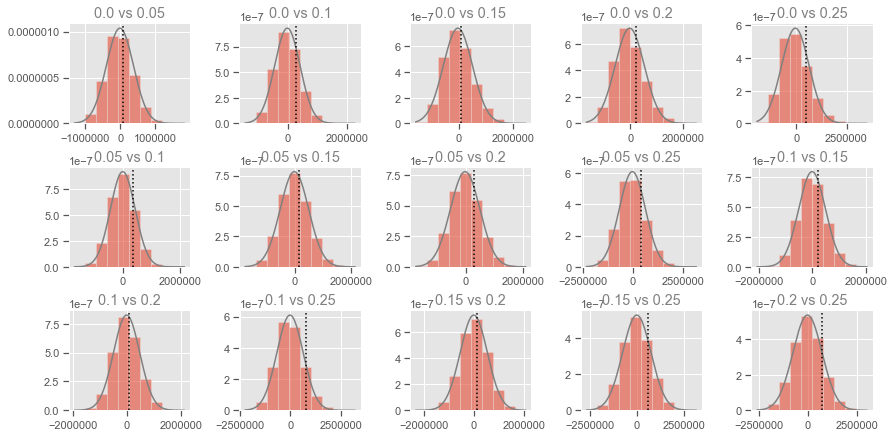

0.05    0.10     0.15     0.20    0.25
p_val to 0.0   0.82325  0.5046  0.89055  0.72545  0.4745
p_val to 0.05      NaN  0.3814  0.74535  0.57135  0.5169
p_val to 0.1       NaN     NaN  0.66665  0.85710  0.2199
p_val to 0.15      NaN     NaN      NaN  0.81670  0.4417
p_val to 0.2       NaN     NaN      NaN      NaN  0.3351

In [230]:
# Since we had done some testing for equal variance among groups earlier, let's see what the
# bootstrap simulation reveals about the comparisons of group variances
boot_results = bootstrap_sim(tukey_df, 
                             feature='Discount', 
                             target='OrderTotal',
                             num_trials=20000,
                             param='var',
                             show_hist=True,
                             #alternate='higher'
                            )
boot_results

In [ ]:
# The null hypothesis of equal variance is not rejected for any pairwise comparison.

In [ ]:
# We can see that each test fails to reject the null hypothesis that the standard deviations
# of each treatment group is the same as the control group. Again, this just means the treatments
# do not affect the variability OrderTotals, and says nothing about central tendency.

In [77]:
# Note: Permutation testing is not possible on this dataset because the sample sizes are too
# large

<a id='bayesian1'></a>
### Bayesian Approach
In the past decade, numerous papers have been written to suggest that Bayesian Analysis is superior to the classical frequentist methods that have been used so far (Ortega & Navarrete, 2017; Kruschke, 2012, 2018). Kruschke is quite firm on the matter, saying flatly that "Bayesian parameter estimation supersedes the NHST t test," and "provides much richer information." One of the big advantages is getting a posterior distribution for the parameter being estimated for a sample's underlying population, establishing a confidence interval for both the parameter and differences in that parameter between two groups.

The underlying idea is based on Bayes' Theorem, which is used to determine probability density of parameter values by applying the formula as so:
<c>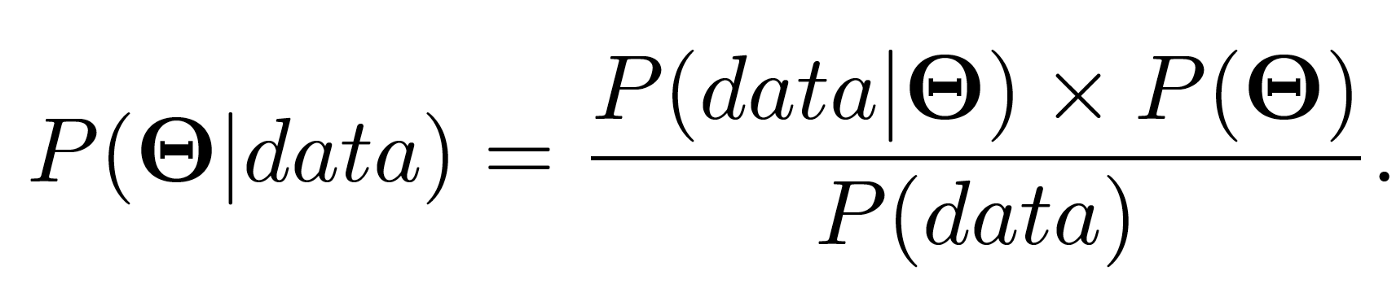</c>
(Image courtesy of <a href='https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348'>Towards Data Science</a>)<br>
Where theta is the parameter or set of parameters being estimated. In the case of a Gaussian distribution, theta can either represent mu, sigma, or both depending on the information that is available. In this case, we will infer sigma from the samples, which is usually not an unreasonable assumption.

<a id='best1'></a>
#### Bayesian Estimation (BEST)

In [75]:
# A function to produce a posterior distribution from a liklihood and prior:
def make_posterior(mu1, mu2, std1, std2, normalize=True):
    var1 = std1**2
    var2 = std2**2
    
    mu12 = (mu1*var2 + mu2*var1) / (var1 + var2)
    std12 = np.sqrt((var1*var2)/(var1 + var2))
    var12 = std12**2
    part1 = (1/(np.sqrt(2*np.pi*(var1*var2/var12))))
    part2 = np.exp(-.5*((mu1**2/var1)+(mu2**2/var2)-(mu12**2/var12)))
    scale = part1*part2
    
    def posterior(x):
        pd = (scale/(np.sqrt(2*np.pi)*std12))*np.exp(-1*((x-mu12)**2)/(2*var12))
        return pd
    
    return mu12, std12, posterior

2.1999999999999997 0.37947331922020555
0.010294658468535865


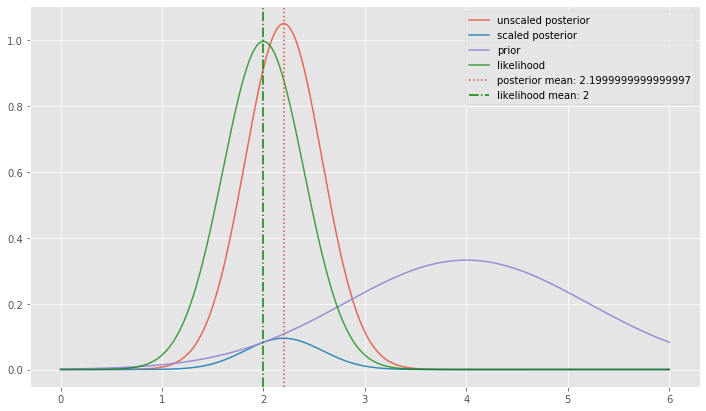

In [76]:
mu1, std1 = 4, 1.2
mu2, std2 = 2, 0.4
mu12, std12, posterior = make_posterior(mu1, mu2, std1, std2)
print(mu12, std12)
x = 3
print(posterior(x))
#stats.norm.pdf(x, loc=mu12, scale=std12)
xs = np.linspace(0, 6, 1000)
ys1 = stats.norm.pdf(xs, loc=mu12, scale=std12)
ys2 = [posterior(x) for x in xs]
ys3 = stats.norm.pdf(xs, loc=mu1, scale=std1)
ys4 = stats.norm.pdf(xs, loc=mu2, scale=std2)

fig, ax1 = plt.subplots(1, figsize=(12,7))
ax1.plot(xs, ys1, label='unscaled posterior', alpha=0.8)
ax1.plot(xs, ys2, label='scaled posterior')
ax1.plot(xs, ys3, label='prior')
ax1.plot(xs, ys4, label='likelihood', color='green', alpha=0.7)
ax1.axvline(mu12, ls=':', label='posterior mean: {}'.format(mu12))
ax1.axvline(mu2, ls='-.', label='likelihood mean: {}'.format(mu2), color='green')
plt.legend()
plt.show()

2.01980198019802 0.3980148760839957
0.004236021839126617


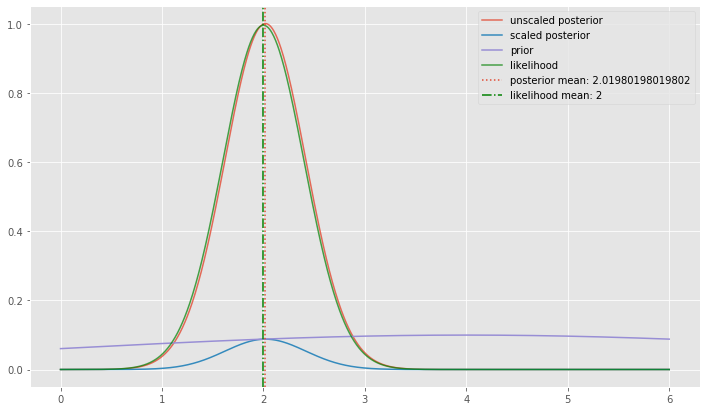

In [323]:
# It seems the posterior function is working properly.
# If we repeat the process with a wider prior, indicating less certainty about the prior
# parameters, we can see that the posterior becomes more heavily influenced by the likelihood
mu1, std1 = 4, 4
mu2, std2 = 2, 0.4
mu12, std12, posterior = make_posterior(mu1, mu2, std1, std2)
print(mu12, std12)
x = 3
print(posterior(x))
#stats.norm.pdf(x, loc=mu12, scale=std12)
xs = np.linspace(0, 6, 1000)
ys1 = stats.norm.pdf(xs, loc=mu12, scale=std12)
ys2 = [posterior(x) for x in xs]
ys3 = stats.norm.pdf(xs, loc=mu1, scale=std1)
ys4 = stats.norm.pdf(xs, loc=mu2, scale=std2)

fig, ax1 = plt.subplots(1, figsize=(12,7))
ax1.plot(xs, ys1, label='unscaled posterior', alpha=0.8)
ax1.plot(xs, ys2, label='scaled posterior')
ax1.plot(xs, ys3, label='prior')
ax1.plot(xs, ys4, label='likelihood', color='green', alpha=0.7)
ax1.axvline(mu12, ls=':', label='posterior mean: {}'.format(mu12))
ax1.axvline(mu2, ls='-.', label='likelihood mean: {}'.format(mu2), color='green')
plt.legend()
plt.show()

In [ ]:
# Above we can see that the posterior looks nearly identical to the most likely distribution
# for the observed data, as the prior is having almost no effect. 

In [242]:
# A function for metropolis MCMC algorithm:
def metropolis(data1, theta_seed1, theta_std1, data2=None, theta_seed2=None, theta_std2=None, samples=10000):
    theta_curr1 = theta_seed1
    posterior_thetas1 = []
    graph_thetas1 = []
    scaleA = np.std(data1, ddof=1)
    n1 = len(data1)
    calc_mean1 = np.mean(data1)
    post_std = theta_std1
    
    if data2 is not None:
        theta_curr2 = theta_seed2
        calc_mean2 = np.mean(data2)
        posterior_thetas2 = []
        theta_diffs = []
        effect_sizes = []
        graph_thetas2 = []
        scaleB = np.std(data2, ddof=1)
        actual_diff = calc_mean1 - calc_mean2
        actual_effect = actual_diff/np.sqrt((scaleA**2 + scaleB**2)/2)
        print("Performing MCMC for two groups")
        print("Mean of Group 1:", calc_mean1)
        print("Mean of Group 2:", calc_mean2)
        print("Measured Mean Difference:", actual_diff)
        print("Measured Effect Size:", actual_effect)
    
    for i in range(samples):
        theta_prop1 = np.random.normal(loc=theta_curr1, scale=post_std)
        likelihood_prop1 = 1
        if i == 0:
            likelihood_curr1 = 1
        #scaleA = min([np.random.normal(loc=scaleA, scale=0.05), 0])
        if data2 is not None:
            theta_prop2 = np.random.normal(loc=theta_curr2, scale=theta_std2)
            likelihood_prop2 = 1
            likelihood_curr2 = 1
            #scaleB = min([np.random.normal(loc=scaleB, scale=0.05), 0])
        #print(theta_prop1)
        
        #data1 = np.random.normal(loc=calc_mean1, scale=scaleA, size=n1)
        #mean1 = data1.mean()
        for datum in data1:
            pd_prop = stats.norm.pdf(x=datum, loc=theta_prop1, scale=scaleA)
            likelihood_prop1 *= pd_prop
            if i == 0:
                pd_curr = stats.norm.pdf(x=datum, loc=theta_curr1, scale=scaleA)
                likelihood_curr1 *= pd_curr
        
        posterior_prop1 = likelihood_prop1 * stats.norm.pdf(x=theta_prop1, loc=theta_curr1, scale=theta_std1)
        if i == 0:
            posterior_curr1 = likelihood_curr1 * stats.norm.pdf(x=theta_curr1, loc=theta_curr1, scale=theta_std1)
        #posterior_prop1 = likelihood_prop1 * stats.uniform.pdf(x=theta_prop1, loc=theta_curr1, scale=theta_std1)
        #posterior_curr1 = likelihood_curr1 * stats.uniform.pdf(x=theta_curr1, loc=theta_curr1, scale=theta_std1)
        
        if data2 is not None:
            for datum in data2:
                pd_prop = stats.norm.pdf(x=datum, loc=theta_prop2, scale=scaleB)
                likelihood_prop2 *= pd_prop
                if i == 0 :
                    pd_curr = stats.norm.pdf(x=datum, loc=theta_curr2, scale=scaleB)
                    likelihood_curr2 *= pd_curr
                
            posterior_prop2 = likelihood_prop2 * stats.norm.pdf(x=theta_prop2, loc=theta_curr2, scale=theta_std2)
            if i == 0:
                posterior_curr2 = likelihood_curr2 * stats.norm.pdf(x=theta_curr2, loc=theta_curr2, scale=theta_std2)
            #posterior_prop2 = likelihood_prop2 * stats.uniform.pdf(x=theta_prop2, loc=theta_curr2, scale=theta_std2)
            #posterior_curr2 = likelihood_curr2 * stats.uniform.pdf(x=theta_curr2, loc=theta_curr2, scale=theta_std2)
        
        # Prevents division by zero:
        if posterior_curr1 == 0.0:
            posterior_curr1 = 2.2250738585072014e-308
        if data2 is not None and posterior_curr2 == 0.0:
            posterior_curr2 = 2.2250738585072014e-308
            
        p_accept_theta_prop1 = posterior_prop1/posterior_curr1
        rand_unif = np.random.uniform()
        if p_accept_theta_prop1 >= rand_unif:
            #post_mean, post_std, posterior = make_posterior(calc_mean1, theta_prop1, scaleA, post_std)
            theta_curr1 = theta_prop1
            posterior_curr1 = posterior_prop1
            #scaleA = scaleA
        posterior_thetas1.append(theta_curr1)
        if i % (samples/10) == 0:
            graph_thetas1.append(theta_curr1)
        
        if data2 is not None:
            #print(posterior_prop2, posterior_curr2)
            p_accept_theta_prop2 = posterior_prop2/posterior_curr2
            rand_unif = np.random.uniform()
            if p_accept_theta_prop2 >= rand_unif:
                theta_curr2 = theta_prop2
                posterior_curr2 = posterior_prop2
                
            posterior_thetas2.append(theta_curr2)
            theta_diff = theta_curr1 - theta_curr2
            theta_diffs.append(theta_diff)
            effect_sizes.append(theta_diff/np.sqrt((scaleA**2 + scaleB**2)/2))
        
            if i % (samples/10) == 0:
                graph_thetas2.append(theta_curr2)
                
    if data2 is not None:
        # Visualizing results of MCMC
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, 
                                                                 ncols=2,
                                                                 figsize=(12,12))
        ax1.hist(data1, density=True, alpha=0.6)
        ax1.set_title("Data Group 1 w. Post. Pred", color='gray')
        ax1.axvline(x=calc_mean1, ls=':', 
                    color=(.30,.30,.30), 
                    label='Group 1 Mean: {}'.format(calc_mean1))
        ax1.legend()
        xs = np.linspace(data1.min(), data1.max(), 1000)
        for theta in graph_thetas1:
            ys = stats.norm.pdf(xs, loc=theta, scale=scaleA)
            ax1.plot(xs, ys, color='gray')
        ax2.hist(posterior_thetas1, density=True, alpha=0.6)
        ax2.set_title("Posterior for Theta, Group 1", color='gray')
        ax2.axvline(x=np.mean(posterior_thetas1), 
                    ls=':', 
                    color=(.30,.30,.30), 
                    label='Mean of Posterior 1: {}'.format(np.mean(posterior_thetas1)))
        ax2.legend()
        ax3.hist(data2, density=True, alpha=0.6)
        ax3.set_title("Data Group 2 w. Post. Pred", color='gray')
        ax3.axvline(x=calc_mean2, 
                    ls=':',
                    color=(.30,.30,.30),
                    label='Group 2 Mean: {}'.format(calc_mean2))
        ax3.legend()
        xs = np.linspace(data2.min(), data2.max(), 1000)
        for theta in graph_thetas2:
            ys = stats.norm.pdf(xs, loc=theta, scale=scaleB)
            ax3.plot(xs, ys, color='gray')
        ax4.hist(posterior_thetas2, density=True, alpha=0.6)
        ax4.set_title("Posterior for Theta, Group 2", color='gray')
        ax4.axvline(x=np.mean(posterior_thetas2), 
                    ls=':',
                    color=(.30,.30,.30),
                    label='Mean of Posterior 2:: {}'.format(np.mean(posterior_thetas2)))
        ax4.legend()
        ax5.hist(theta_diffs, density=True, alpha=0.6)
        ax5.set_title("Differences btw Theta 1 and 2", color='gray')
        ax5.axvline(x=np.mean(theta_diffs), 
                    ls=':',
                    color=(.30,.30,.30),
                    label='Mean Difference: {}'.format(np.mean(theta_diffs)))
        ax5.legend()
        ax6.hist(effect_sizes, density=True, alpha=0.6)
        ax6.set_title("Effect Sizes", color='gray')
        ax6.axvline(x=np.mean(effect_sizes), 
                    ls=':',
                    color=(.30,.30,.30),
                    label='Mean Effect Size: {}'.format(np.mean(effect_sizes)))
        ax6.legend()
        plt.show()
        
        # Producing probability of null hypothesis:
        sizes = np.array(theta_diffs)
        sizes_mu = sizes.mean()
        sizes_std = sizes.std()
        conf_interval = stats.norm.interval(0.95, loc=sizes_mu, scale=sizes_std)
        if np.mean(theta_diffs) >= 0:
            calc_p_val = ((sum(sizes < 0) / len(sizes)) * 2)
            norm_p_val = (stats.norm.cdf(0, loc=sizes_mu, scale=sizes_std) * 2)
        else:
            calc_p_val = ((sum(sizes > 0) / len(sizes)) * 2)
            norm_p_val = (stats.norm.sf(0, loc=sizes_mu, scale=sizes_std) * 2)

        print("P_value numerically:", calc_p_val)
        print("P_value from normal dist:", norm_p_val)
        print("95% Confidence Interval for Mean Difference:", conf_interval)
        
        return theta_diffs, calc_p_val
        
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        ax1.set_title('Group 1 Data w Post. Pred', color='gray')
        ax1.hist(data1, density=True, alpha=0.6)
        ax1.axvline(x=calc_mean1, ls=':', color=(.30,.30,.30), label='Measured mean: {}'.format(calc_mean1))
        xs = np.linspace(min(data1), max(data1), 1000)
        for theta in graph_thetas1:
            ys = stats.norm.pdf(xs, loc=theta, scale=scaleA)
            ax1.plot(xs, ys, color='gray')
        ax1.legend()
        
        ax2.set_title('MCMC Mean Frequencies', color='gray')
        ax2.hist(posterior_thetas1, density=True, alpha=0.6)
        mcmc_theta1 = np.mean(posterior_thetas1)
        ax2.axvline(x=mcmc_theta1, ls=':', color=(.30,.30,.30), label='MCMC mean: {}'.format(mcmc_theta1))
        ax2.legend()
        plt.show()
        
        return posterior_thetas1

In [234]:
target_data1 = tukey_df[tukey_df.Discount == 0.10].OrderTotal4rt
target_data2 = tukey_df[tukey_df.Discount == 0.20].OrderTotal4rt

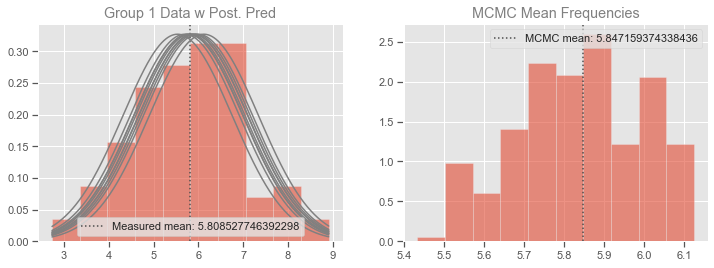

In [244]:
posterior = metropolis(data1 = target_data1, 
                       theta_seed1 = 5,
                       theta_std1 = 5,
                       samples = 2000
                      )

Performing MCMC for two groups
Mean of Group 1: 5.808527746392298
Mean of Group 2: 5.823138983630396
Measured Mean Difference: -0.014611237238097985
Measured Effect Size: -0.011490015243544555


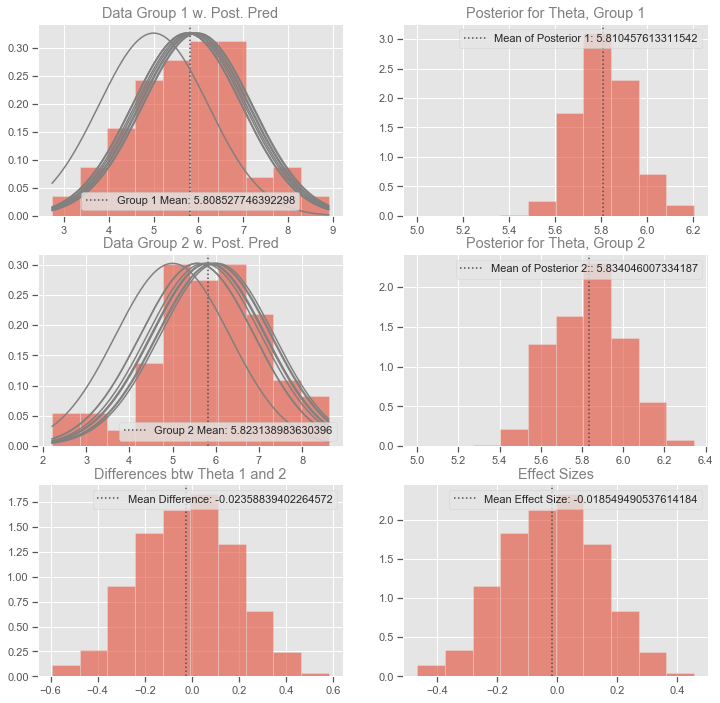

P_value numerically: 0.9416
P_value from normal dist: 0.9082893701890749
95% Confidence Interval for Mean Difference: (-0.4249235162955826, 0.37774672825029115)


In [243]:
# We can see that even after only 2000 trials, the mean of the distribution for theta (mean)
# has converged on the actual value for the data.
# Now to use the algorithm to compare 2 groups:
target_data1 = tukey_df[tukey_df.Discount == 0.10].OrderTotal4rt
target_data2 = tukey_df[tukey_df.Discount == 0.15].OrderTotal4rt
theta_diffs = metropolis(data1 = target_data1, 
                        theta_seed1 = 5,
                        theta_std1 = 5,
                        samples = 10000,
                        data2 = target_data2,
                        theta_seed2 = 5,
                        theta_std2 = 5,
                       )
# Note that we can compare this to p-values gotten from:
# Welch's t-test: .946
# Dunn's post-hoc: .899
# Bootstrap: .943

In [ ]:
# Phenomenal. The t-test, bootstrap, and MCMC simulation are within a percent in p-value

Performing MCMC for two groups
Mean of Group 1: 5.971669548990484
Mean of Group 2: 5.5577895408066285
Measured Mean Difference: 0.4138800081838552
Measured Effect Size: 0.30960588135138556


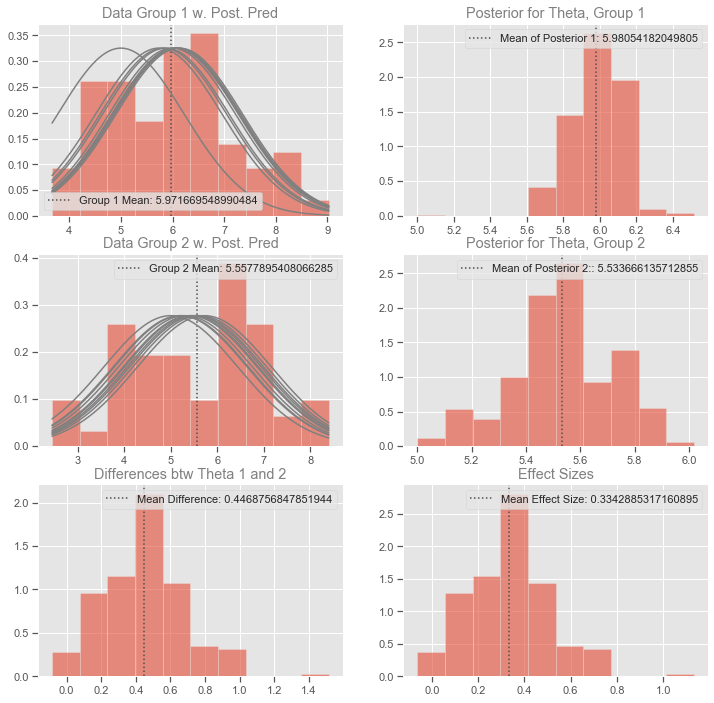

P_value numerically: 0.048
P_value from normal dist: 0.0551460269889072
95% Confidence Interval for Mean Difference: (-0.009842948390945683, 0.9035943179613345)


In [259]:
# Let's try the algorithm on two groups which had a low p-value between them
target_data1 = tukey_df[tukey_df.Discount == 0.05].OrderTotal4rt
target_data2 = tukey_df[tukey_df.Discount == 0.20].OrderTotal4rt
theta_diffs = metropolis(data1 = target_data1, 
                        theta_seed1 = 5,
                        theta_std1 = 5,
                        samples = 2000,
                        data2 = target_data2,
                        theta_seed2 = 5,
                        theta_std2 = 5,
                       )
# Comparing to p-values from:
# t-test: .074
# Dunn's: .112
# Bootstrap: .052

In [248]:
# Again we get a similar result, the algorithm appears to work, but not on the control group,
# because of the very large sample size. This is a fatal flaw

In [ ]:
# This hand written algorithm is very slow, I can only test 2 groups at a time, and it takes a
# while to finish. However, I can see after running some tests that it is
# generating p-values for pairwise group comparisons that are very similar to the values that
# we were getting from the pairwise t-tests and bootstrap simulations. The benefit to the 
# Bayesian analysis is that is has provided us a confidence window on the difference of means,
# which is more informative than a t-test, which only tells you the probability of the data
# given the p-value. Note that reliable results were generated using extremely uninformed priors.

# The problem with this algorithm is that it is not performing well on the large sample size
# of the control group (Discount 0.0) for this experiment. Instead, I will turn to a package
# written by experts, pymc3

In [93]:
# As the tutorial at https://github.com/FoamoftheSea/pymc3/blob/master/docs/source/notebooks/BEST.ipynb
# suggests, I will use the mean of the whole dataset for the prior, along with the std for the 
# dataset multiplied by two to indicate the uncertainty of the prior.
# Since we saw that the groups are all nearly normal earlier, I think modeling the posteriors
# with normal distributions is appropriate. This would also mean that modeling the mean priors
# with normal distributions is appropriate.
# For the mean priors, I will use the grand total mean and twice the grand total std from the
# data for a weakly informed prior.
# The priors for the stds I will set as uniform distributions between 0 and 10
σ_prior = tukey_df.OrderTotal4rt.std() * 2
µ_prior = tukey_df.OrderTotal4rt.mean()
σ_low = 0
σ_high = 10

#Setting target data
control_data = tukey_df[tukey_df.Discount == 0.0].OrderTotal4rt
discount5_data = tukey_df[tukey_df.Discount == 0.05].OrderTotal4rt
discount10_data = tukey_df[tukey_df.Discount == 0.10].OrderTotal4rt
discount15_data = tukey_df[tukey_df.Discount == 0.15].OrderTotal4rt
discount20_data = tukey_df[tukey_df.Discount == 0.20].OrderTotal4rt
discount25_data = tukey_df[tukey_df.Discount == 0.25].OrderTotal4rt

# Now to establish the statistical model with distributions for variables
with pm.Model() as model:
    # Setting priors for means
    control_mean = pm.Normal('control_mean', mu=µ_prior, sd=σ_prior)
    discount5_mean = pm.Normal('discount5_mean', mu=µ_prior, sd=σ_prior)
    discount10_mean = pm.Normal('discount10_mean', mu=µ_prior, sd=σ_prior)
    discount15_mean = pm.Normal('discount15_mean', mu=µ_prior, sd=σ_prior)
    discount20_mean = pm.Normal('discount20_mean', mu=µ_prior, sd=σ_prior)
    discount25_mean = pm.Normal('discount25_mean', mu=µ_prior, sd=σ_prior)
    
    # Setting priors for stds
    control_std = pm.Uniform('control_std', lower=σ_low, upper=σ_high)
    discount5_std = pm.Uniform('discount5_std', lower=σ_low, upper=σ_high)
    discount10_std = pm.Uniform('discount10_std', lower=σ_low, upper=σ_high)
    discount15_std = pm.Uniform('discount15_std', lower=σ_low, upper=σ_high)
    discount20_std = pm.Uniform('discount20_std', lower=σ_low, upper=σ_high)
    discount25_std = pm.Uniform('discount25_std', lower=σ_low, upper=σ_high)
    
    # Setting posteriors
    control = pm.Normal('0.0 Discount', mu=control_mean, sd=control_std, observed=control_data)
    discount5 = pm.Normal('0.05 Discount', mu=discount5_mean, sd=discount5_std, observed=discount5_data)
    discount10 = pm.Normal('0.10 Discount', mu=discount10_mean, sd=discount10_std, observed=discount10_data)
    discount15 = pm.Normal('0.15 Discount', mu=discount15_mean, sd=discount15_std, observed=discount15_data)
    discount20 = pm.Normal('0.20 Discount', mu=discount20_mean, sd=discount20_std, observed=discount20_data)
    discount25 = pm.Normal('0.25 Discount', mu=discount25_mean, sd=discount25_std, observed=discount25_data)
    
    # Setting deterministics:
    # mean differences
    control_v_5_means = pm.Deterministic('0% vs. 5% mean diff', control_mean - discount5_mean)
    control_v_10_means = pm.Deterministic('0% vs. 10% mean diff', control_mean - discount10_mean)
    control_v_15_means = pm.Deterministic('0% vs. 15% mean diff', control_mean - discount15_mean)
    control_v_20_means = pm.Deterministic('0% vs. 20% mean diff', control_mean - discount20_mean)
    control_v_25_means = pm.Deterministic('0% vs. 25% mean diff', control_mean - discount25_mean)
    # std differences
    control_v_5_stds = pm.Deterministic('0% vs 5% std diff', control_std - discount5_std)
    control_v_10_stds = pm.Deterministic('0% vs 10% std diff', control_std - discount10_std)
    control_v_15_stds = pm.Deterministic('0% vs 15% std diff', control_std - discount15_std)
    control_v_20_stds = pm.Deterministic('0% vs 20% std diff', control_std - discount20_std)
    control_v_25_stds = pm.Deterministic('0% vs 25% std diff', control_std - discount25_std)
    # effect sizes
    control_v_5_effect = pm.Deterministic('0% vs 5% effect', 
                                   control_v_5_means/np.sqrt((control_std**2+discount5_std**2)/2))
    control_v_10_effect = pm.Deterministic('0% vs 10% effect', 
                                   control_v_10_means/np.sqrt((control_std**2+discount10_std**2)/2))
    control_v_15_effect = pm.Deterministic('0% vs 15% effect', 
                                   control_v_15_means/np.sqrt((control_std**2+discount15_std**2)/2))
    control_v_20_effect = pm.Deterministic('0% vs 20% effect', 
                                   control_v_20_means/np.sqrt((control_std**2+discount20_std**2)/2))
    control_v_25_effect = pm.Deterministic('0% vs 25% effect', 
                                   control_v_25_means/np.sqrt((control_std**2+discount25_std**2)/2))

In [96]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [discount25_std, discount20_std, discount15_std, discount10_std, discount5_std, control_std, discount25_mean, discount20_mean, discount15_mean, discount10_mean, discount5_mean, control_mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:12<00:00, 779.89draws/s]


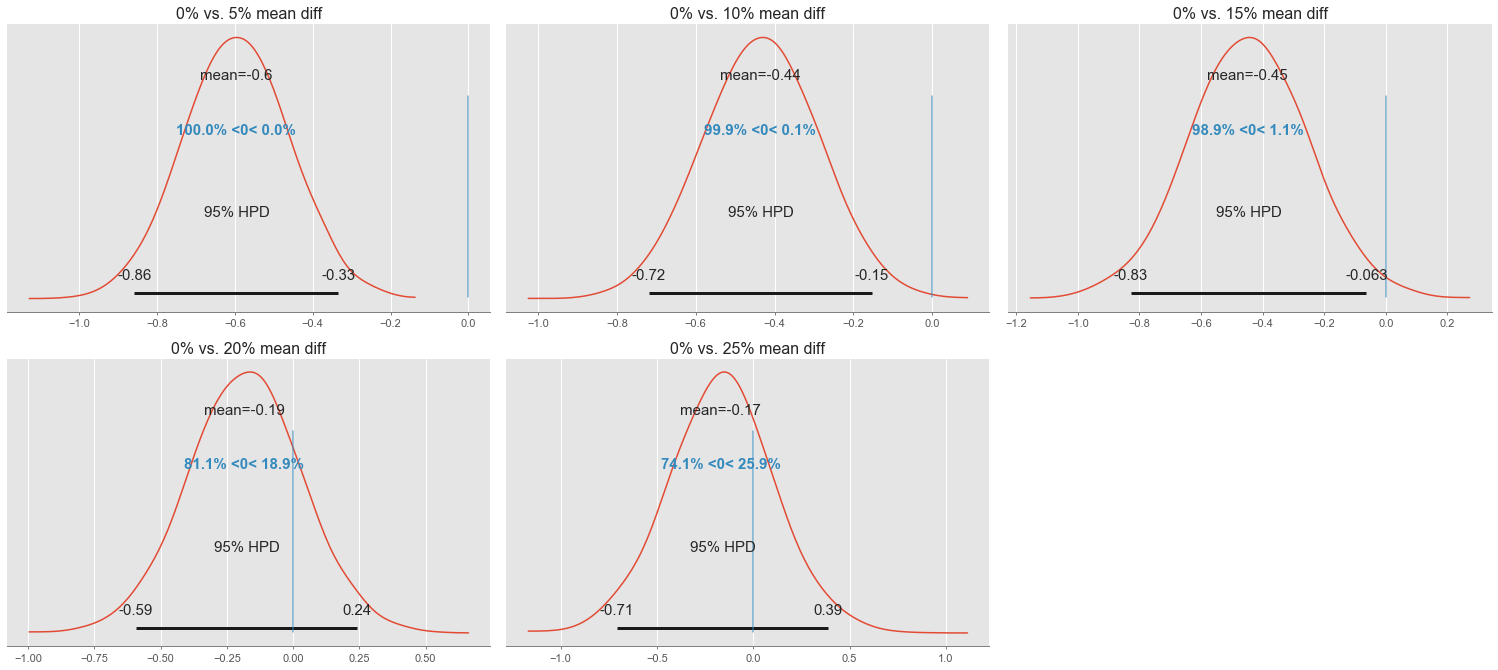

In [97]:
# Lets look first to see if any of the group vs control mean differences have a 95% confidence
# interval that includes zero. If they do, then there is a reason to believe they may not be
# statistically different.
pm.plot_posterior(trace, var_names=['0% vs. 5% mean diff',
                                    '0% vs. 10% mean diff',
                                    '0% vs. 15% mean diff',
                                    '0% vs. 20% mean diff',
                                    '0% vs. 25% mean diff',
                                   ],
                  credible_interval=0.95,
                  ref_val=0.0
                 );

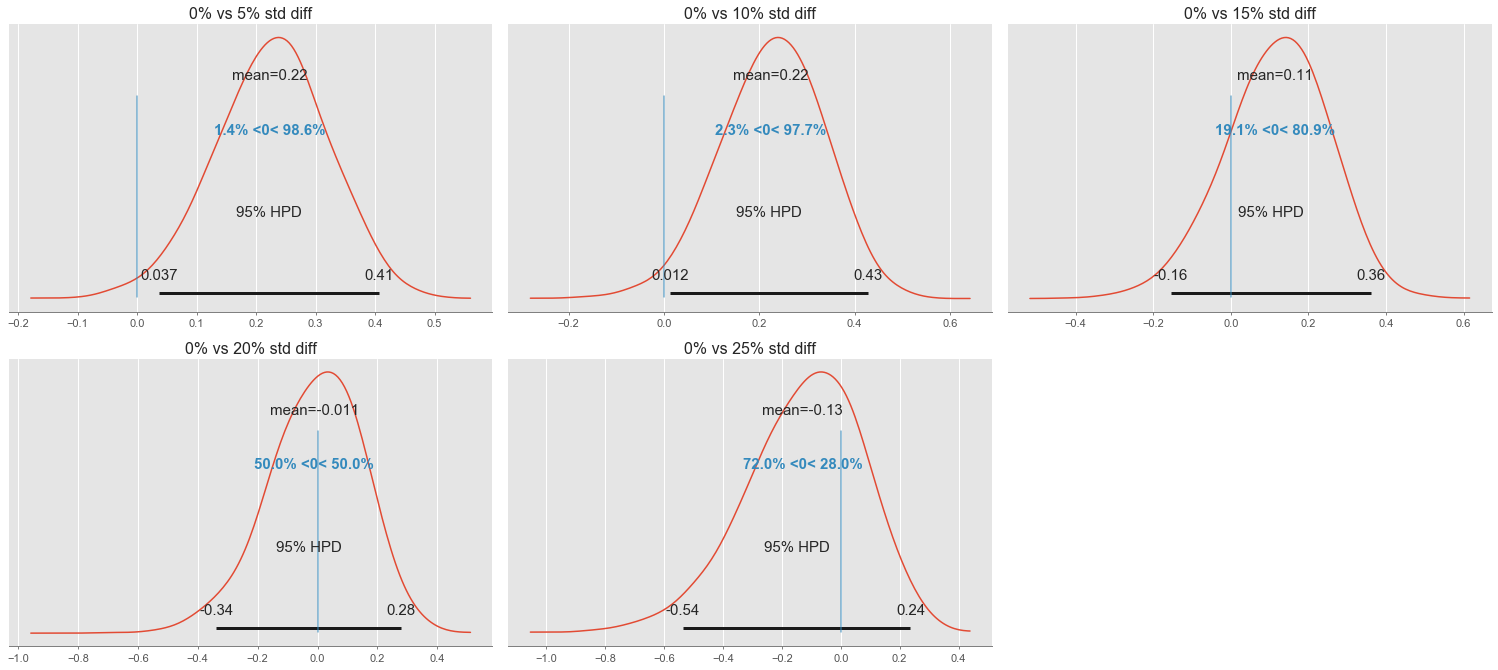

In [98]:
# We can see that the first 3 groups do not include a mean difference of zero within a 95%
# confidences range, but that the last two do, meaning their differences are not significant.
# If we were to multiply the p-value of each by 5 to account for multiple comparison errors,
# then the first three groups are still significant, with the 0.15 group failing to reject.
# Running the test multiple times has revealed that the 0.15 group sometimes reject H0
# This is very much in line with the frequentist testing from earlier, when the more
# conservative tests would leave out the 15% group but the more liberal tests would find it
# significant.

# One of the big advantages of Bayesian MCMC simulation is that we have already compared group
# means, and we can also make a comparison of the stds of the groups as well to see if they
# are in fact different from one another
pm.plot_posterior(trace, 
                  var_names=['0% vs 5% std diff',
                             '0% vs 10% std diff',
                             '0% vs 15% std diff',
                             '0% vs 20% std diff',
                             '0% vs 25% std diff'
                            ],
                  credible_interval=0.95,
                  ref_val=0);

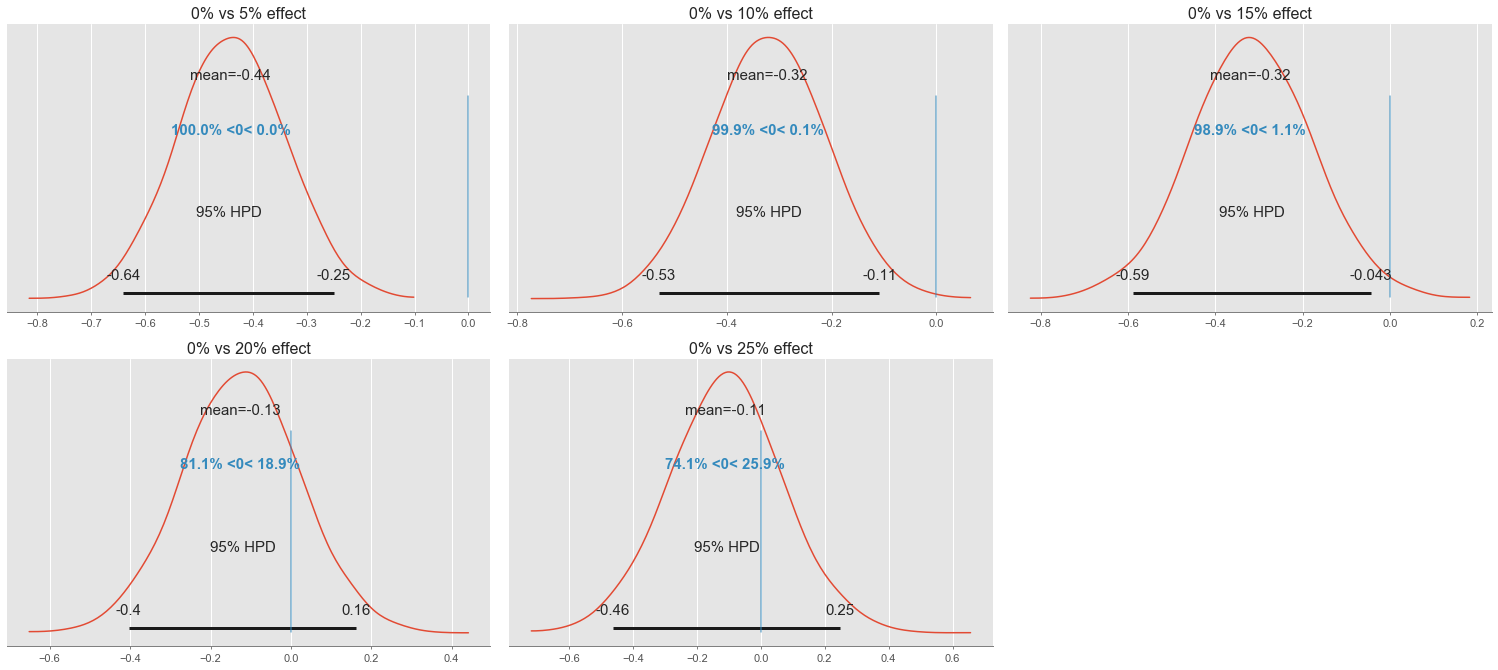

In [100]:
# We can see that despite having failed to reject null hypotheses of homogeneity of variance
# among groups earlier, the MCMC simulation has shown that the variances between the first two
# treatmeant groups and the control may indeed be different. Luckily for Bayesian testing,
# there was no assumption for the equality of variance among groups, so this doesn't even cause
# a problem, since we have determined there are differences among the means and stds. It is
# interesting that though the methods have agreed on mean differences, the bootstrap simulation
# and the MCMC simulation are disagreeing on the homogeneity of variances. It should be noted
# that the MCMC simulation has rejected the null hypothesis of equal variance for the same
# groups which had a null rejection from the F-tests earlier. It is reasonable to assume that
# the first two treatments are having an effect on variance.

# So, now we know that the first 3 treatment groups have statistically different means from
# the control group, but we need to know how large the effects are and whether they are large
# enough to care about. An effect size of .1 or smaller is generally considered small, 
# depending on context. For now I will use this threshold
pm.plot_posterior(trace, 
                  var_names=['0% vs 5% effect',
                             '0% vs 10% effect',
                             '0% vs 15% effect',
                             '0% vs 20% effect',
                             '0% vs 25% effect'
                            ],
                  credible_interval=0.95,
                  ref_val=0);

In [102]:
# As we can see, the effect size for the significant groups is worth reporting, and the effect
# size for the non-significant treatment groups are small, which is part of the reason why they
# are not found to be significantly different.

# This will summarize the findings of our MCMC simulation
pm.summary(trace, 
           var_names=['0% vs. 5% mean diff',
                      '0% vs. 10% mean diff',
                      '0% vs. 15% mean diff',
                      '0% vs. 20% mean diff',
                      '0% vs. 25% mean diff',
                      '0% vs 5% std diff',
                      '0% vs 10% std diff',
                      '0% vs 15% std diff',
                      '0% vs 20% std diff',
                      '0% vs 25% std diff',
                      #'0% vs 5% effect',
                      #'0% vs 10% effect',
                      #'0% vs 15% effect',
                      #'0% vs 20% effect',
                      #'0% vs 25% effect'
                     ],
           credible_interval=0.95)

mean     sd  hpd_2.5%  hpd_97.5%  mcse_mean  mcse_sd  \
0% vs. 5% mean diff  -0.597  0.135    -0.858     -0.334      0.001    0.001   
0% vs. 10% mean diff -0.436  0.145    -0.719     -0.153      0.001    0.001   
0% vs. 15% mean diff -0.449  0.193    -0.829     -0.063      0.002    0.001   
0% vs. 20% mean diff -0.186  0.214    -0.593      0.241      0.002    0.002   
0% vs. 25% mean diff -0.170  0.276    -0.708      0.388      0.002    0.003   
0% vs 5% std diff     0.224  0.095     0.037      0.407      0.001    0.001   
0% vs 10% std diff    0.224  0.109     0.012      0.429      0.001    0.001   
0% vs 15% std diff    0.114  0.135    -0.156      0.361      0.001    0.001   
0% vs 20% std diff   -0.011  0.159    -0.339      0.279      0.001    0.002   
0% vs 25% std diff   -0.130  0.203    -0.535      0.237      0.002    0.002   

                      ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
0% vs. 5% mean diff    14324.0  13419.0   14342.0    6250.0    1.0  
0% vs. 10% mean diff   14523.0  12735.0   14526.0    6002.0    1.0  
0% vs. 15% mean diff   13277.0  10352.0   13295.0    5783.0    1.0  
0% vs. 20% mean diff   14064.0   6490.0   14146.0    5898.0    1.0  
0% vs. 25% mean diff   12854.0   5134.0   13105.0    5584.0    1.0  
0% vs 5% std diff      12785.0  11069.0   12893.0    6300.0    1.0  
0% vs 10% std diff     14080.0  11702.0   14390.0    6131.0    1.0  
0% vs 15% std diff     12163.0   5998.0   12327.0    6301.0    1.0  
0% vs 20% std diff     13405.0   4194.0   14078.0    6229.0    1.0  
0% vs 25% std diff     11356.0   5358.0   11992.0    5999.0    1.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:09<00:00, 1102.52draws/s]


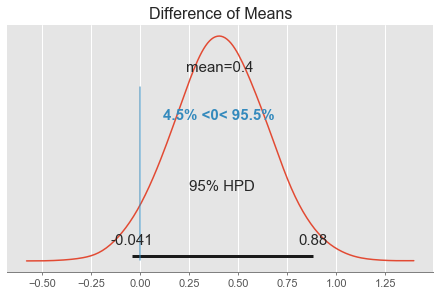

In [261]:
# One more test to compare performance to the hand-written metropolis algorithm above
group1_data = tukey_df[tukey_df.Discount == 0.05].OrderTotal4rt
group2_data = tukey_df[tukey_df.Discount == 0.20].OrderTotal4rt
with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=µ_prior, sd=σ_prior)
    group2_mean = pm.Normal('group2_mean', mu=µ_prior, sd=σ_prior)
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)
    v = pm.Exponential('v_minus_one', 1/29.) + 1
    
    # PyMC3 uses precision rather than std for t-distributions, converting now:
    λ1 = group1_std**-2
    λ2 = group2_std**-2
    
    group1 = pm.StudentT('0.0 Discount', nu=v, mu=group1_mean, lam=λ1, observed=group1_data)
    group2 = pm.StudentT('0.05 Discount', nu=v, mu=group2_mean, lam=λ2, observed=group2_data)
    
    # Setting deterministics:
    diff_of_means = pm.Deterministic('Difference of Means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('Difference of Stds', group1_std - group2_std)
    effect_size = pm.Deterministic('Effect Size', 
                                   diff_of_means/np.sqrt((group1_std**2 + group2_std**2) / 2))
    
    trace = pm.sample(2000)
    
pm.plot_posterior(trace, var_names=['Difference of Means',
                                    #'Difference of Stds',
                                    #'Effect Size'
                                   ],
                  credible_interval=0.95,
                  ref_val=0);

In [115]:
# An important thing to note is that the frequentist approaches, including the t-tests and 
# bootstrap simulation, are testing for the probability of the data given the null hypothesis is
# true (the mean difference is zero), whereas the Bayesian Estimations are determining the
# probability of the null hypothesis given the posterior distribution for the mean differences
# generated through the MCMC simulation. The Bayesian approach is more informative, because it
# gives you an expected distribution for parameters, rather than just a probability to reject
# or accept the null hypothesis. Additionally, the Bayes approach can generate support for the
# null hypothesis, as well as generate evidence against it.

<a id='discount_itemcount'></a>
## Effects of Discount on an Order's Total Item Count:

Showing stats for ItemCount4rt grouped by Discount


Mean    Median       Std  Size
0.00  2.491260  2.432299  0.577794   426
0.05  2.767668  2.828427  0.451830   121
0.10  2.784737  2.783158  0.459296    93
0.15  2.802638  2.861006  0.534320    57
0.20  2.789693  2.710457  0.577668    52
0.25  2.692745  2.723270  0.595351    36

Grouping DataFrame by Discount
Target Features: ItemCount4rt


Showing stats for ItemCount4rt grouped by Discount


Mean    Median       Std  Size
0.00  2.491260  2.432299  0.577794   426
0.05  2.767668  2.828427  0.451830   121
0.10  2.784737  2.783158  0.459296    93
0.15  2.802638  2.861006  0.534320    57
0.20  2.789693  2.710457  0.577668    52
0.25  2.692745  2.723270  0.595351    36

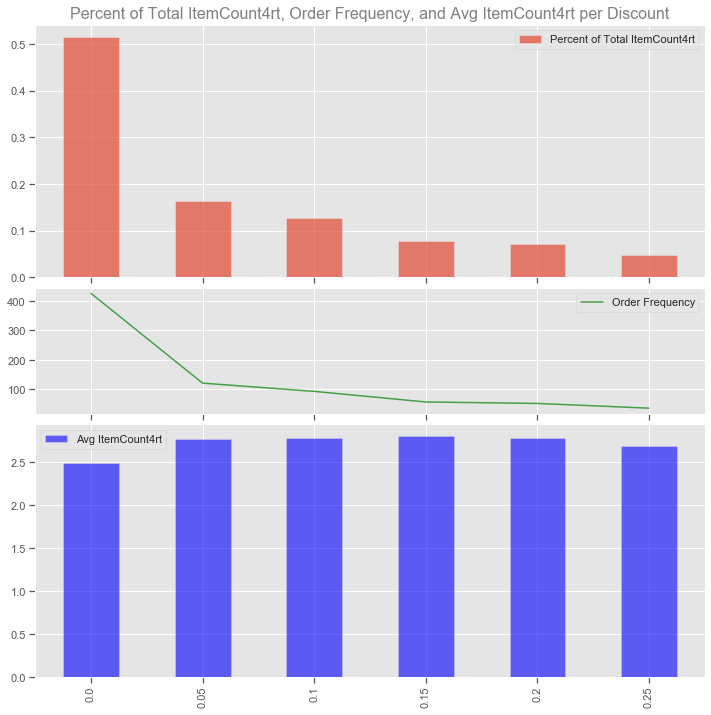

In [103]:
# First, lets look again at the layered histogram for ItemCount4rt
group_hist(tukey_df, 'Discount', 'ItemCount4rt');
mf.ecdf(tukey_df, 'Discount', 'ItemCount4rt')
explore_groups(tukey_df, 'Discount', 'ItemCount4rt');

<a id='frequentist1b'></a>
### Frequentist Approaches

<a id='assumptions1b'></a>
#### Testing for Assumptions:

Checking normality assumptions

Side by side comparison of all group distributions:


Checking normality and visualizing distributions for 0.0 group
Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 0.897377 
 0.995606 
 
 
 p-value 
 0.000000 
 0.277887 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.607084 
 0.78

count    426.000000
mean       2.491260
std        0.577794
min        1.000000
25%        2.114743
50%        2.432299
75%        2.879496
max        4.312896
Name: ItemCount4rt, dtype: float64

Skew: 0.16476050335426984


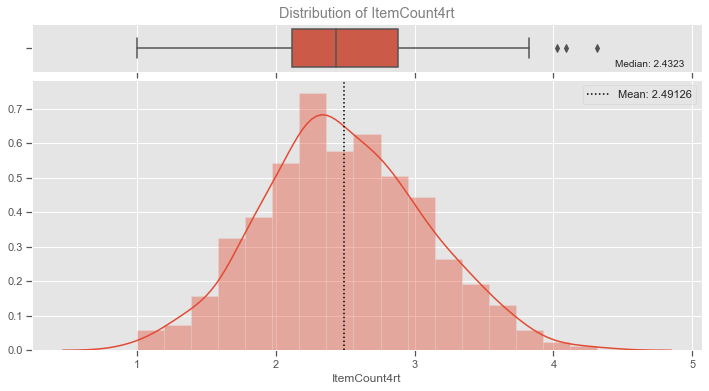

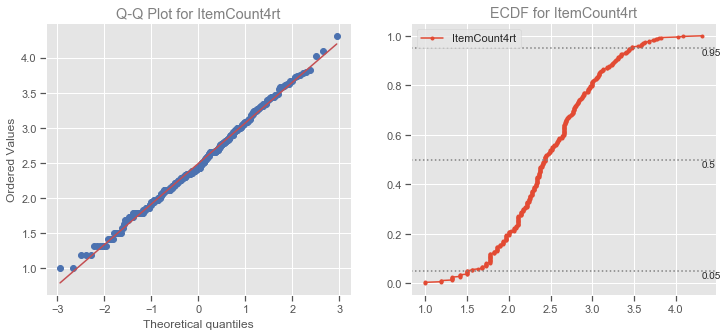

Checking normality and visualizing distributions for 0.05 group
Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 9.623210e-01 
 0.987574 
 
 
 p-value 
 1.021026e-172 
 0.338566 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.468809 
 0.763

count    121.000000
mean       2.767668
std        0.451830
min        1.778279
25%        2.432299
50%        2.828427
75%        2.990698
max        3.996088
Name: ItemCount4rt, dtype: float64

Skew: 0.101743049360305


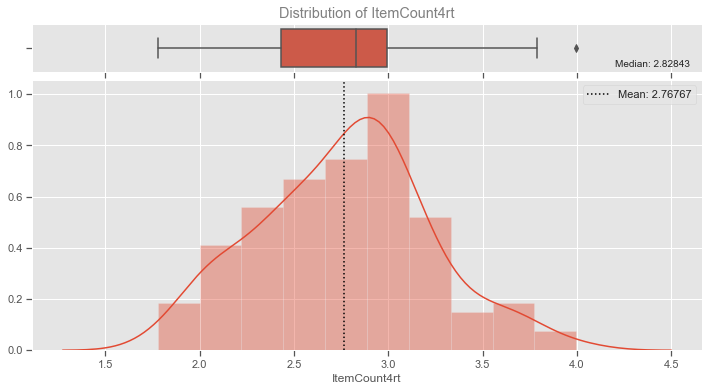

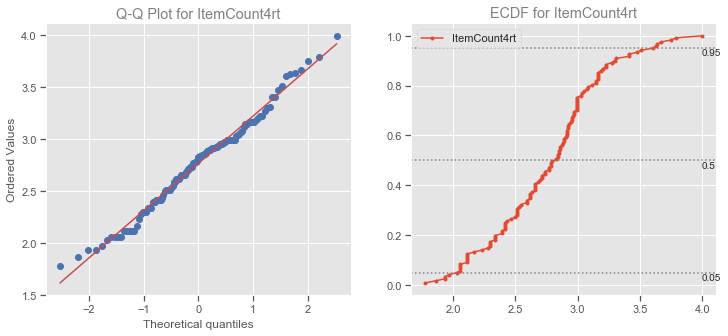

Checking normality and visualizing distributions for 0.1 group
Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 9.604538e-01 
 0.987500 
 
 
 p-value 
 6.788077e-131 
 0.525453 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.275653 
 0.757

count    93.000000
mean      2.784737
std       0.459296
min       1.681793
25%       2.466326
50%       2.783158
75%       3.080070
max       4.000000
Name: ItemCount4rt, dtype: float64

Skew: 0.3205797627736249


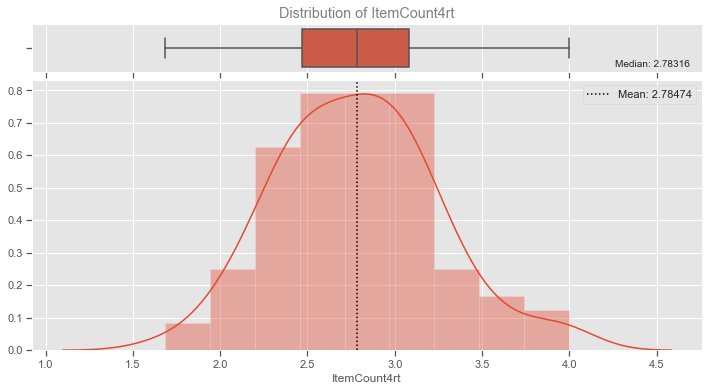

Checking normality and visualizing distributions for 0.15 group
Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 9.301425e-01 
 0.970489 
 
 
 p-value 
 2.637628e-66 
 0.176819 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.426189 
 0.741

count    57.000000
mean      2.802638
std       0.534320
min       1.189207
25%       2.498999
50%       2.861006
75%       3.154342
max       3.940073
Name: ItemCount4rt, dtype: float64

Skew: -0.5372206747921322


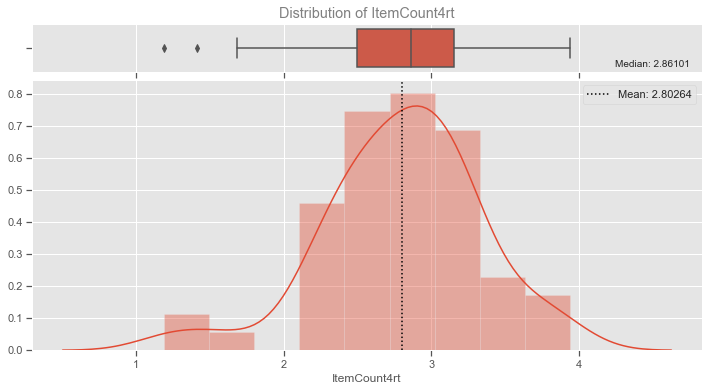

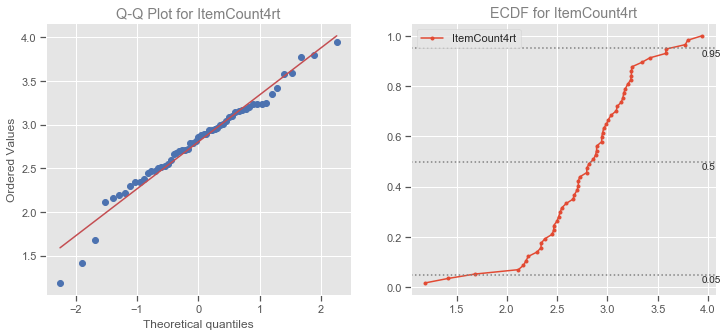

Checking normality and visualizing distributions for 0.2 group
Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 9.430902e-01 
 0.986387 
 
 
 p-value 
 3.721692e-65 
 0.812514 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.284268 
 0.737

count    52.000000
mean      2.789693
std       0.577668
min       1.565085
25%       2.456721
50%       2.710457
75%       3.251116
max       4.119534
Name: ItemCount4rt, dtype: float64

Skew: 0.042517280360286076


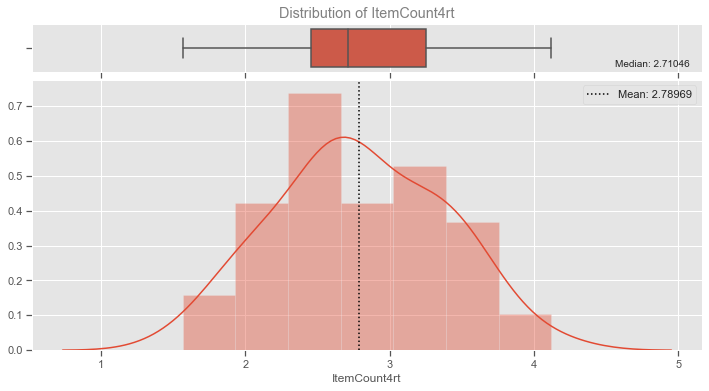

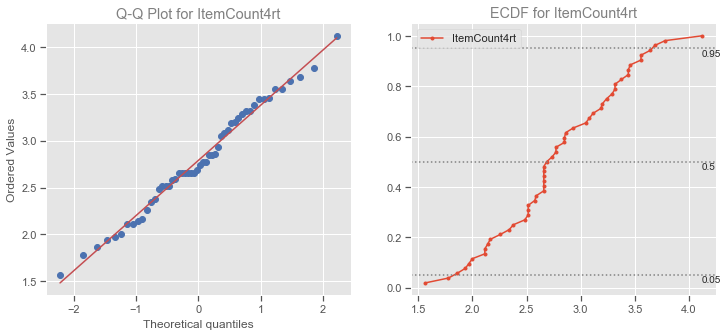

Checking normality and visualizing distributions for 0.25 group
Variable: ItemCount4rt
Normality Test Results for ['ItemCount4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemCount4rt 
 Statistic 
 9.059254e-01 
 0.961467 
 
 
 p-value 
 2.222067e-37 
 0.238482 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemCount4rt 
 0.430856 
 0.721

count    36.000000
mean      2.692745
std       0.595351
min       1.316074
25%       2.368898
50%       2.723270
75%       3.156326
max       3.829214
Name: ItemCount4rt, dtype: float64

Skew: -0.5426229080888368


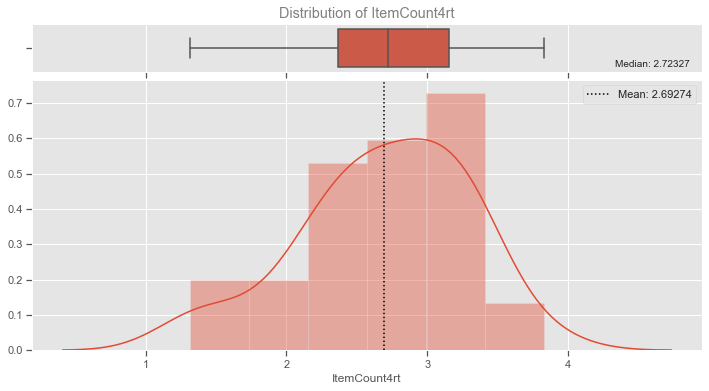

In [104]:
# Before testing, I am going to check for normality of each group:
# Side-by-side boxplot of groups:
fig, ax = plt.subplots(figsize=(12,6))
print("Side by side comparison of all group distributions:")
sns.boxplot(x=tukey_df.Discount, y=tukey_df.ItemCount4rt)
plt.show()

# Visualizing each distribution with Q-Q plots and normality tests
targets = ['ItemCount4rt']
grouped = tukey_df.groupby(['Discount'])[targets]
group_tests1 = {}
group_tests2 = {}

for group in grouped:
    print('Checking normality and visualizing distributions for {} group'.format(group[0]))
    temp_df = pd.DataFrame(group[1])
    temp_df.columns = tukey_df.columns
    res1, res2 = visualize_distribution(temp_df, targets)
    group_tests1[group[0]] = res1
    group_tests2[group[0]] = res2
    
group_tests1 = pd.concat(group_tests1.values(), axis=0, keys=group_tests1.keys())
group_tests2 = pd.concat(group_tests2.values(), axis=0, keys=group_tests2.keys())

In [105]:
# A look at the compiled test results
mf.display_side_by_side(group_tests1, group_tests2, names=names)

K-S and Shapiro-Wilk 
 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 0.00 
 ItemCount4rt 
 Statistic 
 8.973770e-01 
 0.995606 
 
 
 p-value 
 0.000000e+00 
 0.277887 
 
 
 0.05 
 ItemCount4rt 
 Statistic 
 9.623210e-01 
 0.987574 
 
 
 p-value 
 1.021026e-172 
 0.338566 
 
 
 0.10 
 ItemCount4rt 
 Statistic 
 9.604538e-01 
 0.987500 
 
 
 p-value 
 6.788077e-131 
 0.525453 
 
 
 0.15 
 ItemCount4rt 
 Statistic 
 9.301425e-01 
 0.970489 
 
 
 p-value 
 2.637628e-66 
 0.176819 
 
 
 0.20 
 ItemCount4rt 
 Statistic 
 9.430902e-01 
 0.986387 
 
 
 p-value 
 3.721692e-65 
 0.812514 
 
 
 0.25 
 ItemCount4rt 
 Statistic 
 9.059254e-01 
 0.961467 
 
 
 p-value 
 2.222067e-37 
 0.238482 
 
 
 Anderson-Darling 
 
 
 
 
 statistic 
 critical 
 
 
 
 
 0.00 
 ItemCount4rt 
 0.607084 
 0.780 
 
 
 0.05 
 ItemCount4rt 
 0.468809 
 0.763 
 
 
 0.10 
 ItemCount4rt 
 0.275653 
 0.757 
 
 
 0.15 
 ItemCount4rt 
 0.426189 
 0.741 
 
 
 0.20 
 ItemCount4rt 
 0.284268 
 0.737 
 
 
 0.25 
 ItemCount4rt 
 0.430856 
 0.721

In [106]:
# Based on the histograms and Q-Q plots, the distributions appear normal
# This is supported by the fact that the null hypothesis is not rejected in any of the
# Shapiro-Wilk tests or the Anderson-Darling Tests

In [108]:
# Looking at the visualizations above, we can see a possible upward trend in the group means, 
# which may indicate a linear relationship that can be tested for.

Checking for equality of variance

In [128]:
mf.f_test_groups(tukey_df, group_var='Discount', target='ItemCount4rt')

0.00      0.05      0.10      0.15      0.20      0.25
0.00       NaN  0.001492  0.008144  0.477716  1.042170  0.754570
0.05  0.001492       NaN  0.860601  0.129564  0.030395  0.030068
0.10  0.008144  0.860601       NaN  0.196771  0.056406  0.051606
0.15  0.477716  0.129564  0.196771       NaN  0.567359  0.462559
0.20  1.042170  0.030395  0.056406  0.567359       NaN  0.831489
0.25  0.754570  0.030068  0.051606  0.462559  0.831489       NaN

The F-tests are showing that there is significant differences in variances between the control group and both the 0.05 and 0.10 discount groups. I will use a Levene test now.

In [129]:
# First, it appears scipy.stats has a Levene test which has 'median' as the default parameter
# The adjustment to use median instead of mean in the Levene test was originally suggested
# by Brown & Forsythe (1974), so this is also called a Brown & Forsythe test.
# being tested. The null hypothesis of the test is that all the samples/groups come from 
# populations with equal variances. I will reject the null hypothesis at p<0.05
samples = {k: v for k,v in tukey_df.groupby('Discount').ItemCount4rt}
stats.levene(samples[0.0],
             samples[0.05],
             samples[0.1],
             samples[0.15],
             samples[0.20],
             samples[0.25]
            )

LeveneResult(statistic=2.9100618084594956, pvalue=0.013023096985724155)

In [45]:
# We can see that the levene test is rejecting the null hypothesis of homogeneous variances

In [130]:
# Comparison to a bartlett test:
stats.bartlett(samples[0.0],
               samples[0.05],
               samples[0.1],
               samples[0.15],
               samples[0.20],
               samples[0.25]
              )

BartlettResult(statistic=16.20228975338831, pvalue=0.006289643671197703)

In [131]:
# We can see the Bartlett test demonstrating it's higher power with a lower p-value result

In [132]:
# Comparison to non-parametric Fligner-Killeen
stats.fligner(samples[0.0],
              samples[0.05],
              samples[0.1],
              samples[0.15],
              samples[0.20],
              samples[0.25]
             )

FlignerResult(statistic=14.145940918980047, pvalue=0.014708478784702335)

We can see that the Fligner-Killeen and Brown & Forsythe tests have produced nearly identical results, and both reject the null hypothesis that the groups are sampled from distributions with equal variances. This will mean that classic ANOVA must be substituted with Welch's ANOVA since equality of variance assumption is not met. This also means that Tukey's HSD test will be inappropriate as a post-hoc test, because it also assumes equal variance. The most useful test will be the pairwise Welch's t-tests against the control group, with the appropriate p-value adjustment made. First, I will do linear regressions and post-hoc tests.

<a id='linreg1b'></a>
#### Linear Regressions

Linear Regression for ItemCount4rt ~ WeightedDiscount


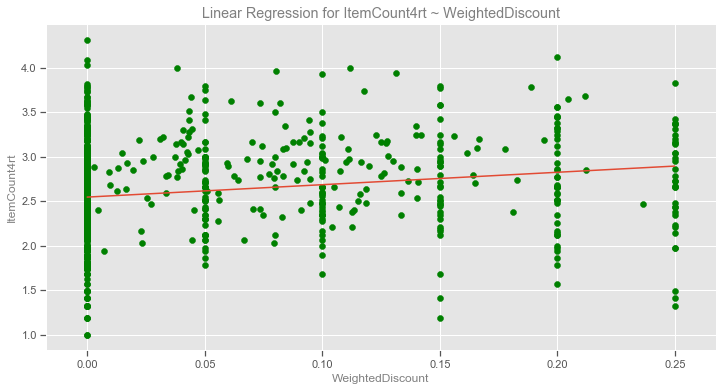

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ItemCount4rt   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     28.42
Date:                Mon, 06 Apr 2020   Prob (F-statistic):           1.28e-07
Time:                        00:00:54   Log-Likelihood:                -646.05
No. Observations:                 785   AIC:                             1296.
Df Residuals:                     783   BIC:                             1305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5449      0.024    105.010      0.000       2.497       2.593
WeightedDiscount     1.3942      0.262      5.331      0.000       0.881       1.908
==============================================================================
Omnibus:                        0.076   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.963   Jarque-Bera (JB):                0.044
Skew:                          -0.018   Prob(JB):                        0.978
Kurtosis:                       3.010   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic     p_value
Goldfeld-Quandt     1.30587  0.00656567

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 1.553987e-01 
 0.998133 
 
 
 p-value 
 5.072888e-17 
 0.555211 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 0.378024 
 0.783

In [133]:
# Performing the linreg with the continuous variable, null hypothesis is that the coefficient
# is zero and there is no linear relationship. Reject null at p-value <0.05
do_a_linreg(tukey_df, 'WeightedDiscount', 'ItemCount4rt')

In [134]:
# Checking for reliability of regression results:
#   -The null hypothesis is not rejected for normality of residuals
#   -The null hypothesis is not rejected that the residuals are homoscedastic
#   -The null hypothesis of the J-B test that skew and kurtosis are non-normal is not rejected

# Establishing that the model is reliable, we can reject the null hypothesis that the 
# coefficient for WeightedDiscount is zero, since it has p-value lower than our alpha of 0.05. 
# This is equal to the p-value from the F-test,
# since only one predictor was used and thus only one coefficient was generated. 

# Using the continuous variable we see a significant linear relationship btwn WeightedDiscount
# and ItemCount4rt. Cross checking this result with a pearson r score.
# Again, rejecting null hypothesis of no linear relationship at p-val <0.05
corr, pval = stats.pearsonr(tukey_df.Discount, tukey_df.ItemCount4rt)
print("Pearson r: {}\np-val: {}".format(corr,pval))

Pearson r: 0.19275965145958868
p-val: 5.232235323491921e-08


Linear Regression for ItemCount4rt ~ WeightedDiscount


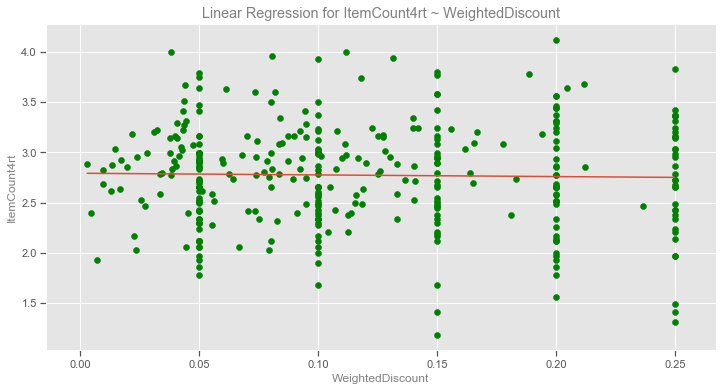

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ItemCount4rt   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1864
Date:                Mon, 06 Apr 2020   Prob (F-statistic):              0.666
Time:                        00:00:58   Log-Likelihood:                -260.23
No. Observations:                 359   AIC:                             524.5
Df Residuals:                     357   BIC:                             532.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.7927      0.052     53.560      0.000       2.690       2.895
WeightedDiscount    -0.1643      0.381     -0.432      0.666      -0.913       0.584
==============================================================================
Omnibus:                        1.094   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.857
Skew:                          -0.089   Prob(JB):                        0.652
Kurtosis:                       3.161   Cond. No.                         14.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic   p_value
Goldfeld-Quandt     1.08163  0.310144

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 1.730944e-01 
 0.996770 
 
 
 p-value 
 7.085407e-10 
 0.693963 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 0.251113 
 0.778

In [135]:
# The null hypothesis that there is no linear relationship has been rejected once again.
# I would like to once again remove the control group to make sure this relationship is not
# just being caused by all of the treatments being higher than the control, and "faking" a 
# linear relationship
do_a_linreg(tukey_df[tukey_df['WeightedDiscount'] > 0], 'WeightedDiscount', 'ItemCount4rt')

In [136]:
# We can see that the null hypothesis that the coefficient is zero is not rejected. The 
# rejected coefficient was near zero anyways, and slightly negative. This means that when the
# control group is not considered, the linear relationship has disappeared. It is not a downward
# trend up the groups as it was with the 'OrderTotal4rt' target, but it does mean that the
# maximum effect has been reached at the lowest levels of discount. This may indicate that,
# once again, it is not necessary to offer a larger discount than 5% to generate the maximum
# effect for this variable.

Linear Regression for ItemCount4rt ~ Discount


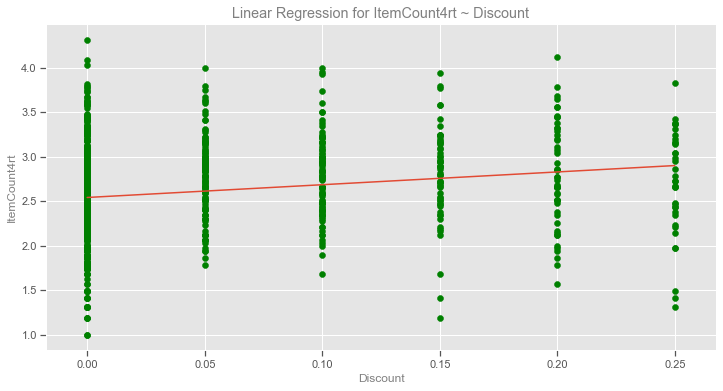

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ItemCount4rt   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     10.66
Date:                Mon, 06 Apr 2020   Prob (F-statistic):           6.42e-10
Time:                        00:00:59   Log-Likelihood:                -634.08
No. Observations:                 785   AIC:                             1280.
Df Residuals:                     779   BIC:                             1308.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.4913      0.026     94.384      0.000       2.439       2.543
Discount[T.0.05]     0.2764      0.056      4.925      0.000       0.166       0.387
Discount[T.0.1]      0.2935      0.062      4.707      0.000       0.171       0.416
Discount[T.0.15]     0.3114      0.077      4.053      0.000       0.161       0.462
Discount[T.0.2]      0.2984      0.080      3.729      0.000       0.141       0.456
Discount[T.0.25]     0.2015      0.095      2.131      0.033       0.016       0.387
==============================================================================
Omnibus:                        0.801   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.670   Jarque-Bera (JB):                0.743
Skew:                           0.075   Prob(JB):                        0.690
Kurtosis:                       3.020   Cond. No.                         5.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic     p_value
Goldfeld-Quandt     1.28837  0.00960319

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 1.616237e-01 
 0.998192 
 
 
 p-value 
 2.202323e-18 
 0.586291 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 0.424855 
 0.783

In [137]:
# Doing a linear regression with the categorical discount variable as predictor
# Null Hypothesis: the coefficients for the groups are zero
# Alternative Hypothesis: at least one group has a significant coefficient
lm = do_a_linreg(tukey_df, 'Discount', 'ItemCount4rt')

In [138]:
# Checking for reliability of regression results:
#   -The null hypothesis is not rejected for normality of residuals
#   -The null hypothesis is not rejected that the residuals are homoscedastic
#   -The null hypothesis of the J-B test that skew and kurtosis are non-normal is not rejected

# Having established a reliable model, we can reject the null hypothesis that the 
# the coefficients are zero, as the F test is significant.
# The null hypothesis of the t-test for a coefficient of zero is rejected for every treatment
# group.
# Using the categorical variable, we see a significant F-statistic for the feature,
# as well as a significant p-values <0.5 for every treatment group. There is no clear upward
# trend among the coefficients, so the idea that a higher discount leads to more overall items
# in the order is not true, so long as you are discussing orders with any discount at all.

<a id='anova1b'></a>
#### ANOVA and Post-Hoc tests

In [139]:
# By generating an ANOVA table from the model, we can see that the F-statistic for the discount
# feature is the same as that for the linear model for that variable as listed above, with the
# same p-value
anova_table = sm.stats.anova_lm(lm, typ=2)
anova_table

sum_sq     df          F        PR(>F)
Discount   15.812045    5.0  10.655238  6.418397e-10
Residual  231.202401  779.0        NaN           NaN

In [141]:
# As mentioned before, the variances are not equal among the group sampling distributions,
# so Welch's ANOVA is the appropriate parametric test:
pi.parametric.welch_anova(data=tukey_df, dv='ItemCount4rt', between='Discount')

Source  ddof1    ddof2       F         p-unc
0  Discount      5  160.133  11.044  3.766966e-09

As we saw from the regression, the F-test shows a very low probability of the data given no distinction between the groups. For pairwise testing, I will start again with Welch's t-tests

In [142]:
# Pairwise Welch's t-test, reject null hypothesis if p<0.05
results = sp.posthoc_ttest(tukey_df, 
                           val_col='ItemCount4rt', 
                           group_col='Discount',
                           equal_var=False,
                           #p_adjust='holm'
                          )
results

0.00          0.05          0.10      0.15      0.20      0.25
0.00 -1.000000e+00  7.076065e-08  3.520579e-07  0.000107  0.000808  0.057548
0.05  7.076065e-08 -1.000000e+00  7.863610e-01  0.670088  0.807357  0.488781
0.10  3.520579e-07  7.863610e-01 -1.000000e+00  0.834202  0.957716  0.407089
0.15  1.073232e-04  6.700875e-01  8.342020e-01 -1.000000  0.903846  0.370395
0.20  8.080977e-04  8.073565e-01  9.577157e-01  0.903846 -1.000000  0.449541
0.25  5.754841e-02  4.887811e-01  4.070890e-01  0.370395  0.449541 -1.000000

The t-tests show that all treatments except the 0.25 group compared with the control are significant with an alpha = 0.05. The use of a one-tail test for these effects might be argued by some. However, I believe it is difficult to justify the use of a one-tail test even if the researcher is only interested in movements in one direction, because if one is really testing the probability of an effect size given a null hypothesis, then seemingly by definition that would include the probability of an opposite effect of equal size as well. The 0.25 group has a relatively small effect size in addition to a small sample size which reduces the power of the test, making the detection of a significant effect less likely. This may be ameliorated by using the pooled variance among the groups, as this could effectively reduce the sampling error of the variance estimate for the 0.25 group.

In [156]:
# Pairwise student's t-test with pooled_sd
results = sp.posthoc_ttest(tukey_df, 
                           val_col='ItemCount4rt', 
                           group_col='Discount',
                           pool_sd=True,
                           #p_adjust='holm'
                          )
results

0.00      0.05      0.10      0.15      0.20      0.25
0.00 -1.000000  0.000001  0.000003  0.000056  0.000206  0.033415
0.05  0.000001 -1.000000  0.820321  0.689587  0.807437  0.469036
0.10  0.000003  0.820321 -1.000000  0.845188  0.958119  0.389918
0.15  0.000056  0.689587  0.845188 -1.000000  0.901422  0.343668
0.20  0.000206  0.807437  0.958119  0.901422 -1.000000  0.412027
0.25  0.033415  0.469036  0.389918  0.343668  0.412027 -1.000000

In [157]:
# Again, pooling the variance has reduced the dynamics of the p-values, but not adjustment
# has been made because too many comparisons are being made for our purpose

In [158]:
# Since we have concluded the variances are not equal among groups, the Scheffe test is
# inappropriate as it makes this assumption.
results = sp.posthoc_scheffe(tukey_df,
                             val_col='ItemCount4rt',
                             group_col='Discount2',
                             #p_adjust='bonferroni'
                            )
results

0.0      0.05      0.10      0.15      0.20      0.25
0.0  -1.000000  0.000224  0.000551  0.006079  0.016859  0.475082
0.05  0.000224 -1.000000  0.999968  0.999486  0.999955  0.991156
0.10  0.000551  0.999968 -1.000000  0.999985  1.000000  0.980637
0.15  0.006079  0.999486  0.999985 -1.000000  0.999998  0.970294
0.20  0.016859  0.999955  1.000000  0.999998 -1.000000  0.984330
0.25  0.475082  0.991156  0.980637  0.970294  0.984330 -1.000000

In [159]:
# Comparing above test to another post-hoc test which does not assume equal pop variances
# Note that a p-value adjustment is implicit in a Tamhane T2 test
results = sp.posthoc_tamhane(tukey_df,
                             val_col='ItemCount4rt',
                             group_col='Discount2',
                             welch=True, # makes this a Tamhane T2 test
                             sort=True)
results

0.0          0.05      0.10      0.15      0.20      0.25
0.0  -1.000000e+00  4.245638e-07  0.000002  0.000644  0.004839  0.299264
0.05  4.245638e-07 -1.000000e+00  0.999905  0.998711  0.999949  0.982150
0.10  2.112346e-06  9.999049e-01 -1.000000  0.999979  1.000000  0.956555
0.15  6.437664e-04  9.987106e-01  0.999979 -1.000000  0.999999  0.937712
0.20  4.838802e-03  9.999489e-01  1.000000  0.999999 -1.000000  0.972180
0.25  2.992642e-01  9.821499e-01  0.956555  0.937712  0.972180 -1.000000

#### Kurskal-Wallis and Dunn's Test

In [149]:
# Testing a non-parametric alternative to ANOVA
stats.kruskal(tukey_df.Discount, tukey_df.ItemCount4rt)

KruskalResult(statistic=1201.7125908342377, pvalue=2.5888422740776752e-263)

In [150]:
# Following up with Dunn's pairwise ranked sum comparison
results = sp.posthoc_dunn(tukey_df, 
                          val_col='ItemCount4rt', 
                          group_col='Discount2',
                          #p_adjust='bonferroni',
                          sort=True)
results

0.0          0.05      0.10      0.15      0.20      0.25
0.0  -1.000000e+00  7.762369e-07  0.000004  0.000019  0.000475  0.014339
0.05  7.762369e-07 -1.000000e+00  0.890911  0.554827  0.979442  0.658098
0.10  3.977816e-06  8.909113e-01 -1.000000  0.651597  0.932618  0.600023
0.15  1.853966e-05  5.548266e-01  0.651597 -1.000000  0.636616  0.400752
0.20  4.753684e-04  9.794417e-01  0.932618  0.636616 -1.000000  0.683856
0.25  1.433937e-02  6.580978e-01  0.600023  0.400752  0.683856 -1.000000

In [306]:
# Following up with Dunn's pairwise ranked sum comparison on the non-transformed variable
results = sp.posthoc_dunn(tukey_df, 
                          val_col='ItemCount', 
                          group_col='Discount2',
                          #p_adjust='bonferroni',
                          sort=True)
results

0.0          0.05      0.10      0.15      0.20      0.25
0.0  -1.000000e+00  7.762369e-07  0.000004  0.000019  0.000475  0.014339
0.05  7.762369e-07 -1.000000e+00  0.890911  0.554827  0.979442  0.658098
0.10  3.977816e-06  8.909113e-01 -1.000000  0.651597  0.932618  0.600023
0.15  1.853966e-05  5.548266e-01  0.651597 -1.000000  0.636616  0.400752
0.20  4.753684e-04  9.794417e-01  0.932618  0.636616 -1.000000  0.683856
0.25  1.433937e-02  6.580978e-01  0.600023  0.400752  0.683856 -1.000000

Again, the Dunn's test has produced p-values similar to the t-tests, but again has drastically reduced the p-values for the 0.20 and 0.25 groups, making all 5 treatment group effects significant.

<a id='ttest1b'></a>
#### t-tests

In [151]:
# Looking at t-tests for effects with a significance threshold of alpha = 0.05
targets = ['ItemCount4rt']
compare_groups(tukey_df, 'Discount', targets, 0.0, p_adjust=True)

Testing Discount groups for statistically significant effects on ItemCount4rt


0.05       0.10       0.15       0.20       0.25
p-val        3.538032e-07   0.000002   0.000537   0.004040   0.287742
effect size  5.002585e-01   0.525428   0.543509   0.516516   0.347899
size         1.210000e+02  93.000000  57.000000  52.000000  36.000000
power        9.722867e-01   0.945667   0.820328   0.741798   0.307384

In [152]:
# As we can see, after adjusting p-values for the multiple group comparisons to have an overall
# alpha of 0.05, every group except the 0.25 group is significantly different from the control.
# The effect size is largest for the 0.15 group, and much smaller for the 0.25 group. It looks
# as though the most effective discount for liquidating inventory is 0.15.

<a id='bootstrap1b'></a>
#### Bootstrap Simulation

In [153]:
# Bootstrap comparison of each group against control, p-values adjusted for k-1 comparisons
boot_results = bootstrap_sim(tukey_df,
                             feature='Discount',
                             target='ItemCount4rt',
                             control_groups=0.0,
                             num_trials=20000,
                             show_hist=True,
                             p_adjust=True
                            )
boot_results

Performing bootstrap simulation for parameter: mean
Testing control group: 0.0


p-values adjusted for 5 group comparisons


0.05  0.10     0.15   0.20     0.25
p_val to 0.0   0.0   0.0  0.00025  0.002  0.23125

In [ ]:
# We can see that the bootstrap simulation has produced values very similar to the t-tests, with
# the same conclusions.

In [155]:
# Performing a pairwise test on all groups. Though I am only interested in the comparisons of
# each group to the control group, I do wish to compare the test results to the post-hoc tests
boot_results = bootstrap_sim(tukey_df,
                             feature='Discount',
                             target='ItemCount4rt',
                             num_trials=20000,
                             p_adjust=False
                            )
boot_results

Performing bootstrap simulation for parameter: mean
Testing control group: 0.0
Testing control group: 0.05
Testing control group: 0.1
Testing control group: 0.15
Testing control group: 0.2
Testing control group: 0.25



0.05    0.10     0.15    0.20     0.25
p_val to 0.0    0.0  0.0000  0.00015  0.0004  0.04460
p_val to 0.05   NaN  0.7867  0.64415  0.7917  0.41605
p_val to 0.1    NaN     NaN  0.82650  0.9545  0.34965
p_val to 0.15   NaN     NaN      NaN  0.9046  0.35205
p_val to 0.2    NaN     NaN      NaN     NaN  0.43860

In [ ]:
# One of the interesting things to note from the post-hoc tests here is that the treatment
# groups appear to be mostly different from the control group, but not from one another. This 
# may be an indication that higher average discount levels in an order do not improve the size
# of the orders, once considering that any discount has been applied. This fits into what we
# observed earlier with OrderTotal4rt, in which case lower discounts were the most profitable.

Performing bootstrap simulation for parameter: std
Testing control group: 0.0
Testing control group: 0.05
Testing control group: 0.1
Testing control group: 0.15
Testing control group: 0.2
Testing control group: 0.25


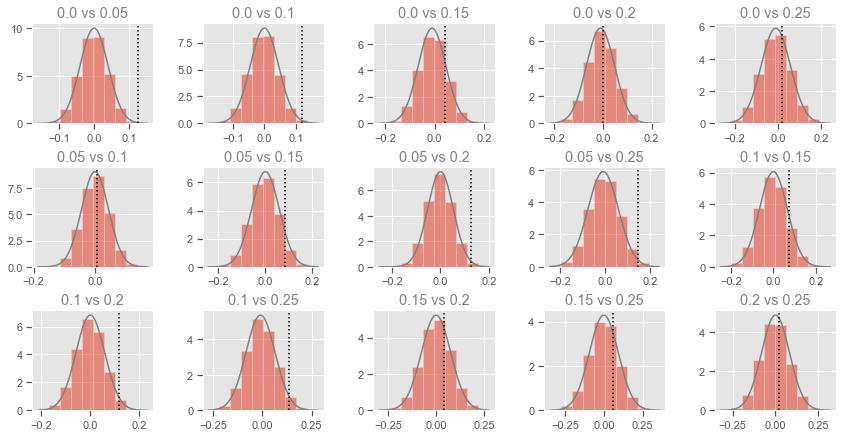

0.05     0.10     0.15     0.20     0.25
p_val to 0.0   0.0015  0.00835  0.44210  0.99825  0.79635
p_val to 0.05     NaN  0.86500  0.16095  0.01860  0.03490
p_val to 0.1      NaN      NaN  0.25505  0.04420  0.06725
p_val to 0.15     NaN      NaN      NaN  0.57610  0.51485
p_val to 0.2      NaN      NaN      NaN      NaN  0.83210

In [166]:
# Using the bootstrap to check for differences in std:
boot_results = bootstrap_sim(tukey_df,
                             feature='Discount',
                             target='ItemCount4rt',
                             num_trials=20000,
                             param='std',
                             show_hist=True,
                             p_adjust=False
                            )
boot_results

Performing bootstrap simulation for parameter: median
Testing control group: 0.0


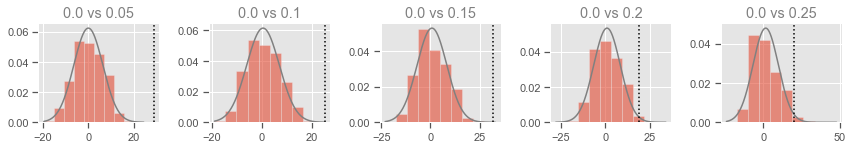

p-values adjusted for 5 group comparisons


0.05     0.10     0.15     0.20     0.25
p_val to 0.0   0.0  0.00025  0.00075  0.03775  0.10775

In [169]:
# I would like to do a bootstrap simulation on the median parameter on the non-transformed data
boot_results = bootstrap_sim(tukey_df,
                             feature='Discount',
                             target='ItemCount',
                             control_groups=0.0,
                             num_trials=20000,
                             param='median',
                             show_hist=True,
                             p_adjust=True
                            )
boot_results

In [ ]:
# Using the bootstrap approach on the untransformed data has reached the same conclusions.

<a id='bayesian1b'></a>
### Bayesian Approach

<a id='best1b'></a>
#### Bayes Estimation

In [160]:
# I will now use pymc3 to compare each treatment group to the control group, and see the
# probabilities that it will generate for the null hypothesis in each comparison.

# Again, I will use the values from the whole dataset to form uninformed priors
σ_prior = tukey_df.ItemCount4rt.std() * 2
µ_prior = tukey_df.ItemCount4rt.mean()
σ_low = 0
σ_high = 10

#Setting target data
control_data = tukey_df[tukey_df.Discount == 0.0].ItemCount4rt
discount5_data = tukey_df[tukey_df.Discount == 0.05].ItemCount4rt
discount10_data = tukey_df[tukey_df.Discount == 0.1].ItemCount4rt
discount15_data = tukey_df[tukey_df.Discount == 0.15].ItemCount4rt
discount20_data = tukey_df[tukey_df.Discount == 0.2].ItemCount4rt
discount25_data = tukey_df[tukey_df.Discount == 0.25].ItemCount4rt

# Now to establish the statistical model with distributions for variables
with pm.Model() as model:
    # Modeling means
    control_mean = pm.Normal('Control mean', mu=µ_prior, sd=σ_prior)
    discount5_mean = pm.Normal('0.05 Discount mean', mu=µ_prior, sd=σ_prior)
    discount10_mean = pm.Normal('0.10 Discount mean', mu=µ_prior, sd=σ_prior)
    discount15_mean = pm.Normal('0.15 Discount mean', mu=µ_prior, sd=σ_prior)
    discount20_mean = pm.Normal('0.20 Discount mean', mu=µ_prior, sd=σ_prior)
    discount25_mean = pm.Normal('0.25 Discount mean', mu=µ_prior, sd=σ_prior)
    # Modeling stds
    control_std = pm.Uniform('Control std', lower=σ_low, upper=σ_high)
    discount5_std = pm.Uniform('0.05 Discount std', lower=σ_low, upper=σ_high)
    discount10_std = pm.Uniform('0.10 Discount std', lower=σ_low, upper=σ_high)
    discount15_std = pm.Uniform('0.15 Discount std', lower=σ_low, upper=σ_high)
    discount20_std = pm.Uniform('0.20 Discount std', lower=σ_low, upper=σ_high)
    discount25_std = pm.Uniform('0.25 Discount std', lower=σ_low, upper=σ_high)
    # Modeling v
    v = pm.Exponential('v_minus_one', 1/29.) + 1
    
    # PyMC3 uses precision rather than std for t-distributions, converting now:
    λ0 = control_std**-2
    λ1 = discount5_std**-2
    λ2 = discount10_std**-2
    λ3 = discount15_std**-2
    λ4 = discount20_std**-2
    λ5 = discount25_std**-2
    
    # Setting posteriors
    control = pm.StudentT('0.0 Discount', nu=v, mu=control_mean, lam=λ0, observed=control_data)
    discount5 = pm.StudentT('0.05 Discount', nu=v, mu=discount5_mean, lam=λ1, observed=discount5_data)
    discount10 = pm.StudentT('0.10 Discount', nu=v, mu=discount10_mean, lam=λ2, observed=discount10_data)
    discount15 = pm.StudentT('0.15 Discount', nu=v, mu=discount15_mean, lam=λ3, observed=discount15_data)
    discount20 = pm.StudentT('0.20 Discount', nu=v, mu=discount20_mean, lam=λ4, observed=discount20_data)
    discount25 = pm.StudentT('0.25 Discount', nu=v, mu=discount25_mean, lam=λ5, observed=discount25_data)
    
    # Setting deterministics:
    mean_diffs_5 = pm.Deterministic('0.05 Mean diffs', discount5_mean - control_mean)
    mean_diffs_10 = pm.Deterministic('0.10 Mean diffs', discount10_mean - control_mean)
    mean_diffs_15 = pm.Deterministic('0.15 Mean diffs', discount15_mean - control_mean)
    mean_diffs_20 = pm.Deterministic('0.20 Mean diffs', discount20_mean - control_mean)
    mean_diffs_25 = pm.Deterministic('0.25 Mean diffs', discount25_mean - control_mean)
    
    # std differences
    control_v_5_stds = pm.Deterministic('0% vs 5% std diff', discount5_std - control_std)
    control_v_10_stds = pm.Deterministic('0% vs 10% std diff', discount10_std - control_std)
    control_v_15_stds = pm.Deterministic('0% vs 15% std diff', discount15_std - control_std)
    control_v_20_stds = pm.Deterministic('0% vs 20% std diff', discount20_std - control_std)
    control_v_25_stds = pm.Deterministic('0% vs 25% std diff', discount25_std - control_std)
    # effect sizes
    control_v_5_effect = pm.Deterministic('0% vs 5% effect', 
                                   mean_diffs_5/np.sqrt((control_std**2+discount5_std**2)/2))
    control_v_10_effect = pm.Deterministic('0% vs 10% effect', 
                                   mean_diffs_10/np.sqrt((control_std**2+discount10_std**2)/2))
    control_v_15_effect = pm.Deterministic('0% vs 15% effect', 
                                   mean_diffs_15/np.sqrt((control_std**2+discount15_std**2)/2))
    control_v_20_effect = pm.Deterministic('0% vs 20% effect', 
                                   mean_diffs_20/np.sqrt((control_std**2+discount20_std**2)/2))
    control_v_25_effect = pm.Deterministic('0% vs 25% effect', 
                                   mean_diffs_25/np.sqrt((control_std**2+discount25_std**2)/2))

In [161]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_minus_one, 0.25 Discount std, 0.20 Discount std, 0.15 Discount std, 0.10 Discount std, 0.05 Discount std, Control std, 0.25 Discount mean, 0.20 Discount mean, 0.15 Discount mean, 0.10 Discount mean, 0.05 Discount mean, Control mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:14<00:00, 713.22draws/s]


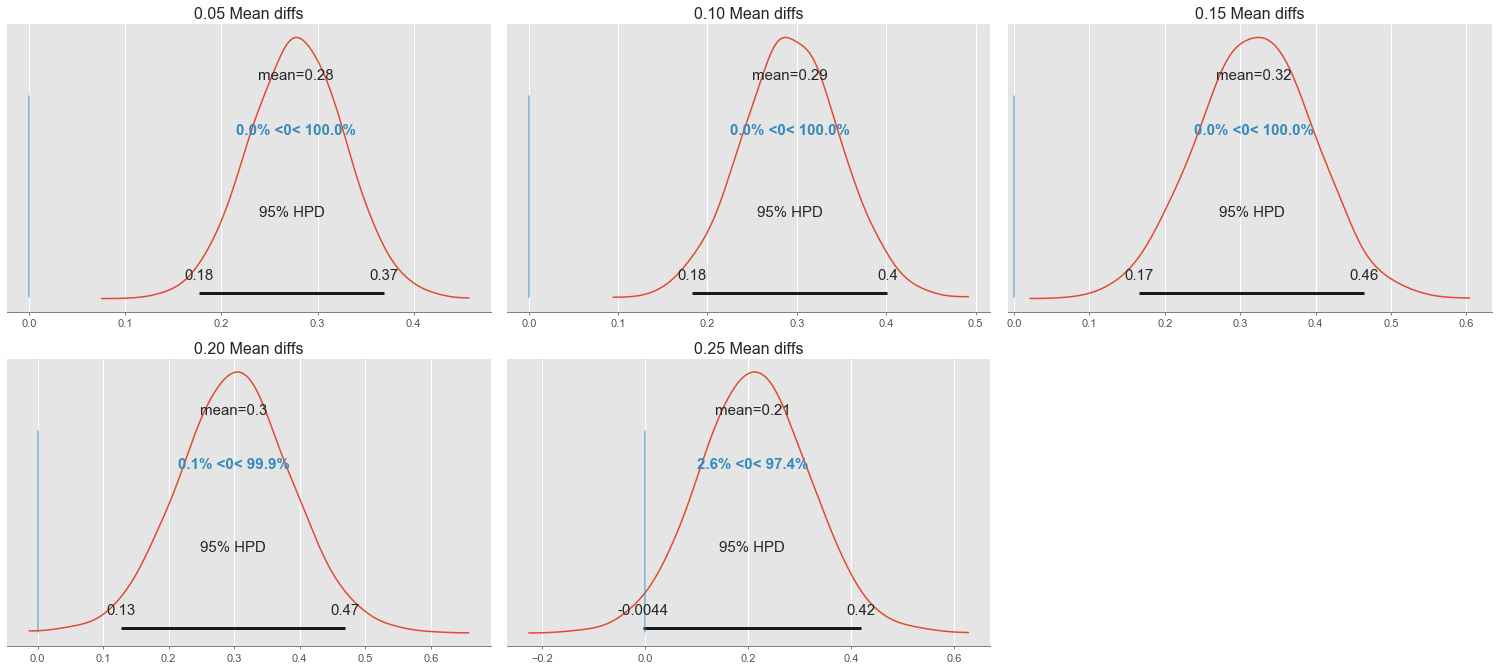

In [162]:
# Graphing the posteriors for variables
pm.plot_posterior(trace, var_names=['0.05 Mean diffs',
                                    '0.10 Mean diffs',
                                    '0.15 Mean diffs',
                                    '0.20 Mean diffs',
                                    '0.25 Mean diffs'
                                   ],
                 ref_val=0,
                 credible_interval=0.95);

Here we can see once again that the mean differences vs control of the first 4 groups are definitely significant, with the 0.25 discount group straddling the line, in this case having a p-value of exactly 0.05.

In [163]:
# Graphing the posteriors for std differences
pm.plot_posterior(trace, var_names=['0% vs 5% std diff',
                                    '0% vs 10% std diff',
                                    '0% vs 15% std diff',
                                    '0% vs 20% std diff',
                                    '0% vs 25% std diff'
                                   ],
                 ref_val=0,
                 credible_interval=0.95);

In [ ]:
# Here we can see variance relationships much in line with the bootstrap simulation, with the 
# first two groups compared to control having significant differences in their variances.

Next, I will look at the mean effect sizes from the MCMC simulation. While rules of thumb are usually not recommended, it is useful to keep in mind that, according to [Ian Walker](https://people.bath.ac.uk/pssiw/stats2/page2/page14/page14.html), "Cohen suggested that d=0.2 be considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. This means that if two groups' means don't differ by 0.2 standard deviations or more, the difference is trivial, even if it is statistically signficant."

In [168]:
# Looking at the mean effect sizes for each group. 
pm.summary(trace, var_names=['0% vs 5% effect',
                             '0% vs 10% effect',
                             '0% vs 15% effect',
                             '0% vs 20% effect',
                             '0% vs 25% effect',
                            ],
           credible_interval=0.95
          )

mean     sd  hpd_2.5%  hpd_97.5%  mcse_mean  mcse_sd  \
0% vs 5% effect   0.545  0.098     0.349      0.735      0.001    0.001   
0% vs 10% effect  0.570  0.111     0.354      0.790      0.001    0.001   
0% vs 15% effect  0.583  0.144     0.301      0.865      0.001    0.001   
0% vs 20% effect  0.522  0.154     0.214      0.813      0.001    0.001   
0% vs 25% effect  0.359  0.184    -0.006      0.712      0.002    0.001   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
0% vs 5% effect    15627.0  14620.0   15610.0    5810.0    1.0  
0% vs 10% effect   14107.0  13609.0   14152.0    6367.0    1.0  
0% vs 15% effect   15706.0  13946.0   15752.0    6034.0    1.0  
0% vs 20% effect   13840.0  12693.0   13901.0    5740.0    1.0  
0% vs 25% effect   13497.0  11083.0   13486.0    6775.0    1.0

In [ ]:
# We can see that all of the significant effects are considerably large. Even the 0.25 group had
# an effect which can be considered not small, but it was not found to be significant in our
# tests.

<a id='conclusions1'></a>
### Conclusions from Part 1

We can see in the first tests that there is a significant positive effect on OrderTotal4rt at the 0.05 and 0.10 discount levels, as confirmed through multiple approaches. When not considering orders without a discount, a significant negative linear relationship was detected between the continuous WeightedDiscount variable and OrderTotal4rt, following intuition, which would state that larger discounts would lead to lower sales totals. The effect on OrderTotal4rt was therefore greatest at the lower discount levels, meaning that the 0.05 discount group was more profitable than the 0.10 discount group.

The effect of every discount group other than 0.25 on ItemCount4rt is significant according to pairwise Welch's t-tests, bootstrap simulation, and Bayesian estimation. A bootstrap simulation comparing medians with the nontransformed data also revealed the same result. The means of the groups were not statistically different from one another, though the largest measured effect size on Item Count belonged to the 0.15 discount group. No significant linear relationship was detected between WeightedDiscount and ItemCount4rt when non-discounted orders were ignored, meaning that larger discounts did not tend to increase or descrease the number of items in an order once any discount had been applied.

So far, we saw that applying a discount did have a statistically significant impact on Order Total, and that the 0.05 discount group generated the highest Order Totals, with diminishing returns at higher discount levels. We then saw that applying a discount has a statistically significant effect on the number of items in an order, but that no statistically significant trend was detected to indicate that more or less items will be ordered as the discount amount is increased. Pairing these two insights, we can assume that offering a discount of around 5% is enough to generate the most favorable combination of profit and inventory liquidity.

<a id='data_wrangling2'></a>
# Data Wrangling 2: DataFrame by Item

I will now look at how the effect of discount amount changes when looking at the number of specific items in the orders, rather than just at the total number of items in the order as we have done so far.

In [7]:
# First I will need to make a new dataframe that isn't grouped by OrderId.
# I will keep this one simpler, specific to this question
cur.execute('''SELECT o.Id AS OrderID,
                      od.ProductID,
                      od.UnitPrice,
                      od.Quantity AS ItemQuantity,
                      od.Discount
                      FROM "Order" o
                      JOIN OrderDetail od 
                      ON o.Id = od.OrderID
                      ORDER BY 1;''')
df2 = pd.DataFrame(cur.fetchall())
df2.columns = [x[0] for x in cur.description]
df2.head()

OrderID  ProductId  UnitPrice  ItemQuantity  Discount
0    10248         11       14.0            12       0.0
1    10248         42        9.8            10       0.0
2    10248         72       34.8             5       0.0
3    10249         14       18.6             9       0.0
4    10249         51       42.4            40       0.0

In [8]:
# Checking for missing values (there are none since the SQL columns were not nullable)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
OrderID         2155 non-null int64
ProductId       2155 non-null int64
UnitPrice       2155 non-null float64
ItemQuantity    2155 non-null int64
Discount        2155 non-null float64
dtypes: float64(2), int64(3)
memory usage: 84.3 KB


Variable: ItemQuantity
Normality Test Results for ['ItemQuantity']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity 
 Statistic 
 0.969361 
 8.515490e-01 
 
 
 p-value 
 0.000000 
 5.022954e-41 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity 
 74.189275 
 0.786

count    2155.000000
mean       23.812993
std        19.022047
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       130.000000
Name: ItemQuantity, dtype: float64

Skew: 1.7812377305504614


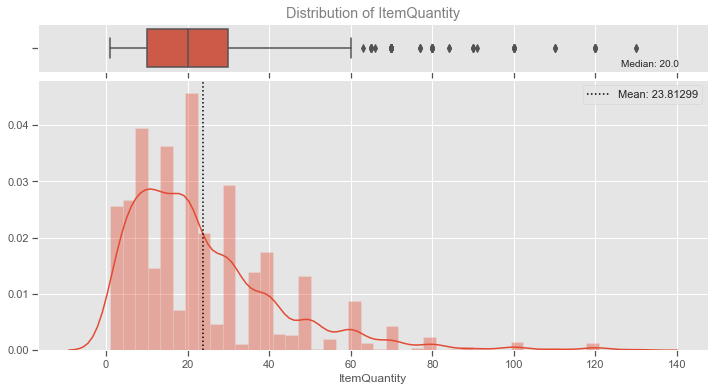

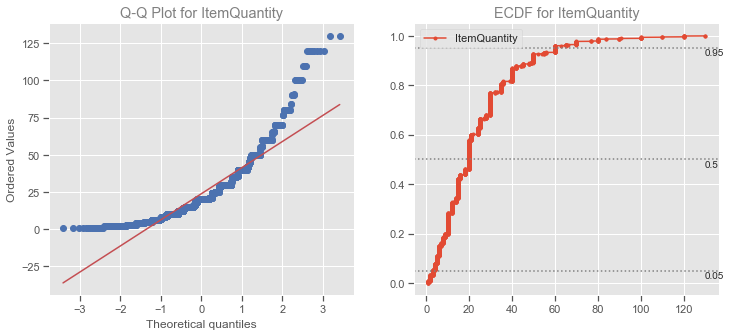

In [172]:
# A look at the distribution of ItemQuantity
visualize_distribution(df2, ['ItemQuantity']);

Again we see a positively skewed distribution with outliers on the high side.

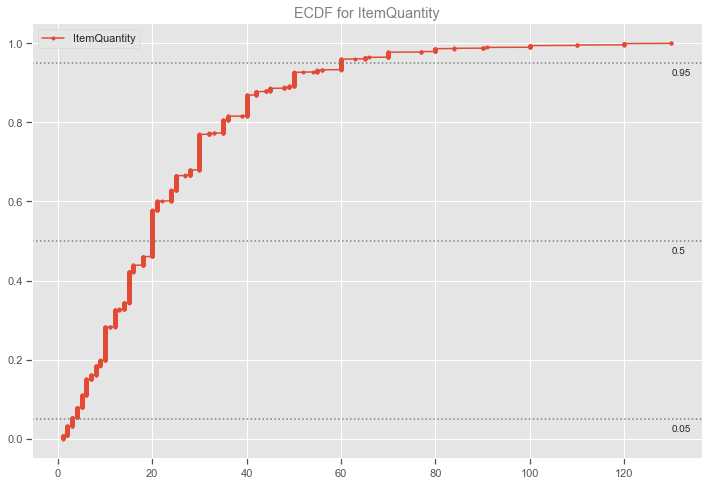

In [175]:
mf.ecdf(df2.ItemQuantity)

<a id='transform2'></a>
# Transformation and Trimming: DataFrame 2

In [176]:
# Making Discount groups with 5% increments:
df2['DiscountGroup'] = pd.cut(x = df2.Discount,
                              bins = [-1, 0, 0.075, 0.125, 0.175, 0.22, 0.25],
                              labels = [0, 0.05, 0.10, 0.15, 0.20, 0.25])
                              #bins = [-1, 0, 0.05, 0.10, 0.15, 0.20, 0.25],
                              #labels = [0, 0.05, 0.10, 0.15, 0.20, 0.25])

Showing stats for ItemQuantity grouped by DiscountGroup


Mean  Median        Std  Size
0.00  21.715262    18.0  17.507493  1317
0.05  26.922280    20.0  22.345981   193
0.10  25.236994    20.0  21.186503   173
0.15  28.382166    21.0  20.923099   157
0.20  27.024845    21.0  18.832801   161
0.25  28.240260    25.0  20.120570   154

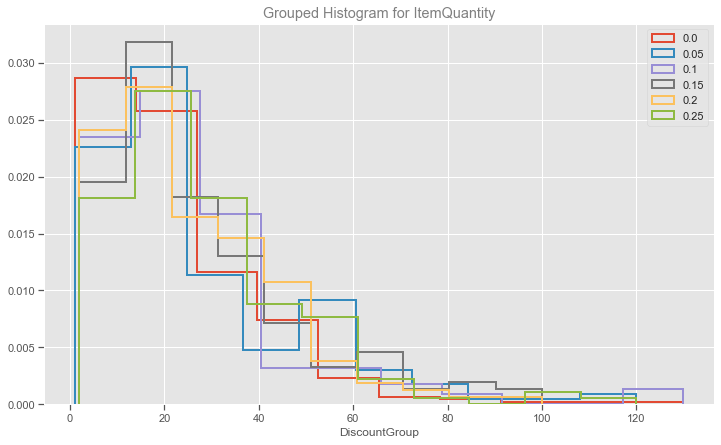

Grouping DataFrame by DiscountGroup
Target Features: ItemQuantity


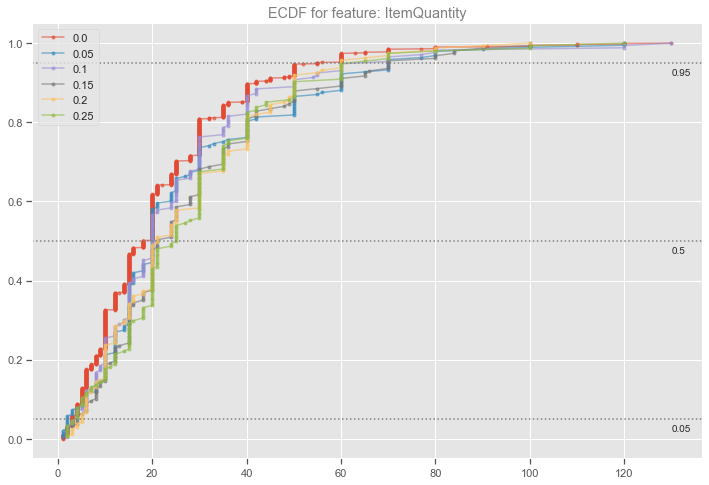

In [178]:
group_hist(df2, 'DiscountGroup', 'ItemQuantity');
mf.ecdf(df2, group_by='DiscountGroup', targets='ItemQuantity');

We can see that all the groups with discounts have a higher mean and median than the control group.

In [179]:
# I am going to apply transformations to see how the normality of the target variable is affected
df2['ItemQuantity3rt'] = df2.ItemQuantity**(1/3)
df2['ItemQuantity4rt'] = df2.ItemQuantity**(1/4)
df2['ItemQuantity5rt'] = df2.ItemQuantity**(1/5)

Variable: ItemQuantity3rt
Normality Test Results for ['ItemQuantity3rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity3rt 
 Statistic 
 0.893365 
 9.909629e-01 
 
 
 p-value 
 0.000000 
 2.436937e-10 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity3rt 
 5.462145 
 0.786

count    2155.000000
mean        2.687421
std         0.732420
min         1.000000
25%         2.154435
50%         2.714418
75%         3.107233
max         5.065797
Name: ItemQuantity3rt, dtype: float64

Skew: 0.20609609174601595


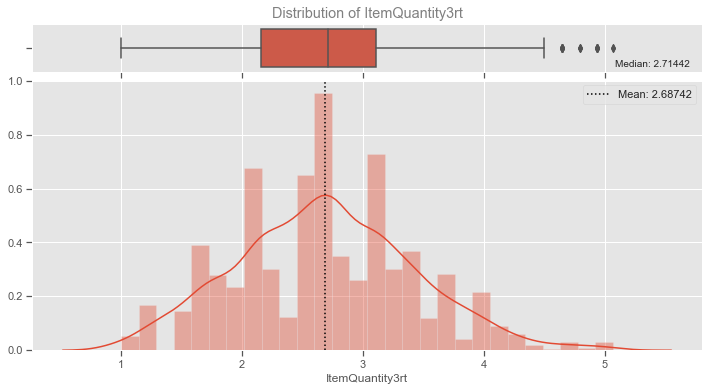

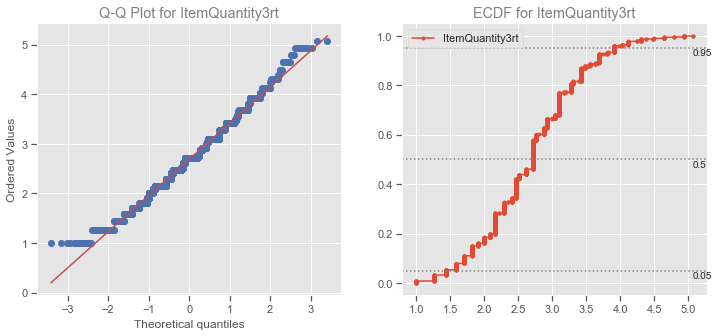

Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 0.874932 
 9.932903e-01 
 
 
 p-value 
 0.000000 
 2.333465e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 5.115893 
 0.786

count    2155.000000
mean        2.083918
std         0.431423
min         1.000000
25%         1.778279
50%         2.114743
75%         2.340347
max         3.376648
Name: ItemQuantity4rt, dtype: float64

Skew: 0.010734805957036644


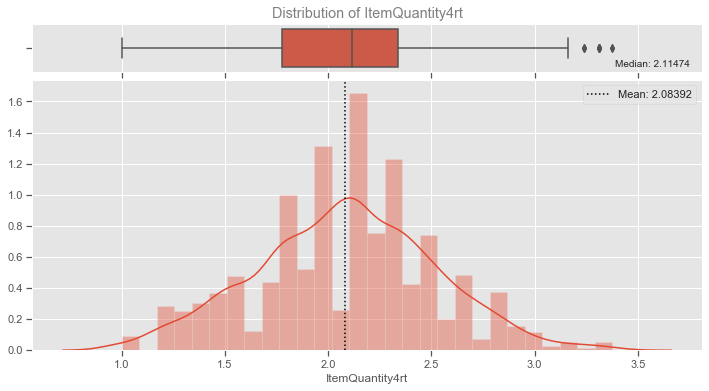

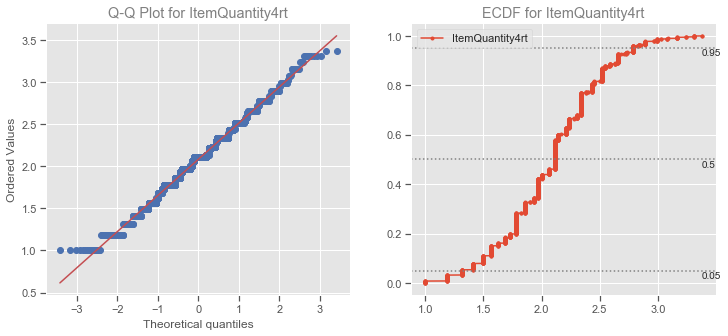

Variable: ItemQuantity5rt
Normality Test Results for ['ItemQuantity5rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity5rt 
 Statistic 
 0.866771 
 9.925116e-01 
 
 
 p-value 
 0.000000 
 4.633449e-09 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity5rt 
 5.944852 
 0.786

count    2155.000000
mean        1.792965
std         0.299598
min         1.000000
25%         1.584893
50%         1.820564
75%         1.974350
max         2.647212
Name: ItemQuantity5rt, dtype: float64

Skew: -0.10828000241968562


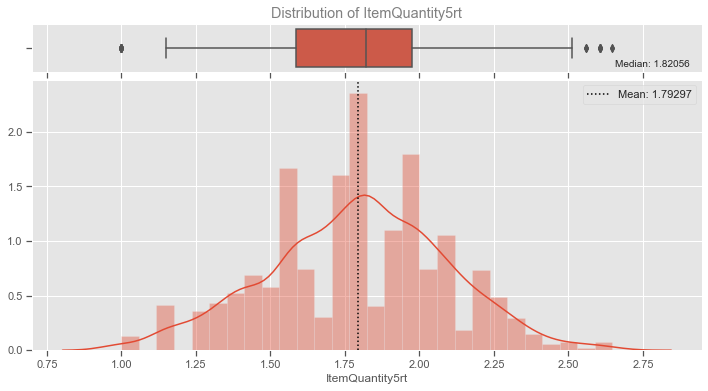

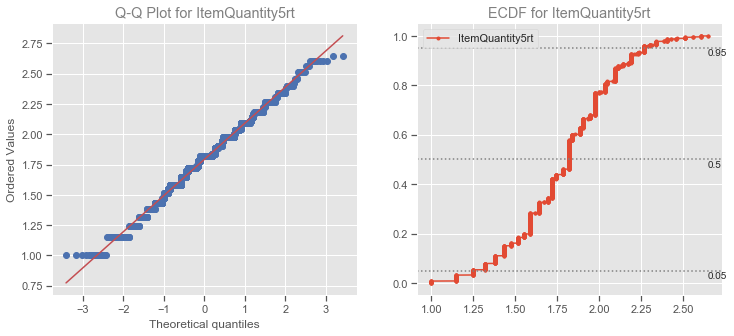

(                                K-S  Shapiro-Wilk
 ItemQuantity3rt Statistic  0.893365  9.909629e-01
                 p-value    0.000000  2.436937e-10
 ItemQuantity4rt Statistic  0.874932  9.932903e-01
                 p-value    0.000000  2.333465e-08
 ItemQuantity5rt Statistic  0.866771  9.925116e-01
                 p-value    0.000000  4.633449e-09,
                  statistic  critical
 ItemQuantity3rt   5.462145     0.786
 ItemQuantity4rt   5.115893     0.786
 ItemQuantity5rt   5.944852     0.786)

In [180]:
targets = ['ItemQuantity3rt', 'ItemQuantity4rt', 'ItemQuantity5rt']
visualize_distribution(df2, targets)

It looks as though the 4th root transformation is superior, with a lower p-val from the Shapiro-Wilk test. Let's see the effect of removing outliers with the Tukey method.

Length of old DataFrame: 2155
Length of Tukey trimmed DataFrame 2142
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 0.874884 
 9.920184e-01 
 
 
 p-value 
 0.000000 
 1.919430e-09 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 5.625238 
 0.786

count    2142.000000
mean        2.076516
std         0.422087
min         1.000000
25%         1.778279
50%         2.114743
75%         2.340347
max         3.162278
Name: ItemQuantity4rt, dtype: float64

Skew: -0.08291959537975077


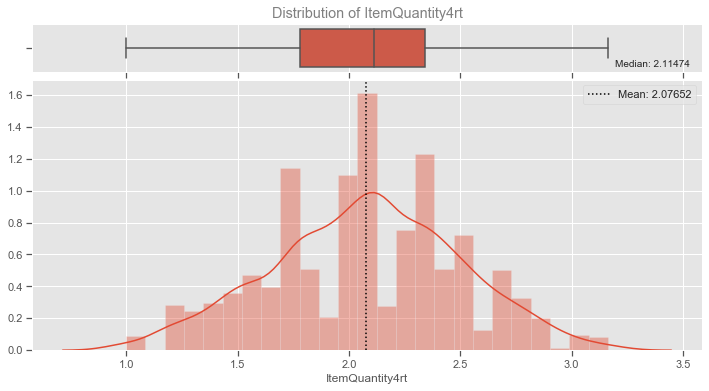

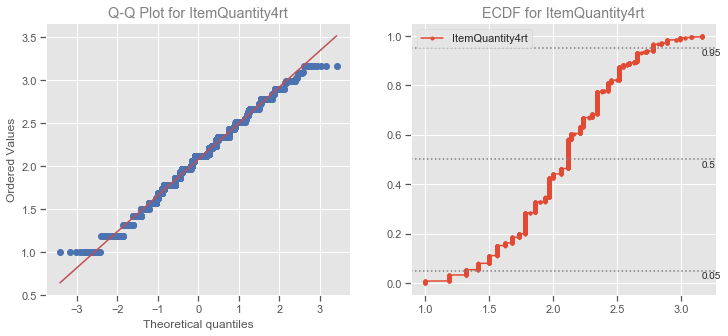

In [181]:
tukey_df2 = tukey_trim(df2, 'ItemQuantity4rt', coef=1.5)
visualize_distribution(tukey_df2, ['ItemQuantity4rt']);

Length of old DataFrame: 2155
Length of trimmed DataFrame: 2108
 
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 0.882821 
 9.874712e-01 
 
 
 p-value 
 0.000000 
 1.282608e-12 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 6.621423 
 0.786

count    2108.000000
mean        2.076760
std         0.403522
min         1.189207
25%         1.778279
50%         2.114743
75%         2.340347
max         2.990698
Name: ItemQuantity4rt, dtype: float64

Skew: -0.08661751546387908


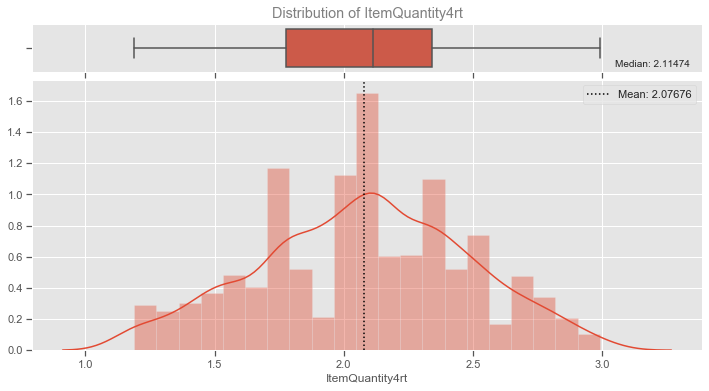

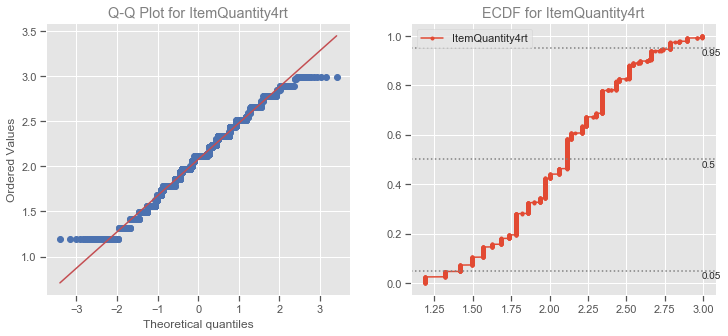

(                                K-S  Shapiro-Wilk
 ItemQuantity4rt Statistic  0.882821  9.874712e-01
                 p-value    0.000000  1.282608e-12,
                  statistic  critical
 ItemQuantity4rt   6.621423     0.786)

In [182]:
# This did not improve the normality of the distribution, now to try another trimming method
df2_trimmed = trim_df_by_col(df2, 'ItemQuantity4rt', 2)
visualize_distribution(df2_trimmed, ['ItemQuantity4rt'])

Length of old DataFrame: 2155
Length of Winsorized DataFrame: 2155
 
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 0.882821 
 9.830528e-01 
 
 
 p-value 
 0.000000 
 2.500650e-15 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 7.182977 
 0.786

count    2155.000000
mean        2.080288
std         0.416321
min         1.189207
25%         1.778279
50%         2.114743
75%         2.340347
max         2.892508
Name: ItemQuantity4rt, dtype: float64

Skew: -0.09990768777700075


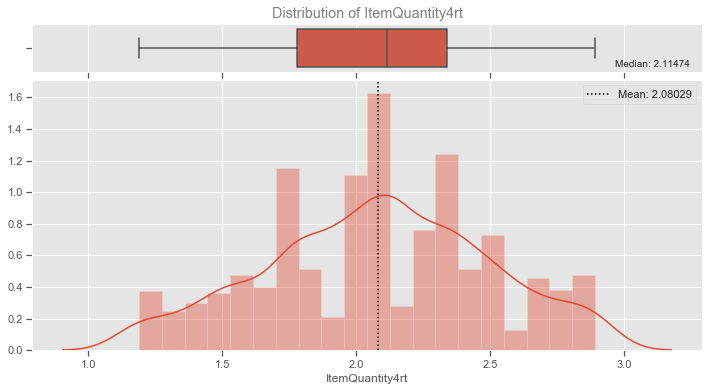

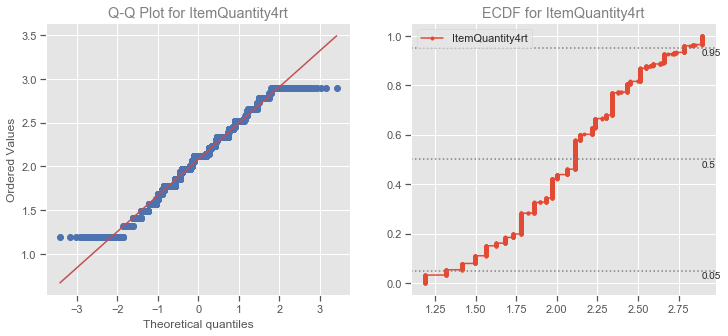

In [183]:
# This did not help the normality of the group, trying another trimming method
df2_trimmed = winsorize_df(df2, 'ItemQuantity4rt', 3)
test = visualize_distribution(df2_trimmed, ['ItemQuantity4rt'])

In [184]:
# None of the trimming methods seem to be helping improve normality here. I will opt to not trim
# Though the normality tests are rejecting the null hypothesis, It looks as though the
# distribution of ItemQuantity4rt is normal enough to perform some tests.

In [185]:
# Cleaning memory:
delete = [tukey_df2, df2_trimmed]
del delete

<a id='hypothesis_testing2'></a>
# Hypothesis Testing 2:

<a id='discount_itemquantity'></a>
## Effect of Discount on Item Quantity

Showing stats for ItemQuantity4rt grouped by DiscountGroup


Mean    Median       Std  Size
0.00  2.036046  2.059767  0.421533  1317
0.05  2.136333  2.114743  0.469245   193
0.10  2.116051  2.114743  0.430825   173
0.15  2.191698  2.140695  0.428158   157
0.20  2.171264  2.140695  0.412604   161
0.25  2.190335  2.236068  0.431697   154

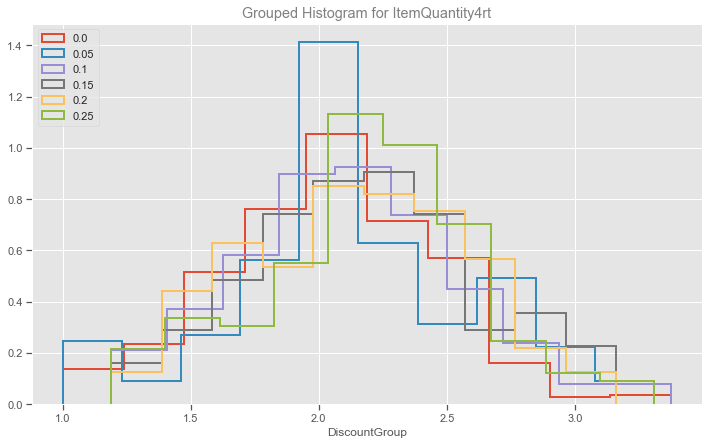

Grouping DataFrame by DiscountGroup
Target Features: ItemQuantity4rt


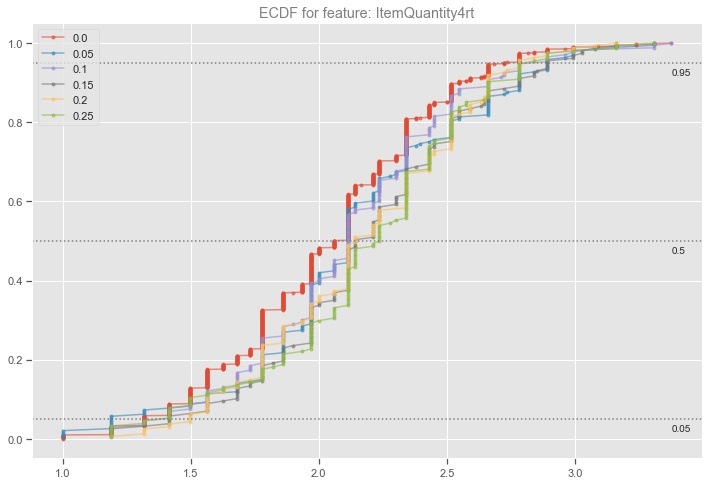

Showing stats for ItemQuantity4rt grouped by DiscountGroup


Mean    Median       Std  Size
0.00  2.036046  2.059767  0.421533  1317
0.05  2.136333  2.114743  0.469245   193
0.10  2.116051  2.114743  0.430825   173
0.15  2.191698  2.140695  0.428158   157
0.20  2.171264  2.140695  0.412604   161
0.25  2.190335  2.236068  0.431697   154

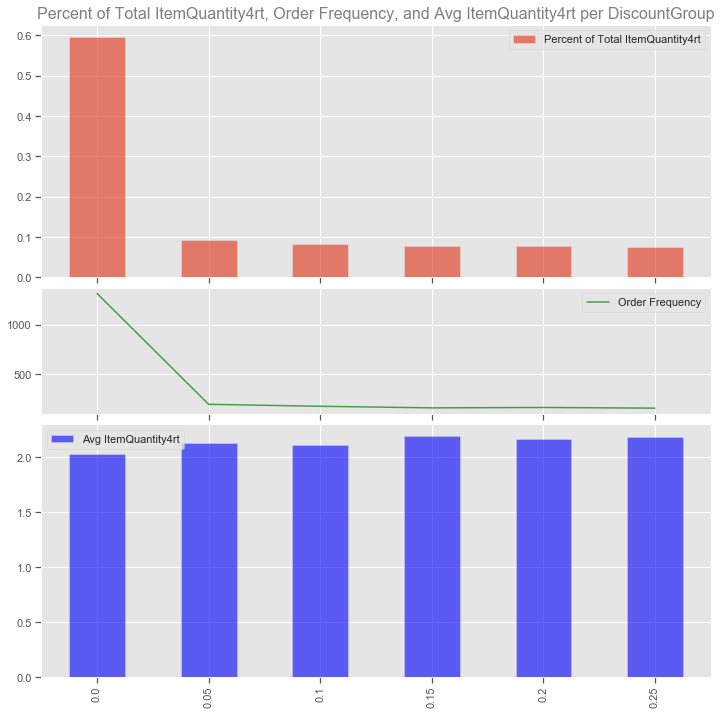

In [186]:
# First, a look at the layered histogram for transformed variable OrderTotal4rt
group_hist(df2, 'DiscountGroup', 'ItemQuantity4rt');
mf.ecdf(df2, 'DiscountGroup', 'ItemQuantity4rt');
explore_groups(df2, 'DiscountGroup', 'ItemQuantity4rt');

In [187]:
# It appears as though there may be an upward trend in the means, a linear regression will
# test for this

<a id='frequentist2'></a>
### Frequentist Approaches

<a id='assumptions2'></a>
#### Testing Assumptions

Testing for Normality

Side by side comparison of all group distributions:


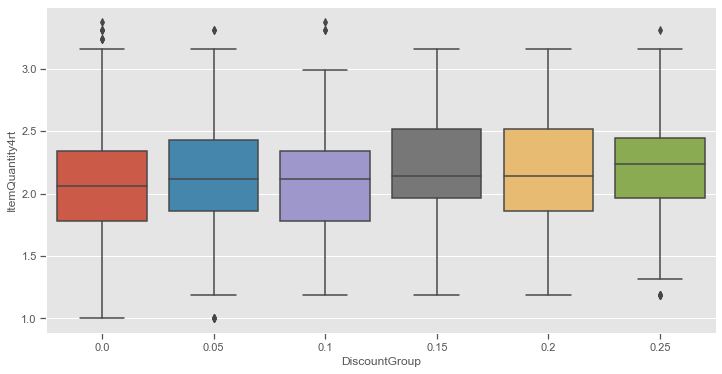

Checking normality and visualizing distributions for 0.0 group
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 0.873275 
 0.992513 
 
 
 p-value 
 0.000000 
 0.000003 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 3.52521 
 0.785

count    1317.000000
mean        2.036046
std         0.421533
min         1.000000
25%         1.778279
50%         2.059767
75%         2.340347
max         3.376648
Name: ItemQuantity4rt, dtype: float64

Skew: 0.03919564760006633


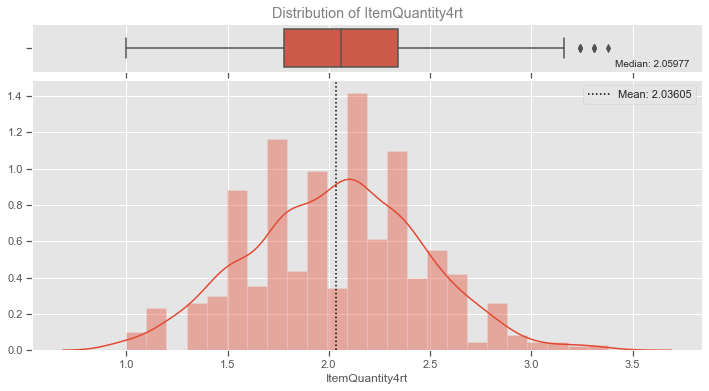

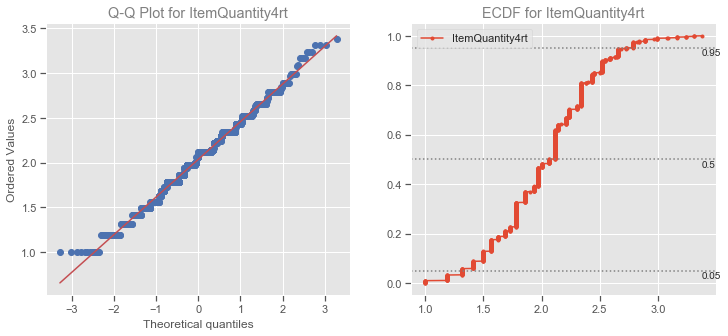

Checking normality and visualizing distributions for 0.05 group
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 8.620955e-01 
 0.979647 
 
 
 p-value 
 3.577865e-166 
 0.006575 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 1.511969 
 0.772

count    193.000000
mean       2.136333
std        0.469245
min        1.000000
25%        1.861210
50%        2.114743
75%        2.432299
max        3.309751
Name: ItemQuantity4rt, dtype: float64

Skew: -0.05860819984380938


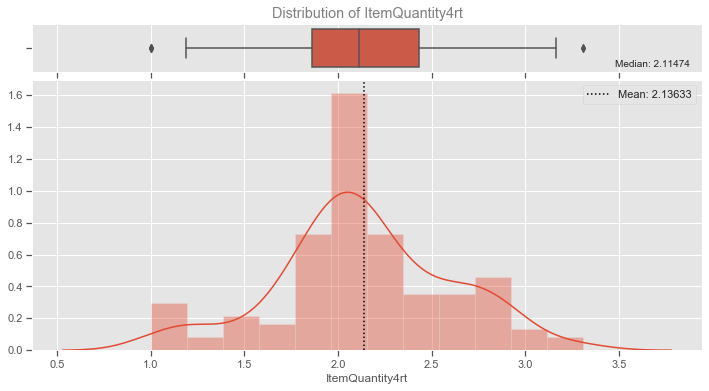

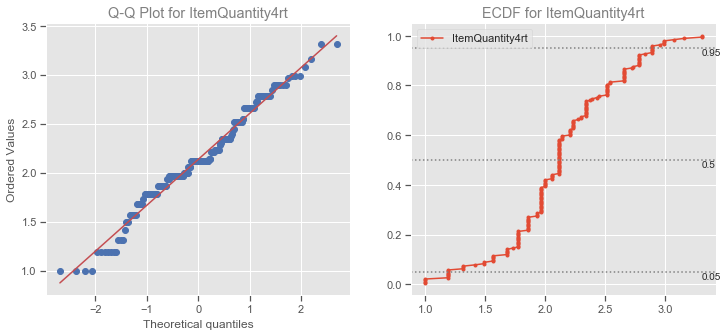

Checking normality and visualizing distributions for 0.1 group
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 8.828209e-01 
 0.987309 
 
 
 p-value 
 2.011022e-161 
 0.120896 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 0.559591 
 0.77

count    173.000000
mean       2.116051
std        0.430825
min        1.189207
25%        1.778279
50%        2.114743
75%        2.340347
max        3.376648
Name: ItemQuantity4rt, dtype: float64

Skew: 0.1801200802149746


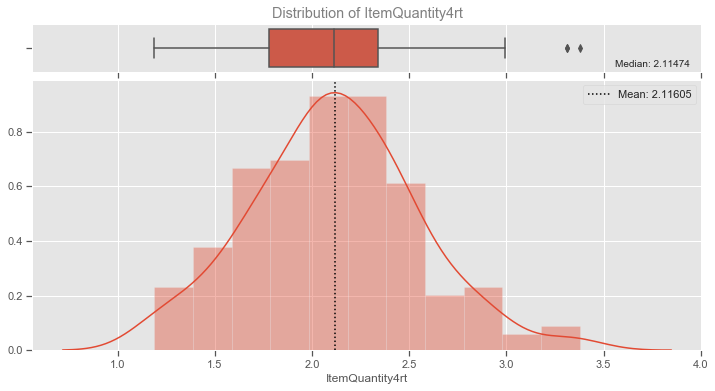

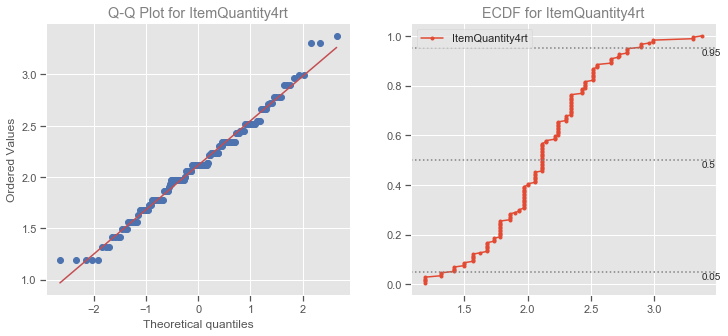

Checking normality and visualizing distributions for 0.15 group
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 8.895033e-01 
 0.989470 
 
 
 p-value 
 1.438526e-150 
 0.290976 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 0.40794 
 0.768

count    157.000000
mean       2.191698
std        0.428158
min        1.189207
25%        1.967990
50%        2.140695
75%        2.514867
max        3.162278
Name: ItemQuantity4rt, dtype: float64

Skew: -0.051013825538334494


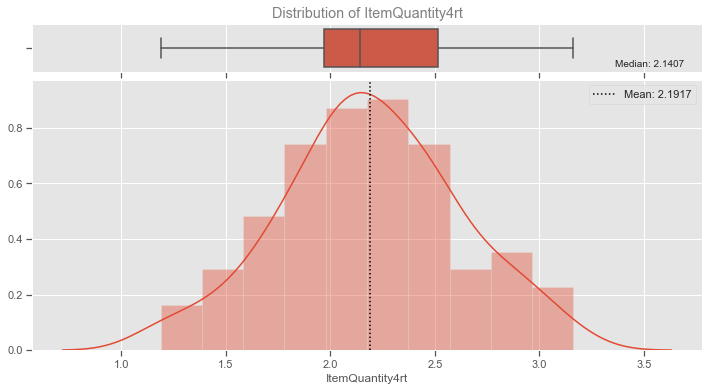

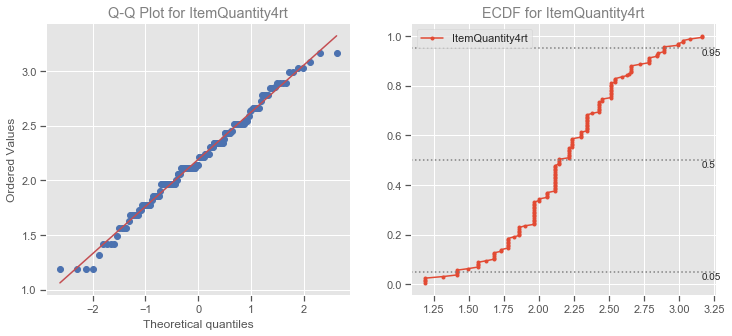

Checking normality and visualizing distributions for 0.2 group
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 8.997142e-01 
 0.986168 
 
 
 p-value 
 3.333904e-161 
 0.111017 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 0.80817 
 0.769

count    161.000000
mean       2.171264
std        0.412604
min        1.189207
25%        1.861210
50%        2.140695
75%        2.514867
max        3.162278
Name: ItemQuantity4rt, dtype: float64

Skew: -0.09038874305034401


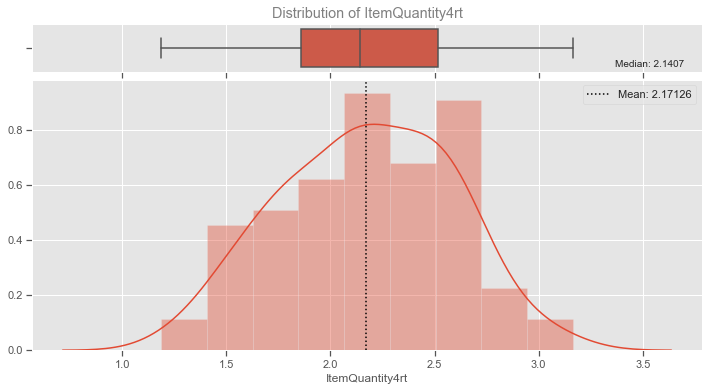

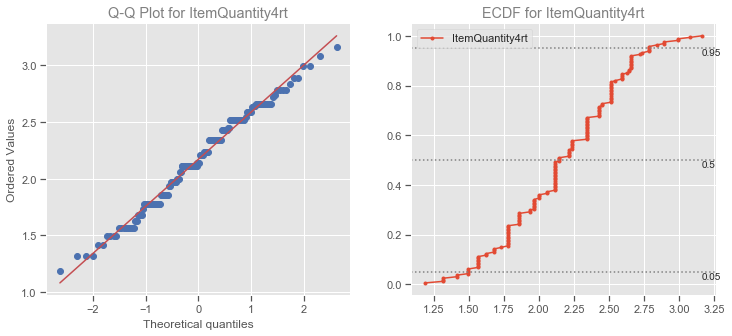

Checking normality and visualizing distributions for 0.25 group
Variable: ItemQuantity4rt
Normality Test Results for ['ItemQuantity4rt']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemQuantity4rt 
 Statistic 
 8.828209e-01 
 0.977813 
 
 
 p-value 
 9.628942e-144 
 0.013753 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemQuantity4rt 
 1.196231 
 0.768

count    154.000000
mean       2.190335
std        0.431697
min        1.189207
25%        1.967990
50%        2.236068
75%        2.449490
max        3.309751
Name: ItemQuantity4rt, dtype: float64

Skew: -0.30066456063047076


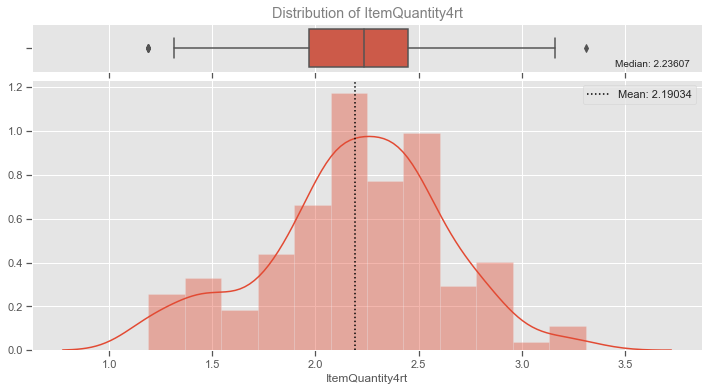

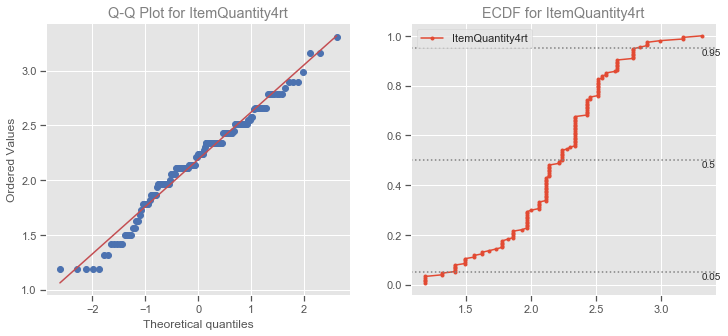

In [188]:
# Testing each group for normality assumptions:
# Side-by-side boxplot of groups:
fig, ax = plt.subplots(figsize=(12,6))
print("Side by side comparison of all group distributions:")
sns.boxplot(x=df2.DiscountGroup, y=df2.ItemQuantity4rt)
plt.show()

# Visualizing each distribution with Q-Q plots and normality tests
targets = ['ItemQuantity4rt']
grouped = df2.groupby(['DiscountGroup'])[targets]
group_tests1 = {}
group_tests2 = {}

for group in grouped:
    print('Checking normality and visualizing distributions for {} group'.format(group[0]))
    temp_df = pd.DataFrame(group[1])
    temp_df.columns = df2.columns
    res1, res2 = visualize_distribution(temp_df, targets)
    group_tests1[group[0]] = res1
    group_tests2[group[0]] = res2
    
group_tests1 = pd.concat(group_tests1.values(), axis=0, keys=group_tests1.keys())
group_tests2 = pd.concat(group_tests2.values(), axis=0, keys=group_tests2.keys()) 

In [189]:
# Looking at compiled numeric test results:
names = ['K-S and Shapiro-Wilk', 'Anderson-Darling']
mf.display_side_by_side(group_tests1, group_tests2, names=names)

K-S and Shapiro-Wilk 
 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 0.00 
 ItemQuantity4rt 
 Statistic 
 8.732754e-01 
 0.992513 
 
 
 p-value 
 0.000000e+00 
 0.000003 
 
 
 0.05 
 ItemQuantity4rt 
 Statistic 
 8.620955e-01 
 0.979647 
 
 
 p-value 
 3.577865e-166 
 0.006575 
 
 
 0.10 
 ItemQuantity4rt 
 Statistic 
 8.828209e-01 
 0.987309 
 
 
 p-value 
 2.011022e-161 
 0.120896 
 
 
 0.15 
 ItemQuantity4rt 
 Statistic 
 8.895033e-01 
 0.989470 
 
 
 p-value 
 1.438526e-150 
 0.290976 
 
 
 0.20 
 ItemQuantity4rt 
 Statistic 
 8.997142e-01 
 0.986168 
 
 
 p-value 
 3.333904e-161 
 0.111017 
 
 
 0.25 
 ItemQuantity4rt 
 Statistic 
 8.828209e-01 
 0.977813 
 
 
 p-value 
 9.628942e-144 
 0.013753 
 
 
 Anderson-Darling 
 
 
 
 
 statistic 
 critical 
 
 
 
 
 0.00 
 ItemQuantity4rt 
 3.525210 
 0.785 
 
 
 0.05 
 ItemQuantity4rt 
 1.511969 
 0.772 
 
 
 0.10 
 ItemQuantity4rt 
 0.559591 
 0.770 
 
 
 0.15 
 ItemQuantity4rt 
 0.407940 
 0.768 
 
 
 0.20 
 ItemQuantity4rt 
 0.808170 
 0.769 
 
 
 0.25 
 ItemQuantity4rt 
 1.196231 
 0.768

In [190]:
# Although the null hypothesis that the distribution is normal can be rejected for 3 out of the
# 6 groups according to the Shapiro-Wilk tests, and 4/6 by the Anderson-Darling tests, it looks
# from the Q-Q plots and histograms that the data is probably normal enough to do some tests on.
# We will be able to tell if the frequentist methods fail us when we see the results of the 
# bootstrap simulations and MCMC

Testing for equality of variance:

In [206]:
# Pairwise Fischer's F test (highly sensitive to normality assumption)
mf.f_test_groups(df2, group_var='DiscountGroup', target='ItemQuantity4rt')

0.00      0.05      0.10      0.15      0.20      0.25
0.00       NaN  0.041175  0.680627  0.769648  0.742519  0.668198
0.05  0.041175       NaN  0.252670  0.233803  0.092254  0.281495
0.10  0.680627  0.252670       NaN  0.938834  0.580039  0.977048
0.15  0.769648  0.233803  0.938834       NaN  0.641875  0.918229
0.20  0.742519  0.092254  0.580039  0.641875       NaN  0.571285
0.25  0.668198  0.281495  0.977048  0.918229  0.571285       NaN

In [207]:
# It looks like the pairwise F tests are indicating mostly homogeneous variance among groups,
# although there is a significant difference between 0.05 and control.
# Let's see what a median-based Leven's (Brown & Forsythe) test would say
samples = {k: v for k,v in df2.groupby('DiscountGroup').ItemQuantity4rt}
stats.levene(samples[0.0],
             samples[0.05],
             samples[0.1],
             samples[0.15],
             samples[0.20],
             samples[0.25]
            )

LeveneResult(statistic=0.17239328360447304, pvalue=0.9728840970344713)

In [208]:
# The test fails to reject the null hypothesis that the variances are homogeneous.
# Since this test is median-based, I would like to compare it's performance to the 
# untransformed ItemQuantity variable:
samples2 = {k: v for k,v in df2.groupby('DiscountGroup').ItemQuantity}
stats.levene(samples[0.0],
             samples[0.05],
             samples[0.1],
             samples[0.15],
             samples[0.20],
             samples[0.25]
            )

LeveneResult(statistic=0.17239328360447304, pvalue=0.9728840970344713)

In [209]:
# Back to transformed variable for a test with an assumption of normality:
stats.bartlett(samples[0.0],
               samples[0.05],
               samples[0.1],
               samples[0.15],
               samples[0.20],
               samples[0.25]
              )

BartlettResult(statistic=4.499630543309374, pvalue=0.47993287167511944)

In [210]:
# We can see the propensity for a false-positive from the Bartlett test with non-normal data
# A Fligner-Killeen test is a non-parametric alternative to a Levene test for k-variances
stats.fligner(samples[0.0],
              samples[0.05],
              samples[0.1],
              samples[0.15],
              samples[0.20],
              samples[0.25]
             )

FlignerResult(statistic=1.0277914179162573, pvalue=0.9602932004608515)

We can see that the Fligner-Killeen and Brown & Forsythe tests have produced nearly identical results, and fail to reject the null hypothesis that the groups are sampled from distributions with equal variances. Further, using the Brown & Forsythe test on the non-transformed data gave a similar result.

<a id='linreg2'></a>
#### Linear Regresssions

Linear Regression for ItemQuantity4rt ~ Discount


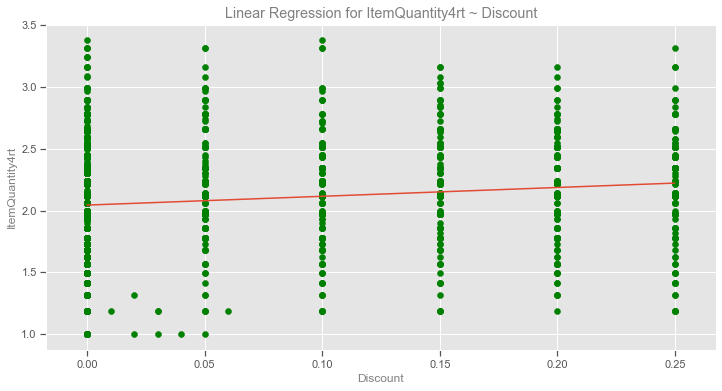

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ItemQuantity4rt   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     41.47
Date:                Mon, 06 Apr 2020   Prob (F-statistic):           1.47e-10
Time:                        01:16:21   Log-Likelihood:                -1225.1
No. Observations:                2155   AIC:                             2454.
Df Residuals:                    2153   BIC:                             2466.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0440      0.011    184.152      0.000       2.022       2.066
Discount       0.7107      0.110      6.440      0.000       0.494       0.927
==============================================================================
Omnibus:                        0.874   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.646   Jarque-Bera (JB):                0.919
Skew:                           0.009   Prob(JB):                        0.632
Kurtosis:                       2.900   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic     p_value
Goldfeld-Quandt     1.19887  0.00291595

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 2.044129e-01 
 0.996086 
 
 
 p-value 
 1.965788e-79 
 0.000022 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 2.325818 
 0.786

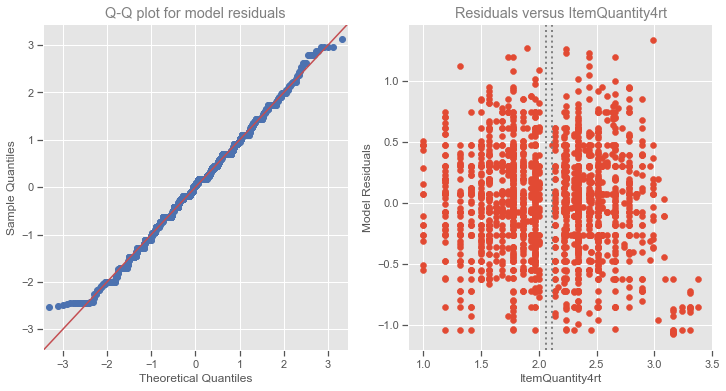

In [192]:
# First, a linear test on the continuous variable, rejecting the null hypothesis that the 
# coefficient is zero and there is no linear relationship at alpha = 0.05
do_a_linreg(df2, 'Discount', 'ItemQuantity4rt');

In [198]:
# Regression Diagnostics:
#    - The null hypothesis that the residuals are normally distributed is rejected
#    - The null hypothesis that the residuals are homoscedastic is not rejected
#    - The null for J-B and Omnibus that the skew/kurtosis is normal is not rejected.

# Assuming the model is accurate, there is a statistically significant positive linear
# relationship between the variables, with a non-zero coefficient.

So what does it mean that our residuals are non-normal? According to [Schmidt and Finan](https://www.rug.nl/research/portal/files/51783532/1_s2.0_S0895435617304857_main_1_.pdf), "this normality assumption is necessary to unbiasedly estimate standard errors, and hence confidence intervals and p-values. However,in large sample sizes (e.g., where the number of observations per variable is larger than 10) violations of this normality assumption do not noticeably impact results" (2). Since our sample sizes are much larger than 10, we can assume based on this information that our confidence interval for our coefficient is accurate, and that there is indeed a positive linear relationship between the variables.

In [199]:
# Testing for linear correlation with Pearson's r, alpha=0.05:
corr, pval = stats.pearsonr(df2.DiscountGroup, 
                            df2.ItemQuantity4rt)
print("Pearson r: {}\np-val: {}".format(corr,pval))

Pearson r: 0.1355515235217825
p-val: 2.647993900947129e-10


In [200]:
# The pearson correlation test also confirms a positive and statistically significant 
# correlation between Discount and ItemQuantity4rt

Linear Regression for ItemQuantity4rt ~ Discount


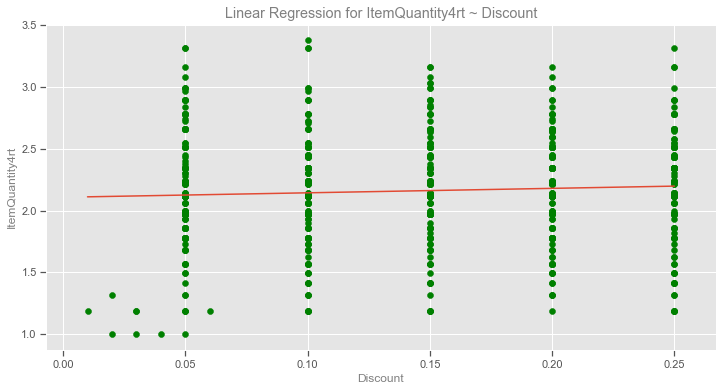

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ItemQuantity4rt   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.945
Date:                Mon, 06 Apr 2020   Prob (F-statistic):             0.0865
Time:                        01:29:39   Log-Likelihood:                -492.00
No. Observations:                 838   AIC:                             988.0
Df Residuals:                     836   BIC:                             997.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1072      0.034     62.284      0.000       2.041       2.174
Discount       0.3600      0.210      1.716      0.086      -0.052       0.772
==============================================================================
Omnibus:                        0.448   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.799   Jarque-Bera (JB):                0.505
Skew:                          -0.053   Prob(JB):                        0.777
Kurtosis:                       2.942   Cond. No.                         14.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic    p_value
Goldfeld-Quandt     1.17417  0.0676422

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 1.936855e-01 
 0.99536 
 
 
 p-value 
 5.172783e-28 
 0.01240 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 1.002594 
 0.783

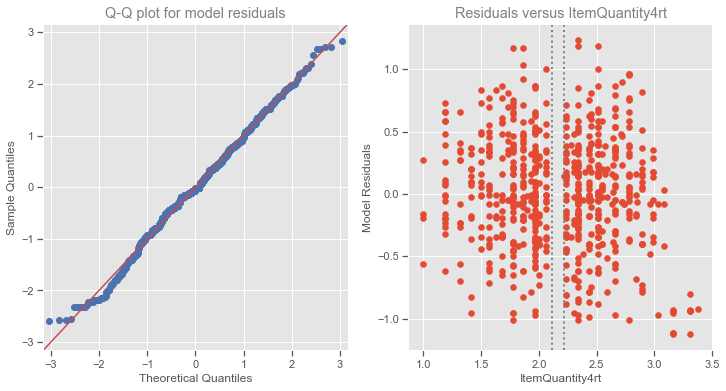

In [201]:
# As before, I want to see the effect of removing the 0.0 (control) group, to see what kind of
# trend, if any, exists among the discounted items.
# Looking at compiled numeric test results:
do_a_linreg(df2[df2.Discount > 0], 'Discount', 'ItemQuantity4rt');

In [ ]:
# Regression Diagnostics:
#   - the null hypothesis of normal residuals is rejected, though it is a close call
#   - the null hypothesis of homoscedastic residuals is rejected, though just barely
#   - the null hypothesis of J-B and Omnibus is not rejected, indicating normal skew/kurtosis
#   - the null hypothesis of the F-test that the coefficients are zero is not rejected.

# We can see that though the model has a positive coefficient between the variables, it is
# not significant, as the 95% confidence interval is including zero.

Linear Regression for ItemQuantity4rt ~ DiscountGroup


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ItemQuantity4rt   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     9.336
Date:                Mon, 06 Apr 2020   Prob (F-statistic):           8.23e-09
Time:                        01:32:32   Log-Likelihood:                -1222.5
No. Observations:                2155   AIC:                             2457.
Df Residuals:                    2149   BIC:                             2491.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.0360      0.012    172.917      0.000       2.013       2.059
DiscountGroup[T.0.05]     0.1003      0.033      3.045      0.002       0.036       0.165
DiscountGroup[T.0.1]      0.0800      0.035      2.315      0.021       0.012       0.148
DiscountGroup[T.0.15]     0.1557      0.036      4.314      0.000       0.085       0.226
DiscountGroup[T.0.2]      0.1352      0.036      3.790      0.000       0.065       0.205
DiscountGroup[T.0.25]     0.1543      0.036      4.240      0.000       0.083       0.226
==============================================================================
Omnibus:                        0.861   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.650   Jarque-Bera (JB):                0.906
Skew:                          -0.001   Prob(JB):                        0.636
Kurtosis:                       2.900   Cond. No.                         4.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic     p_value
Goldfeld-Quandt     1.20054  0.00278427

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 2.034997e-01 
 0.996599 
 
 
 p-value 
 1.010022e-78 
 0.000096 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 2.132903 
 0.786

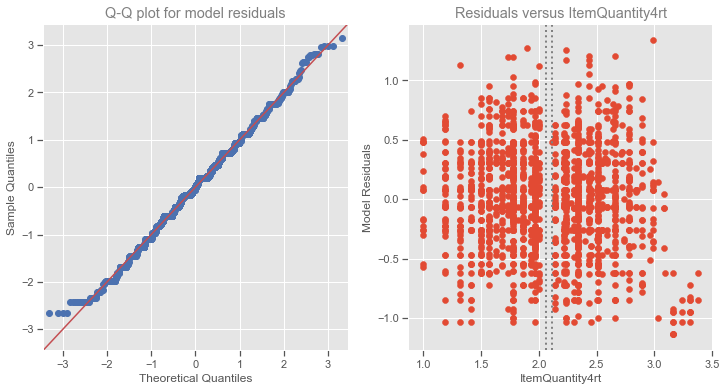

In [202]:
# Now a test on the categorical variable
# Testing for coefficients with p-values less than 0.05 to reject null hypothesis
# The F test will determine whether any single group is not like the others
lm = do_a_linreg(df2, 'DiscountGroup', 'ItemQuantity4rt')

In [203]:
# Regression Diagnostics:
#   - the null hypothesis that the residuals are normal has been rejected
#   - the null hypothesis that the residuals are homoscedastic is not rejected
#   - the null hypothesis of J-B and Omnibus of normal skew/kurtosis of residuals is not rejctd
#   - the null hypothesis of the F-test that the coefficients are all zero is rejected

# The model shows that all group coefficients have a statistically significant p-value

<a id='anova2'></a>
#### ANOVA and Post-Hoc Tests

In [212]:
# Generating ANOVA table from the linear model
# The equal variance assumption was justified earlier with the Brown & Forsythe tests
anova_table = sm.stats.anova_lm(lm, typ=2)
anova_table

sum_sq      df         F        PR(>F)
DiscountGroup    8.523164     5.0  9.335707  8.226776e-09
Residual       392.391927  2149.0       NaN           NaN

In [213]:
# A quick comparison to Welch's ANOVA, for fun
pi.welch_anova(df2, dv='ItemQuantity4rt', between='DiscountGroup')

Source  ddof1    ddof2      F         p-unc
0  DiscountGroup      5  449.178  9.316  1.862592e-08

In [313]:
# We can see the slight lack of power of the Welch's test in comparison, although the outcomes
# in this case are equivalent.

# Looking at the ANOVA tables above, we see again that the F-test is showing that at least one
# group is statistically different from the others. Now we can perform post-hoc tests to
# determine which groups.

In [214]:
# Pairwise Welch's t-test, reject null hypothesis if p<0.05
results = sp.posthoc_ttest(df2, 
                           val_col='ItemQuantity4rt', 
                           group_col='DiscountGroup',
                           equal_var=False,
                           #p_adjust='holm'
                          )
results

0.00      0.05      0.10      0.15      0.20      0.25
0.00 -1.000000  0.005401  0.022277  0.000026  0.000123  0.000040
0.05  0.005401 -1.000000  0.666684  0.249997  0.456754  0.266181
0.10  0.022277  0.666684 -1.000000  0.110984  0.232456  0.121011
0.15  0.000026  0.249997  0.110984 -1.000000  0.665174  0.977728
0.20  0.000123  0.456754  0.232456  0.665174 -1.000000  0.689065
0.25  0.000040  0.266181  0.121011  0.977728  0.689065 -1.000000

In [215]:
# Pairwise student's t-test with pooled_sd
results = sp.posthoc_ttest(df2, 
                           val_col='ItemQuantity4rt', 
                           group_col='DiscountGroup',
                           pool_sd=True,
                           #p_adjust='holm'
                          )
results

0.00      0.05      0.10      0.15      0.20      0.25
0.00 -1.000000  0.002355  0.020692  0.000017  0.000155  0.000023
0.05  0.002355 -1.000000  0.650354  0.228121  0.443831  0.242282
0.10  0.020692  0.650354 -1.000000  0.108407  0.238155  0.116762
0.15  0.000017  0.228121  0.108407 -1.000000  0.669904  0.977574
0.20  0.000155  0.443831  0.238155  0.669904 -1.000000  0.692171
0.25  0.000023  0.242282  0.116762  0.977574  0.692171 -1.000000

In [219]:
# Fixing labels into a new discount column with no decimals for compatibility:
df2['DiscountGroup2'] = df2['DiscountGroup'].replace({0.0: '0.0',
                                                 0.05: '0.05',
                                                 0.10: '0.10',
                                                 0.15: '0.15',
                                                 0.20: '0.20',
                                                 0.25: '0.25'})

In [220]:
# Comparing above test to another post-hoc test which does not assume equal pop variances
results = sp.posthoc_tamhane(df2,
                             val_col='ItemQuantityt4rt',
                             group_col='DiscountGroup2',
                             welch=True, # makes this a Tamhane T2 test
                             #sort=True
                            )
results

ValueError: Specify correct column names using `group_col` and `val_col` args

This error is nonsensical, I will move on.

In [221]:
# A look at a non-parametric alternative to ANOVA:
stats.kruskal(samples[0.0],
               samples[0.05],
               samples[0.1],
               samples[0.15],
               samples[0.20],
               samples[0.25])

KruskalResult(statistic=47.139630077136744, pvalue=5.320988118867079e-09)

In [308]:
# The Kruskal-Wallis test is equivalent to the parametric ANOVA result from earlier
# Following up with non-parametric Dunn test
results = sp.posthoc_dunn(df2, 
                          val_col='ItemQuantity4rt', 
                          group_col='DiscountGroup2',
                          #p_adjust='bonferroni',
                          sort=True)
results

0.0      0.05      0.10      0.15      0.20      0.25
0.0  -1.000000  0.004776  0.038002  0.000028  0.000133  0.000005
0.05  0.004776 -1.000000  0.634977  0.206122  0.341332  0.110661
0.10  0.038002  0.634977 -1.000000  0.092246  0.167169  0.045021
0.15  0.000028  0.206122  0.092246 -1.000000  0.759636  0.747685
0.20  0.000133  0.341332  0.167169  0.759636 -1.000000  0.529905
0.25  0.000005  0.110661  0.045021  0.747685  0.529905 -1.000000

In [313]:
# Using Dunn's test with p-value adjustment for 5 groups:
pd.DataFrame(results.drop(columns=['0.0']).loc['0.0'] * 5).T

0.05      0.10      0.15      0.20      0.25
0.0  0.023878  0.190011  0.000142  0.000663  0.000024

<a id='ttest2'></a>
#### t-tests

Testing DiscountGroup groups for statistically significant effects on ItemQuantity4rt


0.05        0.10        0.15        0.20        0.25
p-val          0.027003    0.111385    0.000128    0.000615    0.000200
effect size    0.234368    0.189309    0.368633    0.321508    0.365092
size         193.000000  173.000000  157.000000  161.000000  154.000000
power          0.631790    0.419198    0.902523    0.820166    0.891331

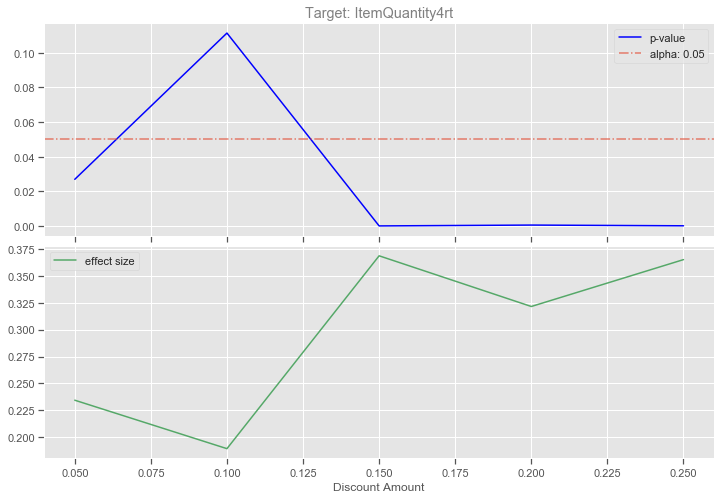

In [223]:
# Running a t-test for each discount group against the group with no discount:
compare_groups(df2, 'DiscountGroup', ['ItemQuantity4rt'], 0.0, p_adjust=True)

The results of the above tests show that every treatment group except for 0.10 has a statistically significant effect with a confidence interval of 95%. The largest effect is at 0.15 discount level, with 0.25 discount level following closely behind. This indicates that offering a discount in excess of 0.15 on any given item is unneccessary, if the goal is to liquidate the inventory, as no greater effect will be attained at further cost of revenue. The effect for the 0.10 group is small, at below .2, which is likely why it is not being found significant.

In [224]:
# A comparison to more commonly used transformations:
df2['ItemQuantityLog'] = np.log(df2.ItemQuantity)
df2['ItemQuantitySqrt'] = np.sqrt(df2.ItemQuantity)

Testing DiscountGroup groups for statistically significant effects on ItemQuantity


0.05        0.10        0.15        0.20        0.25
p-val          0.010869    0.187280    0.000861    0.004055    0.000796
effect size    0.286176    0.195964    0.372445    0.300725    0.366623
size         193.000000  173.000000  157.000000  161.000000  154.000000
power          0.800731    0.443430    0.908197    0.767332    0.893807

Testing DiscountGroup groups for statistically significant effects on ItemQuantityLog


0.05        0.10        0.15        0.20        0.25
p-val          0.074352    0.106147    0.000111    0.000360    0.000348
effect size    0.201838    0.183427    0.351782    0.315371    0.342177
size         193.000000  173.000000  157.000000  161.000000  154.000000
power          0.507152    0.398036    0.874355    0.805409    0.849244

Testing DiscountGroup groups for statistically significant effects on ItemQuantitySqrt


0.05        0.10        0.15        0.20        0.25
p-val          0.014548    0.126243    0.000206    0.001090    0.000202
effect size    0.258688    0.193079    0.377344    0.321121    0.376427
size         193.000000  173.000000  157.000000  161.000000  154.000000
power          0.717320    0.432893    0.915124    0.819256    0.908699

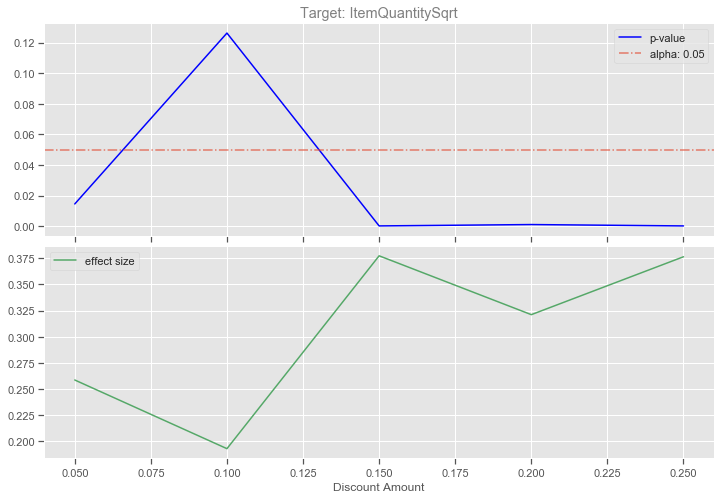

In [226]:
targets = ['ItemQuantity','ItemQuantityLog','ItemQuantitySqrt']
compare_groups(df2, 'DiscountGroup', targets, control_group=0.0, p_adjust=True)

As we can see, the tests come out with very similar results no matter which transformation we use. The results show a similar but slightly different story to the one that was shown using the total number of items in an order. There is a sweet spot between p-value and effect size again at the 0.15 discount group, but this time there is another peak in effect size at 0.25 discount. This difference compared to the grouped dataframe is likely caused by the fact that the WeightedDiscount values in the first dataframe were unlikely to be this high, and the itemized dataframe allowed for the effect of this discount group on individual item counts to shine. 

<a id='bootstrap2'></a>
#### Bootstrap Simulation

Performing bootstrap simulation for parameter: mean
Testing control group: 0.0


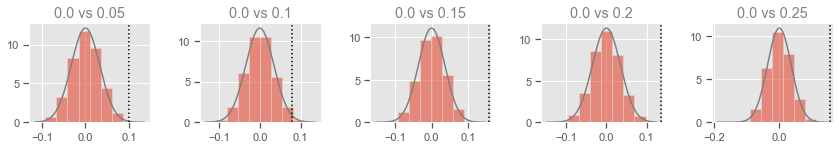

p-values adjusted for 5 group comparisons


0.05     0.10  0.15     0.20     0.25
p_val to 0.0  0.012  0.09975   0.0  0.00025  0.00025

In [227]:
# Running the simulation with 20000 trials per group
boot_results = bootstrap_sim(df2, 
                             feature='DiscountGroup', 
                             target='ItemQuantity4rt', 
                             control_groups=0.0,
                             num_trials=20000,
                             p_adjust=True,
                             show_hist=True,
                             #alternate='higher'
                            )
# Displaying calculated p-values from simulation
boot_results

We can see that the bootstrap simulation has produced results in line with our t-tests.

Performing bootstrap simulation for parameter: var
Testing control group: 0.0
Testing control group: 0.05
Testing control group: 0.1
Testing control group: 0.15
Testing control group: 0.2
Testing control group: 0.25


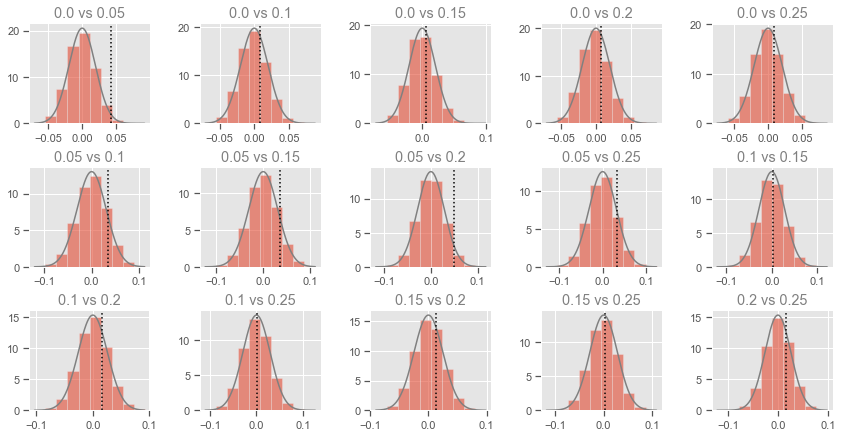

0.05     0.10     0.15     0.20     0.25
p_val to 0.0   0.0278  0.69355  0.79025  0.70535  0.67605
p_val to 0.05     NaN  0.26050  0.22935  0.07935  0.28565
p_val to 0.1      NaN      NaN  0.93530  0.55110  0.97775
p_val to 0.15     NaN      NaN      NaN  0.59765  0.91655
p_val to 0.2      NaN      NaN      NaN      NaN  0.53550

In [230]:
# Checking variance differences with bootstrap
# Running the simulation with 20000 trials per group
boot_results = bootstrap_sim(df2, 
                             feature='DiscountGroup', 
                             target='ItemQuantity4rt', 
                             #control_groups=0.0,
                             num_trials=20000,
                             param='var',
                             p_adjust=False,
                             show_hist=True,
                            )
# Displaying calculated p-values from simulation
boot_results

In [ ]:
# We can see that although the Brown & Forsythe, Bartlett, and Fligner-Killeen tests all
# did not reject the null hypothesis of equal variance among groups, the bootstrap simulation
# has produced results more in line with the pairwise Fischer tests, and shows a significant
# difference betwen the variances of the 0.05 group and control.

<a id='bayesian2'></a>
### Bayesian Approach

<a id='best2'></a>
#### Bayes Estimation

In [231]:
# I will now use pymc3 to compare each treatment group to the control group, and see the
# probabilities that it will generate for the null hypothesis in each comparison.

# Again, I will use the values from the whole dataset to form uninformed priors
σ_prior = df2.ItemQuantity4rt.std() * 2
µ_prior = df2.ItemQuantity4rt.mean()
σ_low = 0
σ_high = 10

#Setting target data
control_data = df2[df2.Discount == 0.0].ItemQuantity4rt
discount5_data = df2[df2.Discount == 0.05].ItemQuantity4rt
discount10_data = df2[df2.Discount == 0.1].ItemQuantity4rt
discount15_data = df2[df2.Discount == 0.15].ItemQuantity4rt
discount20_data = df2[df2.Discount == 0.2].ItemQuantity4rt
discount25_data = df2[df2.Discount == 0.25].ItemQuantity4rt

# Now to establish the statistical model with distributions for variables
with pm.Model() as model:
    # Modeling means
    control_mean = pm.Normal('Control mean', mu=µ_prior, sd=σ_prior)
    discount5_mean = pm.Normal('0.05 Discount mean', mu=µ_prior, sd=σ_prior)
    discount10_mean = pm.Normal('0.10 Discount mean', mu=µ_prior, sd=σ_prior)
    discount15_mean = pm.Normal('0.15 Discount mean', mu=µ_prior, sd=σ_prior)
    discount20_mean = pm.Normal('0.20 Discount mean', mu=µ_prior, sd=σ_prior)
    discount25_mean = pm.Normal('0.25 Discount mean', mu=µ_prior, sd=σ_prior)
    # Modeling stds
    control_std = pm.Uniform('Control std', lower=σ_low, upper=σ_high)
    discount5_std = pm.Uniform('0.05 Discount std', lower=σ_low, upper=σ_high)
    discount10_std = pm.Uniform('0.10 Discount std', lower=σ_low, upper=σ_high)
    discount15_std = pm.Uniform('0.15 Discount std', lower=σ_low, upper=σ_high)
    discount20_std = pm.Uniform('0.20 Discount std', lower=σ_low, upper=σ_high)
    discount25_std = pm.Uniform('0.25 Discount std', lower=σ_low, upper=σ_high)
    # Modeling v
    v = pm.Exponential('v_minus_one', 1/29.) + 1
    
    # PyMC3 uses precision rather than std for t-distributions, converting now:
    λ0 = control_std**-2
    λ1 = discount5_std**-2
    λ2 = discount10_std**-2
    λ3 = discount15_std**-2
    λ4 = discount20_std**-2
    λ5 = discount25_std**-2
    
    # Setting posteriors
    control = pm.StudentT('0.0 Discount', nu=v, mu=control_mean, lam=λ0, observed=control_data)
    discount5 = pm.StudentT('0.05 Discount', nu=v, mu=discount5_mean, lam=λ1, observed=discount5_data)
    discount10 = pm.StudentT('0.10 Discount', nu=v, mu=discount10_mean, lam=λ2, observed=discount10_data)
    discount15 = pm.StudentT('0.15 Discount', nu=v, mu=discount15_mean, lam=λ3, observed=discount15_data)
    discount20 = pm.StudentT('0.20 Discount', nu=v, mu=discount20_mean, lam=λ4, observed=discount20_data)
    discount25 = pm.StudentT('0.25 Discount', nu=v, mu=discount25_mean, lam=λ5, observed=discount25_data)
    
    # Setting deterministics:
    mean_diffs_5 = pm.Deterministic('0.05 Mean diffs', discount5_mean - control_mean)
    mean_diffs_10 = pm.Deterministic('0.10 Mean diffs', discount10_mean - control_mean)
    mean_diffs_15 = pm.Deterministic('0.15 Mean diffs', discount15_mean - control_mean)
    mean_diffs_20 = pm.Deterministic('0.20 Mean diffs', discount20_mean - control_mean)
    mean_diffs_25 = pm.Deterministic('0.25 Mean diffs', discount25_mean - control_mean)
    
    # std differences
    control_v_5_stds = pm.Deterministic('0% vs 5% std diff', discount5_std - control_std)
    control_v_10_stds = pm.Deterministic('0% vs 10% std diff', discount10_std - control_std)
    control_v_15_stds = pm.Deterministic('0% vs 15% std diff', discount15_std - control_std)
    control_v_20_stds = pm.Deterministic('0% vs 20% std diff', discount20_std - control_std)
    control_v_25_stds = pm.Deterministic('0% vs 25% std diff', discount25_std - control_std)
    # effect sizes
    control_v_5_effect = pm.Deterministic('0% vs 5% effect', 
                                   mean_diffs_5/np.sqrt((control_std**2+discount5_std**2)/2))
    control_v_10_effect = pm.Deterministic('0% vs 10% effect', 
                                   mean_diffs_10/np.sqrt((control_std**2+discount10_std**2)/2))
    control_v_15_effect = pm.Deterministic('0% vs 15% effect', 
                                   mean_diffs_15/np.sqrt((control_std**2+discount15_std**2)/2))
    control_v_20_effect = pm.Deterministic('0% vs 20% effect', 
                                   mean_diffs_20/np.sqrt((control_std**2+discount20_std**2)/2))
    control_v_25_effect = pm.Deterministic('0% vs 25% effect', 
                                   mean_diffs_25/np.sqrt((control_std**2+discount25_std**2)/2))

In [232]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_minus_one, 0.25 Discount std, 0.20 Discount std, 0.15 Discount std, 0.10 Discount std, 0.05 Discount std, Control std, 0.25 Discount mean, 0.20 Discount mean, 0.15 Discount mean, 0.10 Discount mean, 0.05 Discount mean, Control mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:20<00:00, 479.30draws/s]


In [241]:
# Generating summary of mean differences from simulation
pm.summary(trace,
           var_names=[
               '0.05 Mean diffs',
               '0.10 Mean diffs',
               '0.15 Mean diffs',
               '0.20 Mean diffs',
               '0.25 Mean diffs'
           ]
          )

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
0.05 Mean diffs  0.142  0.033   0.080    0.204        0.0      0.0   14991.0   
0.10 Mean diffs  0.079  0.035   0.016    0.146        0.0      0.0   13574.0   
0.15 Mean diffs  0.156  0.036   0.088    0.223        0.0      0.0   13945.0   
0.20 Mean diffs  0.136  0.036   0.066    0.199        0.0      0.0   15315.0   
0.25 Mean diffs  0.156  0.037   0.083    0.221        0.0      0.0   12051.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
0.05 Mean diffs  13483.0   14924.0    5704.0    1.0  
0.10 Mean diffs  11428.0   13510.0    6573.0    1.0  
0.15 Mean diffs  12768.0   13928.0    6162.0    1.0  
0.20 Mean diffs  13473.0   15338.0    6264.0    1.0  
0.25 Mean diffs  11016.0   12099.0    5575.0    1.0

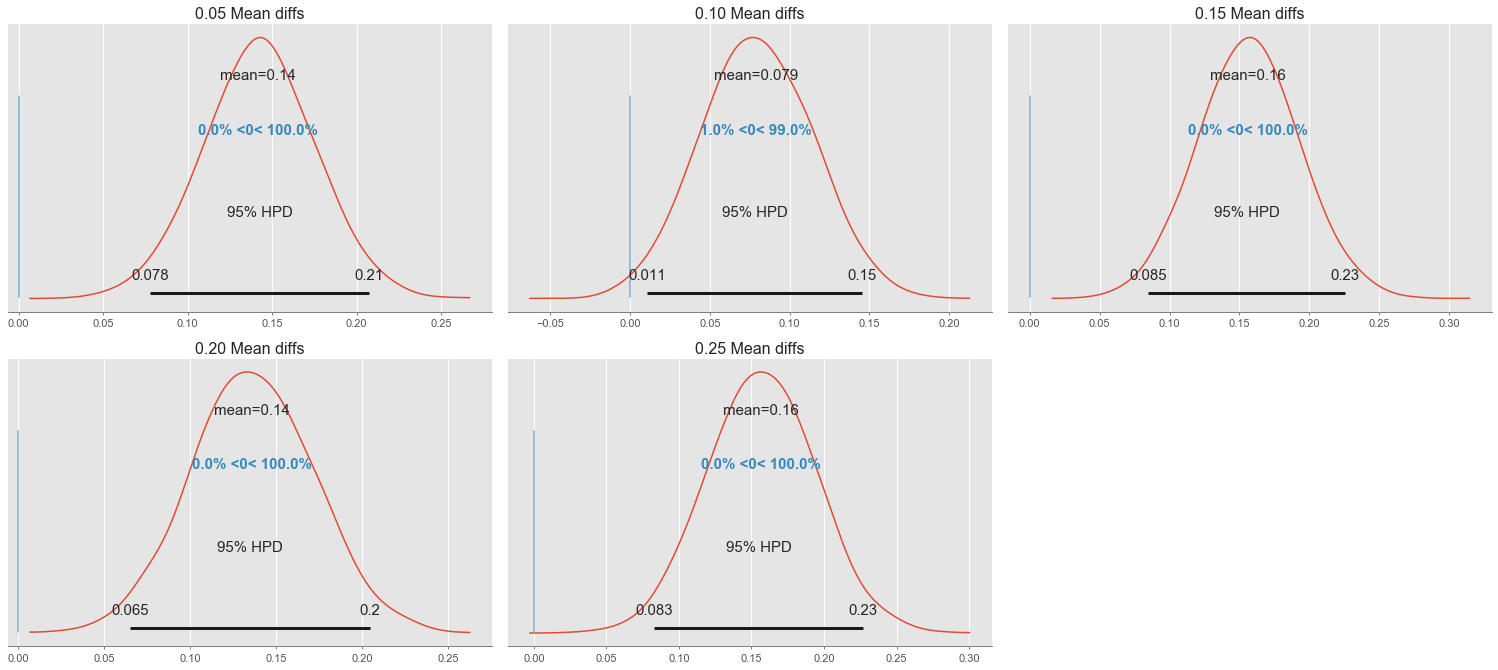

In [233]:
# We can see that each group has a positive effect, but that the 0.10 group is barely significant
# once an adjustment is made for multiple comparisons.
# Graphing the posteriors for variables
pm.plot_posterior(trace, var_names=['0.05 Mean diffs',
                                    '0.10 Mean diffs',
                                    '0.15 Mean diffs',
                                    '0.20 Mean diffs',
                                    '0.25 Mean diffs'
                                   ],
                 ref_val=0,
                 credible_interval=0.95);

In [237]:
# The Bayesian analysis is in line with our results from the frequentist approaches. If one
# were to adjust for the multiple comparison problem, then the 0.10 group would again become
# insignificant. We should look at the mean effect sizes from the simulation to see if the
# significance of the 0.10 group is even important.
pm.summary(trace, var_names=['0% vs 5% effect',
                                    '0% vs 10% effect',
                                    '0% vs 15% effect',
                                    '0% vs 20% effect',
                                    '0% vs 25% effect'
                                   ],
                 credible_interval=0.95)

mean     sd  hpd_2.5%  hpd_97.5%  mcse_mean  mcse_sd  \
0% vs 5% effect   0.337  0.079     0.183      0.497      0.001    0.000   
0% vs 10% effect  0.187  0.082     0.036      0.356      0.001    0.001   
0% vs 15% effect  0.371  0.086     0.208      0.543      0.001    0.001   
0% vs 20% effect  0.328  0.086     0.158      0.494      0.001    0.001   
0% vs 25% effect  0.370  0.088     0.200      0.545      0.001    0.001   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
0% vs 5% effect    15133.0  13547.0   15112.0    6528.0    1.0  
0% vs 10% effect   13654.0  11612.0   13593.0    6663.0    1.0  
0% vs 15% effect   13765.0  12793.0   13743.0    6144.0    1.0  
0% vs 20% effect   15187.0  13677.0   15170.0    6381.0    1.0  
0% vs 25% effect   12420.0  11545.0   12426.0    5518.0    1.0

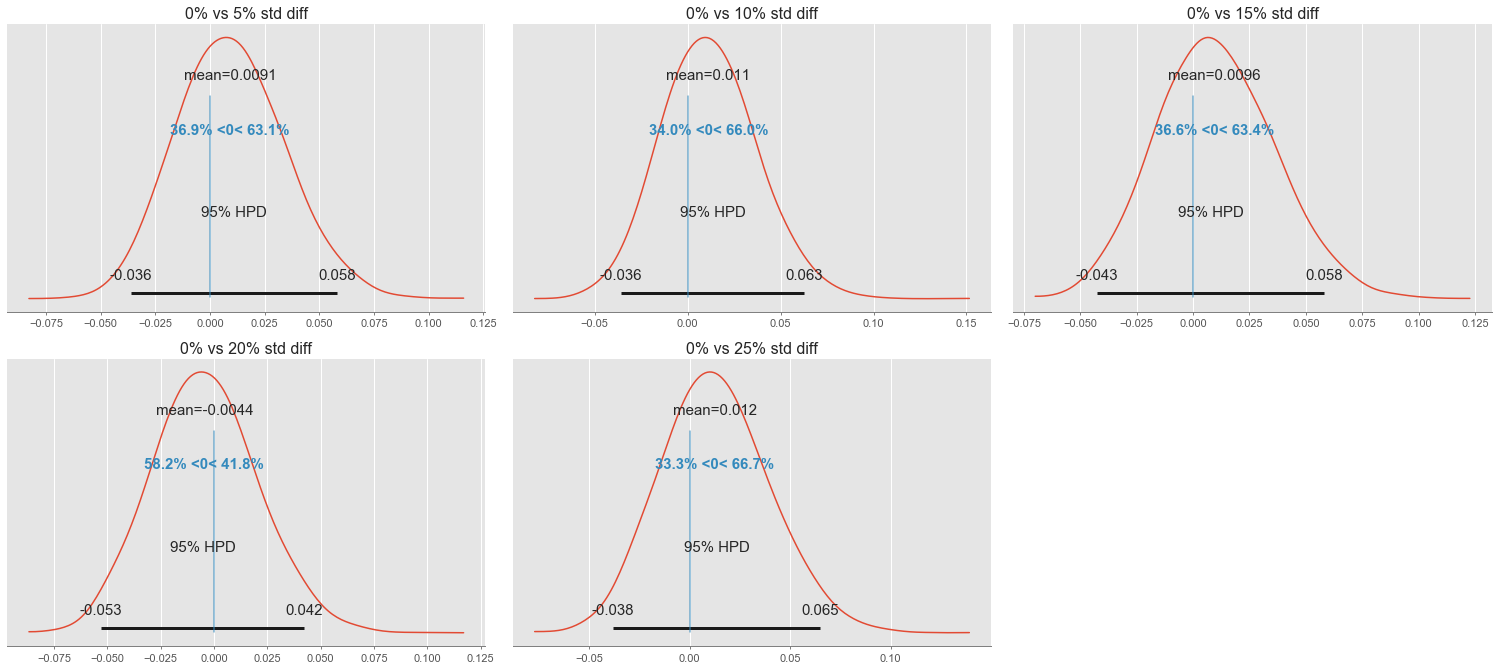

In [238]:
# Interested in seeing what the MCMC reveals about the variance relationships:
pm.plot_posterior(trace, var_names=['0% vs 5% std diff',
                                    '0% vs 10% std diff',
                                    '0% vs 15% std diff',
                                    '0% vs 20% std diff',
                                    '0% vs 25% std diff'
                                   ],
                 ref_val=0,
                 credible_interval=0.95);

In [ ]:
# Very interesting, again we have a disagreement between the bootstrap and MCMC simulation about
# whether groups have the same variance. I would trust the results of the MCMC more, since the 
# bootstrap is generating comparisons from random resampling, and the MCMC is generating a list
# of credible values for the model, which reveals a high probability density for a non-differnce

<a id='conclusions'></a>
# Conclusions:

In this notebook we have sought to investigate the effect of Discount on 3 different things:
1. Sales total for an order
2. Total number of items purchased per order
3. Quantity of a particular item
In regards to the first question, I have concluded that there is a significant increase in average sale total for orders that have an average discount of either 5% or 10% applied, and that any possible positive effects acheived from larger discounts than this are smaller and not statistically significant. I determined that when ignoring non-discounted orders, there was a statistically significant negative linear relationship between sales total for an order and the average discount level applied to that order, indicating that larger discount amounts lead to reduced returns.

Regarding the second inquiry, it was found that for all groups except the 0.25 average order discount group, there was a statistically significant positive effect acheived as a result of offering a discount. There was not determined to be any linear relationship of total items in an order and the actual discount amount applied when ignoring the non-discounted orders, meaning that once a discount is applied, there was no indication that higher discounts would lead to more overall liquidity. 

Investigating the third inquiry, I have concluded that all discount groups other than the 0.10 group showed a statistically significant positive effect on the average quantity of the individual items in orders. There was not a significant linear relationship found between the discount amount and item quantity when ignoring the control group, so it cannot neccessarily be said that a higher discount will lead to a higher item quantity. The largest effect size comes from the 0.15 group, followed closely by the 0.25 group. This was supported by the MCMC simulation. This means that if pure inventory liquidity is the goal, it is unneccessary to offer a discount over 15% on any given item in order to maximize bulk buying incentive, as further discount will only lead to lower revenue and not increase the average quantities ordered.

Overall, it was found that the %5 discount group outperformed the other groups in terms of revenue, and also had positive effects on the amount of items ordered. When it comes to increasing overall number of items purchased, either individually or across an entire order, the 0.15 discount group has the greatest positive effect, though it is not statistically higher than the effect gotten from the 0.05 discount group. Therefore, it is my overall suggestion that offering an average discount of 5% across an order will bring the best of both worlds in increasing revenue and liquidity. If pure liquidity is the goal, then an average discount of 15% is the right choice.



# Appendix I:

## Miscellaneous questions
First of all, what kind of products is this company selling?

In [242]:
cur.execute('''SELECT ProductName FROM Product;''')
products = pd.DataFrame(cur.fetchall())
products.columns = [x[0] for x in cur.description]
products.ProductName.unique()

array(['Chai', 'Chang', 'Aniseed Syrup', "Chef Anton's Cajun Seasoning",
       "Chef Anton's Gumbo Mix", "Grandma's Boysenberry Spread",
       "Uncle Bob's Organic Dried Pears", 'Northwoods Cranberry Sauce',
       'Mishi Kobe Niku', 'Ikura', 'Queso Cabrales',
       'Queso Manchego La Pastora', 'Konbu', 'Tofu', 'Genen Shouyu',
       'Pavlova', 'Alice Mutton', 'Carnarvon Tigers',
       'Teatime Chocolate Biscuits', "Sir Rodney's Marmalade",
       "Sir Rodney's Scones", "Gustaf's Knäckebröd", 'Tunnbröd',
       'Guaraná Fantástica', 'NuNuCa Nuß-Nougat-Creme',
       'Gumbär Gummibärchen', 'Schoggi Schokolade', 'Rössle Sauerkraut',
       'Thüringer Rostbratwurst', 'Nord-Ost Matjeshering',
       'Gorgonzola Telino', 'Mascarpone Fabioli', 'Geitost',
       'Sasquatch Ale', 'Steeleye Stout', 'Inlagd Sill', 'Gravad lax',
       'Côte de Blaye', 'Chartreuse verte', 'Boston Crab Meat',
       "Jack's New England Clam Chowder", 'Singaporean Hokkien Fried Mee',
       'Ipoh Coffee', 'Gula

Ok, we can see that they sell food items. How do they categorize these products?

In [243]:
cur.execute('''SELECT * FROM Product''')
cur.description

(('Id', None, None, None, None, None, None),
 ('ProductName', None, None, None, None, None, None),
 ('SupplierId', None, None, None, None, None, None),
 ('CategoryId', None, None, None, None, None, None),
 ('QuantityPerUnit', None, None, None, None, None, None),
 ('UnitPrice', None, None, None, None, None, None),
 ('UnitsInStock', None, None, None, None, None, None),
 ('UnitsOnOrder', None, None, None, None, None, None),
 ('ReorderLevel', None, None, None, None, None, None),
 ('Discontinued', None, None, None, None, None, None))

In [244]:
cur.execute('''SELECT p.Id, 
                      p.ProductName,
                      p.UnitPrice,
                      p.CategoryID, 
                      c.CategoryName,
                      c.Description
                      FROM Product p
                      JOIN Category c
                      ON p.CategoryID = c.Id''')
products = pd.DataFrame(cur.fetchall())
products.columns = [x[0] for x in cur.description]
products

Id                      ProductName  UnitPrice  CategoryId CategoryName  \
0    1                             Chai      18.00           1    Beverages   
1    2                            Chang      19.00           1    Beverages   
2    3                    Aniseed Syrup      10.00           2   Condiments   
3    4     Chef Anton's Cajun Seasoning      22.00           2   Condiments   
4    5           Chef Anton's Gumbo Mix      21.35           2   Condiments   
..  ..                              ...        ...         ...          ...   
72  73                       Röd Kaviar      15.00           8      Seafood   
73  74                    Longlife Tofu      10.00           7      Produce   
74  75             Rhönbräu Klosterbier       7.75           1    Beverages   
75  76                     Lakkalikööri      18.00           1    Beverages   
76  77  Original Frankfurter grüne Soße      13.00           2   Condiments   

                                          Description  
0         Soft drinks, coffees, teas, beers, and ales  
1         Soft drinks, coffees, teas, beers, and ales  
2   Sweet and savory sauces, relishes, spreads, an...  
3   Sweet and savory sauces, relishes, spreads, an...  
4   Sweet and savory sauces, relishes, spreads, an...  
..                                                ...  
72                                   Seaweed and fish  
73                          Dried fruit and bean curd  
74        Soft drinks, coffees, teas, beers, and ales  
75        Soft drinks, coffees, teas, beers, and ales  
76  Sweet and savory sauces, relishes, spreads, an...  

[77 rows x 6 columns]

In [245]:
products.CategoryName.value_counts()

Confections       13
Condiments        12
Seafood           12
Beverages         12
Dairy Products    10
Grains/Cereals     7
Meat/Poultry       6
Produce            5
Name: CategoryName, dtype: int64

In [246]:
# A quick look at the most expensive products offered
products.sort_values('UnitPrice' ,ascending=False).head(15)

Id                 ProductName  UnitPrice  CategoryId    CategoryName  \
37  38               Côte de Blaye     263.50           1       Beverages   
28  29     Thüringer Rostbratwurst     123.79           6    Meat/Poultry   
8    9             Mishi Kobe Niku      97.00           6    Meat/Poultry   
19  20      Sir Rodney's Marmalade      81.00           3     Confections   
17  18            Carnarvon Tigers      62.50           8         Seafood   
58  59        Raclette Courdavault      55.00           4  Dairy Products   
50  51       Manjimup Dried Apples      53.00           7         Produce   
61  62              Tarte au sucre      49.30           3     Confections   
42  43                 Ipoh Coffee      46.00           1       Beverages   
27  28           Rössle Sauerkraut      45.60           7         Produce   
26  27          Schoggi Schokolade      43.90           3     Confections   
62  63                Vegie-spread      43.90           2      Condiments   
7    8  Northwoods Cranberry Sauce      40.00           2      Condiments   
16  17                Alice Mutton      39.00           6    Meat/Poultry   
11  12   Queso Manchego La Pastora      38.00           4  Dairy Products   

                                          Description  
37        Soft drinks, coffees, teas, beers, and ales  
28                                     Prepared meats  
8                                      Prepared meats  
19                Desserts, candies, and sweet breads  
17                                   Seaweed and fish  
58                                            Cheeses  
50                          Dried fruit and bean curd  
61                Desserts, candies, and sweet breads  
42        Soft drinks, coffees, teas, beers, and ales  
27                          Dried fruit and bean curd  
26                Desserts, candies, and sweet breads  
62  Sweet and savory sauces, relishes, spreads, an...  
7   Sweet and savory sauces, relishes, spreads, an...  
16                                     Prepared meats  
11                                            Cheeses

In [247]:
# Checking column names for join
display(cur.execute('SELECT * FROM OrderDetail').description)
display(cur.execute('SELECT * FROM "Order"').description)

(('Id', None, None, None, None, None, None),
 ('OrderId', None, None, None, None, None, None),
 ('ProductId', None, None, None, None, None, None),
 ('UnitPrice', None, None, None, None, None, None),
 ('Quantity', None, None, None, None, None, None),
 ('Discount', None, None, None, None, None, None))

(('Id', None, None, None, None, None, None),
 ('CustomerId', None, None, None, None, None, None),
 ('EmployeeId', None, None, None, None, None, None),
 ('OrderDate', None, None, None, None, None, None),
 ('RequiredDate', None, None, None, None, None, None),
 ('ShippedDate', None, None, None, None, None, None),
 ('ShipVia', None, None, None, None, None, None),
 ('Freight', None, None, None, None, None, None),
 ('ShipName', None, None, None, None, None, None),
 ('ShipAddress', None, None, None, None, None, None),
 ('ShipCity', None, None, None, None, None, None),
 ('ShipRegion', None, None, None, None, None, None),
 ('ShipPostalCode', None, None, None, None, None, None),
 ('ShipCountry', None, None, None, None, None, None))

In [248]:
# I notice that the OrderDetail table seems to have an extra column 'Id' that is not shown on
# the schema, I will take both columns to see what the difference is to 'OrderId'
# Creating dataframe for tests
cur.execute('''SELECT od.Id,
                      od.OrderId,
                      od.ProductID,
                      p.ProductName,
                      od.UnitPrice,
                      p.UnitPrice AS UnitPriceProduct,
                      od.Discount,
                      od.Quantity AS ItemQuantity,
                      od.UnitPrice * od.Quantity * (1-od.Discount) AS ItemTotal,
                      p.CategoryID,
                      c.CategoryName,
                      p.ReorderLevel,
                      o.CustomerId,
                      cust.CompanyName AS CustomerName,
                      cust.Region AS CustomerRegion,
                      o.ShipRegion
                      FROM
                      OrderDetail od
                      JOIN Product p
                      ON od.ProductID = p.Id
                      JOIN Category c
                      ON p.CategoryID = c.Id
                      JOIN "Order" o
                      ON od.OrderId = o.Id
                      LEFT JOIN Customer cust
                      ON o.CustomerId = cust.Id
                      ;''')
prod_orders = pd.DataFrame(cur.fetchall())
prod_orders.columns = [x[0] for x in cur.description]
print(len(prod_orders))
prod_orders.head()

2155


Id  OrderId  ProductId                    ProductName  UnitPrice  \
0  10248/11    10248         11                 Queso Cabrales       14.0   
1  10248/42    10248         42  Singaporean Hokkien Fried Mee        9.8   
2  10248/72    10248         72         Mozzarella di Giovanni       34.8   
3  10249/14    10249         14                           Tofu       18.6   
4  10249/51    10249         51          Manjimup Dried Apples       42.4   

   UnitPriceProduct  Discount  ItemQuantity  ItemTotal  CategoryId  \
0             21.00       0.0            12      168.0           4   
1             14.00       0.0            10       98.0           5   
2             34.80       0.0             5      174.0           4   
3             23.25       0.0             9      167.4           7   
4             53.00       0.0            40     1696.0           7   

     CategoryName  ReorderLevel CustomerId               CustomerName  \
0  Dairy Products            30      VINET  Vins et alcools Chevalier   
1  Grains/Cereals             0      VINET  Vins et alcools Chevalier   
2  Dairy Products             0      VINET  Vins et alcools Chevalier   
3         Produce             0      TOMSP         Toms Spezialitäten   
4         Produce            10      TOMSP         Toms Spezialitäten   

   CustomerRegion      ShipRegion  
0  Western Europe  Western Europe  
1  Western Europe  Western Europe  
2  Western Europe  Western Europe  
3  Western Europe  Western Europe  
4  Western Europe  Western Europe

Right away I am seeing some disagreement between the UnitPrice columns from the OrderDetail table and the Product table. I am assuming that this means the values from the Product table are more of an "MSRP" listed price, and the values from the OrderDetail table are what was actually charged. I included the Discount column to make sure that the discount was not being applied prior to storing the UnitPrice data, showing this is not the case. I will make comparisons using the prices which are actually charged in the orders.

In [249]:
# I am curious why the left join was necessary to prevent the DataFrame size from being reduced
# when I added the CustomerName feature.
print(prod_orders.CustomerId.nunique(), prod_orders.CustomerName.nunique())
cur.execute('''SELECT Id, CompanyName from Customer''')
customers = pd.DataFrame(cur.fetchall())
customers.columns = [x[0] for x in cur.description]

89 85


In [250]:
# I can see above that there are 4 more unique CustomerIds being produced than there are
# CustomerNames being generated in the JOIN. A look now at how many unique customers are in the
# Customer table
print("Number of unique CustomerIDs in Customer table:", customers.Id.nunique())
print("Number of unique Customer Names in Customer table:", customers.CompanyName.nunique())

Number of unique CustomerIDs in Customer table: 91
Number of unique Customer Names in Customer table: 91


In [251]:
# Trying to find the 4 CustomerId values which are not correpsonding to a CompanyName
prod_orders[~prod_orders.CustomerId.isin(customers.Id)].CustomerId.value_counts()

QUEE    40
ANTO    17
OCEA    11
DUMO     9
Name: CustomerId, dtype: int64

In [252]:
customers.Id.unique()

array(['ALFKI', 'ANATR', 'ANTON', 'AROUT', 'BERGS', 'BLAUS', 'BLONP',
       'BOLID', 'BONAP', 'BOTTM', 'BSBEV', 'CACTU', 'CENTC', 'CHOPS',
       'COMMI', 'CONSH', 'DRACD', 'DUMON', 'EASTC', 'ERNSH', 'FAMIA',
       'FISSA', 'FOLIG', 'FOLKO', 'FRANK', 'FRANR', 'FRANS', 'FURIB',
       'GALED', 'GODOS', 'GOURL', 'GREAL', 'GROSR', 'HANAR', 'HILAA',
       'HUNGC', 'HUNGO', 'ISLAT', 'KOENE', 'LACOR', 'LAMAI', 'LAUGB',
       'LAZYK', 'LEHMS', 'LETSS', 'LILAS', 'LINOD', 'LONEP', 'MAGAA',
       'MAISD', 'MEREP', 'MORGK', 'NORTS', 'OCEAN', 'OLDWO', 'OTTIK',
       'PARIS', 'PERIC', 'PICCO', 'PRINI', 'QUEDE', 'QUEEN', 'QUICK',
       'RANCH', 'RATTC', 'REGGC', 'RICAR', 'RICSU', 'ROMEY', 'SANTG',
       'SAVEA', 'SEVES', 'SIMOB', 'SPECD', 'SPLIR', 'SUPRD', 'THEBI',
       'THECR', 'TOMSP', 'TORTU', 'TRADH', 'TRAIH', 'VAFFE', 'VICTE',
       'VINET', 'WANDK', 'WARTH', 'WELLI', 'WHITC', 'WILMK', 'WOLZA'],
      dtype=object)

In [253]:
customers.set_index('Id', inplace=True)

In [254]:
# It appears that these 4 CustomerIDs may have been recorded with error, since when we look at 
# the list of unique Ids from the Customer table we can see CustomerIds that closely resemble
# each of the 4 noncompliers, with one letter missing from the end of each. I will go through
# and fix these variables
prod_orders.CustomerId.replace({'DUMO':'DUMON',
                               'ANTO':'ANTON',
                               'OCEA':'OCEAN',
                               'QUEE':'QUEEN'}, inplace=True)

In [255]:
prod_orders['CustomerName'] = prod_orders.CustomerId.map(lambda x: customers.loc[x].CompanyName)
prod_orders.head()

Id  OrderId  ProductId                    ProductName  UnitPrice  \
0  10248/11    10248         11                 Queso Cabrales       14.0   
1  10248/42    10248         42  Singaporean Hokkien Fried Mee        9.8   
2  10248/72    10248         72         Mozzarella di Giovanni       34.8   
3  10249/14    10249         14                           Tofu       18.6   
4  10249/51    10249         51          Manjimup Dried Apples       42.4   

   UnitPriceProduct  Discount  ItemQuantity  ItemTotal  CategoryId  \
0             21.00       0.0            12      168.0           4   
1             14.00       0.0            10       98.0           5   
2             34.80       0.0             5      174.0           4   
3             23.25       0.0             9      167.4           7   
4             53.00       0.0            40     1696.0           7   

     CategoryName  ReorderLevel CustomerId               CustomerName  \
0  Dairy Products            30      VINET  Vins et alcools Chevalier   
1  Grains/Cereals             0      VINET  Vins et alcools Chevalier   
2  Dairy Products             0      VINET  Vins et alcools Chevalier   
3         Produce             0      TOMSP         Toms Spezialitäten   
4         Produce            10      TOMSP         Toms Spezialitäten   

   CustomerRegion      ShipRegion  
0  Western Europe  Western Europe  
1  Western Europe  Western Europe  
2  Western Europe  Western Europe  
3  Western Europe  Western Europe  
4  Western Europe  Western Europe

In [256]:
print("Number of unique CustomerIDs in dataframe:", prod_orders.CustomerId.nunique())
print("Number of unique Customer Names in dataframe:", prod_orders.CustomerName.nunique())

Number of unique CustomerIDs in dataframe: 89
Number of unique Customer Names in dataframe: 89


Excellent, that has fixed the inconsistencies.

I am interested in trying to maximize the sales totals, so I want to see what kind of impacts different features might have on ItemTotal, which has ItemQuantity imlicitly built into itself. Using this for a target variable should allow me to find conditions that improve overall OrderTotal and ItemCount at the same time.

Variable: ItemTotal
Normality Test Results for ['ItemTotal']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 ItemTotal 
 Statistic 
 0.999999 
 0.470413 
 
 
 p-value 
 0.000000 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 ItemTotal 
 266.648878 
 0.786

count     2155.000000
mean       587.374960
std        969.224235
min          4.800000
25%        147.000000
50%        337.750000
75%        656.000000
max      15810.000000
Name: ItemTotal, dtype: float64

Skew: 7.044127680744366


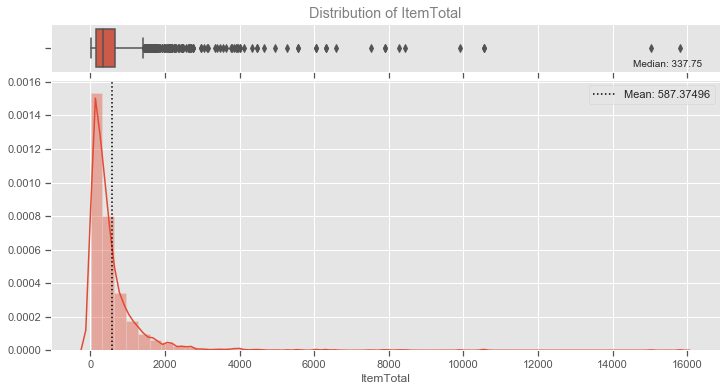

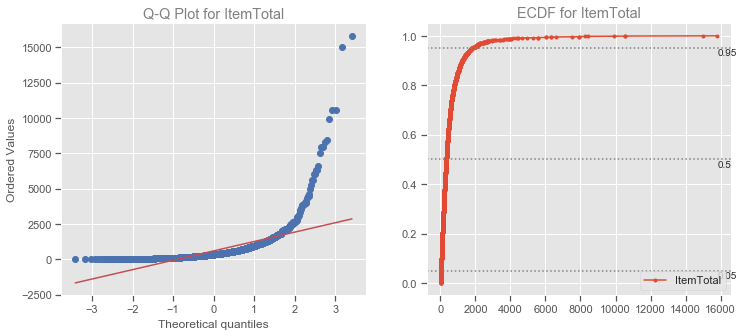

(                          K-S  Shapiro-Wilk
 ItemTotal Statistic  0.999999      0.470413
           p-value    0.000000      0.000000,             statistic  critical
 ItemTotal  266.648878     0.786)

In [257]:
# Visualizing ItemTotal
visualize_distribution(prod_orders, ['ItemTotal'])

In [258]:
# I can see that the data are heavily skewed, with some huge outlers.
# I want to take a look at these outliers
prod_orders.sort_values(by='ItemTotal', ascending=False).head(15)

Id  OrderId  ProductId              ProductName  UnitPrice  \
1893  10981/38    10981         38            Côte de Blaye     263.50   
1620  10865/38    10865         38            Côte de Blaye     263.50   
449   10417/38    10417         38            Côte de Blaye     210.80   
1678  10889/38    10889         38            Côte de Blaye     263.50   
1698  10897/29    10897         29  Thüringer Rostbratwurst     123.79   
281   10353/38    10353         38            Côte de Blaye     210.80   
471   10424/38    10424         38            Côte de Blaye     210.80   
782   10540/38    10540         38            Côte de Blaye     263.50   
1486  10817/38    10817         38            Côte de Blaye     263.50   
1483  10816/38    10816         38            Côte de Blaye     263.50   
2027  11032/38    11032         38            Côte de Blaye     263.50   
331   10372/38    10372         38            Côte de Blaye     210.80   
613   10479/38    10479         38            Côte de Blaye     210.80   
1986  11017/59    11017         59     Raclette Courdavault      55.00   
1391  10776/51    10776         51    Manjimup Dried Apples      53.00   

      UnitPriceProduct  Discount  ItemQuantity  ItemTotal  CategoryId  \
1893            263.50      0.00            60   15810.00           1   
1620            263.50      0.05            60   15019.50           1   
449             263.50      0.00            50   10540.00           1   
1678            263.50      0.00            40   10540.00           1   
1698            123.79      0.00            80    9903.20           6   
281             263.50      0.20            50    8432.00           1   
471             263.50      0.20            49    8263.36           1   
782             263.50      0.00            30    7905.00           1   
1486            263.50      0.00            30    7905.00           1   
1483            263.50      0.05            30    7509.75           1   
2027            263.50      0.00            25    6587.50           1   
331             263.50      0.25            40    6324.00           1   
613             263.50      0.00            30    6324.00           1   
1986             55.00      0.00           110    6050.00           4   
1391             53.00      0.05           120    6042.00           7   

        CategoryName  ReorderLevel CustomerId                  CustomerName  \
1893       Beverages            15      HANAR                 Hanari Carnes   
1620       Beverages            15      QUICK                    QUICK-Stop   
449        Beverages            15      SIMOB                 Simons bistro   
1678       Beverages            15      RATTC    Rattlesnake Canyon Grocery   
1698    Meat/Poultry             0      HUNGO  Hungry Owl All-Night Grocers   
281        Beverages            15      PICCO              Piccolo und mehr   
471        Beverages            15      MEREP                Mère Paillarde   
782        Beverages            15      QUICK                    QUICK-Stop   
1486       Beverages            15      KOENE               Königlich Essen   
1483       Beverages            15      GREAL       Great Lakes Food Market   
2027       Beverages            15      WHITC          White Clover Markets   
331        Beverages            15      QUEEN                 Queen Cozinha   
613        Beverages            15      RATTC    Rattlesnake Canyon Grocery   
1986  Dairy Products             0      ERNSH                  Ernst Handel   
1391         Produce            10      ERNSH                  Ernst Handel   

       CustomerRegion       ShipRegion  
1893    South America    South America  
1620   Western Europe   Western Europe  
449   Northern Europe  Northern Europe  
1678    North America    North America  
1698    British Isles    British Isles  
281    Western Europe   Western Europe  
471     North America    North America  
782    Western Europe   Western Europe  
1486   Western Europe   

Showing stats for ItemTotal grouped by CategoryName


Mean   Median          Std  Size
Beverages       663.040050  251.550  1685.811331   404
Condiments      490.958727  340.625   462.281963   216
Confections     501.069536  321.000   618.259773   334
Dairy Products  640.730287  436.350   691.701096   366
Grains/Cereals  488.492793  374.300   531.827940   196
Meat/Poultry    942.325777  472.000  1296.746872   173
Produce         735.180735  511.300   768.655001   136
Seafood         397.762841  287.100   426.114617   330

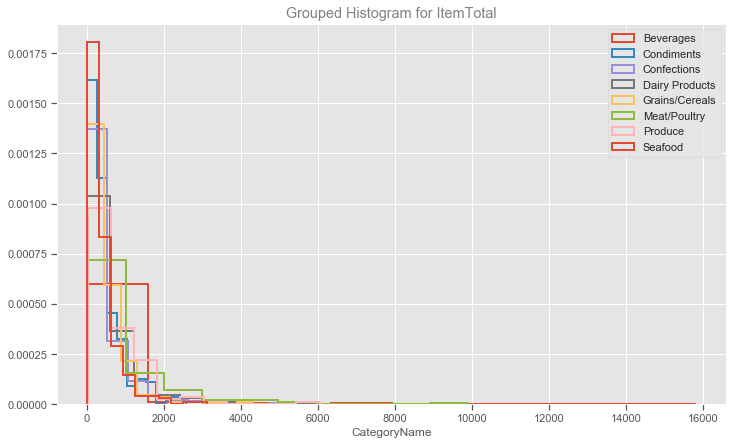

In [259]:
# I can see that these large outliers are well divied up across different customers, but they
# do mostly seem to be from the Beverages category, because of one very expensive product
# A look at item totals in orders grouped by Product category
group_stats = group_hist(prod_orders, 'CategoryName', 'ItemTotal');

In [260]:
# A couple of important things to notice here are that the means already seem to be significantly
# different, which will need testing. Also, some categories have higher means but less frequent
# orders made, as indicated in the size column above. For instance, meat and poultry has the 
# highest mean, but the smallest number of orders from this group. Beverages and Dairy Products
# seem to have the highest means along with frequent orders. I am going to visualize each 
# group with it's average item total, order frequency, and overall sales proportion to try
# and get some more insight

Showing stats for ItemTotal grouped by CategoryName


Mean   Median          Std  Size
Beverages       663.040050  251.550  1685.811331   404
Condiments      490.958727  340.625   462.281963   216
Confections     501.069536  321.000   618.259773   334
Dairy Products  640.730287  436.350   691.701096   366
Grains/Cereals  488.492793  374.300   531.827940   196
Meat/Poultry    942.325777  472.000  1296.746872   173
Produce         735.180735  511.300   768.655001   136
Seafood         397.762841  287.100   426.114617   330

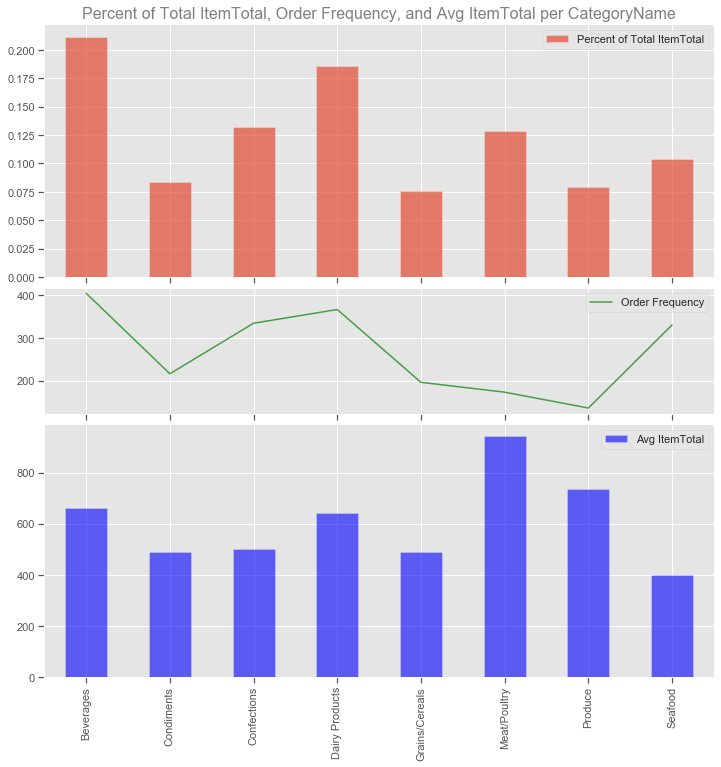

In [261]:
explore_groups(prod_orders, 'CategoryName', 'ItemTotal');

Showing stats for ItemTotal grouped by ProductName


Mean   Median         Std  Size
Alice Mutton                      883.740000   702.00  751.333485    37
Aniseed Syrup                     253.666667   220.00  169.484423    12
Boston Crab Meat                  436.844634   368.00  372.764693    41
Camembert Pierrot                 918.146667   693.60  696.267707    51
Carnarvon Tigers                 1080.439815  1050.00  667.274383    27
...                                      ...      ...         ...   ...
Uncle Bob's Organic Dried Pears   760.148276   540.00  661.185411    29
Valkoinen suklaa                  343.768750   341.25  156.836798    10
Vegie-spread                      982.417353   878.00  687.838329    17
Wimmers gute Semmelknödel         731.932250   665.00  776.362667    30
Zaanse koeken                     188.480000   171.00  113.694800    21

[77 rows x 4 columns]

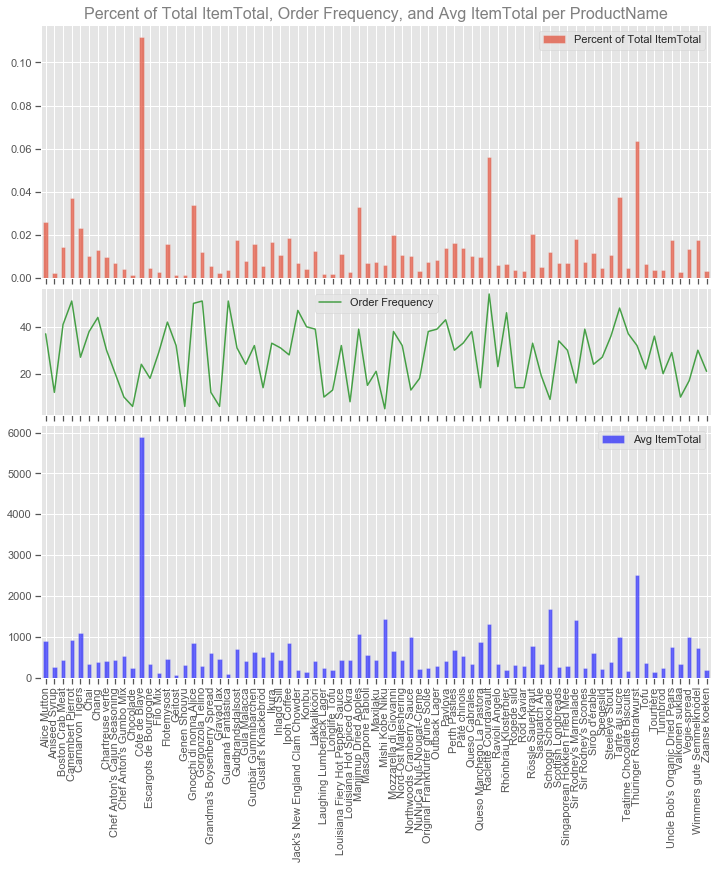

In [262]:
# using the same function but grouping by ProductName rather than CategoryName
group_stats = explore_groups(prod_orders, 'ProductName', 'ItemTotal')

This is quite informative. It appears as though over 11% of this company's revenue is coming from a single product, the Cote de Blaye beverage. The next 2 most lucrative products are the Thuringer Rostbratwurst (meat) and Raclette Courdavault (cheese).

Showing stats for ItemTotal grouped by CustomerRegion


Mean   Median          Std  Size
British Isles    573.427447  354.500   944.869689   190
Central America  301.056364  196.800   539.362443    55
Eastern Europe   220.746875  190.000   163.075679    16
North America    692.695317  379.950  1092.962510   427
Northern Europe  609.483654  300.000  1073.633574   143
Scandinavia      350.645750  259.875   353.425343    70
South America    469.334895  288.750   979.863294   304
Southern Europe  330.114726  207.000   387.244233   137
Western Europe   684.169033  416.120  1018.954073   736

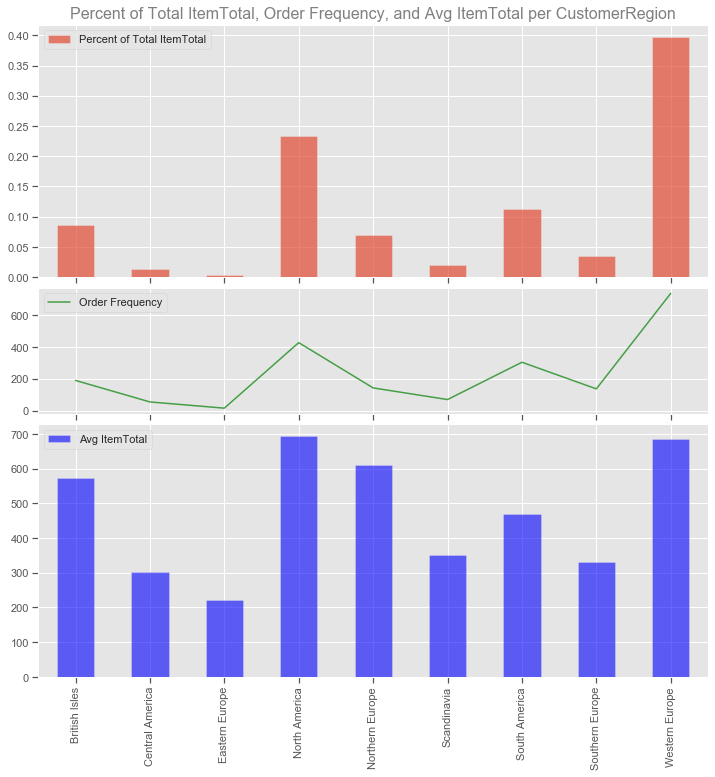

Mean   Median          Std  Size  \
British Isles    573.427447  354.500   944.869689   190   
Central America  301.056364  196.800   539.362443    55   
Eastern Europe   220.746875  190.000   163.075679    16   
North America    692.695317  379.950  1092.962510   427   
Northern Europe  609.483654  300.000  1073.633574   143   
Scandinavia      350.645750  259.875   353.425343    70   
South America    469.334895  288.750   979.863294   304   
Southern Europe  330.114726  207.000   387.244233   137   
Western Europe   684.169033  416.120  1018.954073   736   

                 Percent of Total ItemTotal  
British Isles                      0.086073  
Central America                    0.013081  
Eastern Europe                     0.002790  
North America                      0.233672  
Northern Europe                    0.068855  
Scandinavia                        0.019391  
South America                      0.112718  
Southern Europe                    0.035729  
Western Europe                     0.397813

In [293]:
explore_groups(prod_orders, 'CustomerRegion', 'ItemTotal')

Showing stats for UnitPrice grouped by CategoryName


Mean  Median        Std  Size
Beverages       29.236757   15.00  55.596543   404
Condiments      21.320833   19.45   9.239453   216
Confections     22.602695   14.00  17.905647   334
Dairy Products  26.983060   27.80  14.407963   366
Grains/Cereals  21.246429   19.50  11.461189   196
Meat/Poultry    42.874740   31.20  38.617256   173
Produce         35.194485   36.40  14.079622   136
Seafood         19.062970   15.00  14.248382   330

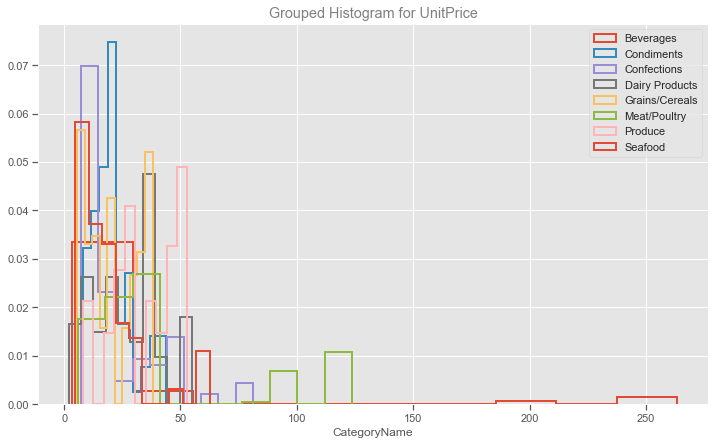

In [294]:
# A look at how the product category prices compare to one another
group_hist(prod_orders, 'CategoryName', 'UnitPrice');

In [295]:
# Looks like the beverage group has some large outliers
groups = prod_orders[prod_orders.CategoryName == 'Beverages'].sort_values(ascending=False,
                                                                by='UnitPrice').groupby('ProductName')
groups.head()

Id  OrderId  ProductId                ProductName  UnitPrice  \
1678  10889/38    10889         38              Côte de Blaye     263.50   
971   10616/38    10616         38              Côte de Blaye     263.50   
2027  11032/38    11032         38              Côte de Blaye     263.50   
1403  10783/38    10783         38              Côte de Blaye     263.50   
1459  10805/38    10805         38              Côte de Blaye     263.50   
2002  11023/43    11023         43                Ipoh Coffee      46.00   
1207  10706/43    10706         43                Ipoh Coffee      46.00   
2067  11052/43    11052         43                Ipoh Coffee      46.00   
1352  10760/43    10760         43                Ipoh Coffee      46.00   
1751  10923/43    10923         43                Ipoh Coffee      46.00   
1667   10885/2    10885          2                      Chang      19.00   
1586   10852/2    10852          2                      Chang      19.00   
958    10611/2    10611          2                      Chang      19.00   
1596   10856/2    10856          2                      Chang      19.00   
2112   11070/2    11070          2                      Chang      19.00   
1764  10927/76    10927         76               Lakkalikööri      18.00   
1009  10630/76    10630         76               Lakkalikööri      18.00   
1248  10720/35    10720         35             Steeleye Stout      18.00   
1052  10647/39    10647         39           Chartreuse verte      18.00   
1633  10870/35    10870         35             Steeleye Stout      18.00   
1005   10628/1    10628          1                       Chai      18.00   
853   10566/76    10566         76               Lakkalikööri      18.00   
993   10623/35    10623         35             Steeleye Stout      18.00   
1655  10879/76    10879         76               Lakkalikööri      18.00   
1701  10899/39    10899         39           Chartreuse verte      18.00   
1766  10928/76    10928         76               Lakkalikööri      18.00   
818   10553/35    10553         35             Steeleye Stout      18.00   
1783   10935/1    10935          1                       Chai      18.00   
1158   10689/1    10689          1                       Chai      18.00   
810   10551/35    10551         35             Steeleye Stout      18.00   
1161   10691/1    10691          1                       Chai      18.00   
1047   10646/1    10646          1                       Chai      18.00   
1621  10865/39    10865         39           Chartreuse verte      18.00   
1087  10661/39    10661         39           Chartreuse verte      18.00   
1693  10895/39    10895         39           Chartreuse verte      18.00   
1211  10707/70    10707         70              Outback Lager      15.00   
1187  10698/70    10698         70              Outback Lager      15.00   
1603  10858/70    10858         70              Outback Lager      15.00   
1396  10780/70    10780         70              Outback Lager      15.00   
1503  10824/70    10824         70              Outback Lager      15.00   
1619  10864/67    10864         67  Laughing Lumberjack Lager      14.00   
1917  10990/34    10990         34              Sasquatch Ale      14.00   
1964  11008/34    11008         34              Sasquatch Ale      14.00   
2105  11066/34    11066         34              Sasquatch Ale      14.00   
2073  11054/67    11054         67  Laughing Lumberjack Lager      14.00   
1794  10939/67    10939         67  Laughing Lumberjack Lager      14.00   
1788  10937/34    10937         34              Sasquatch Ale      14.00   
1752  10923/67    10923         67  Laughing Lumberjack Lager      14.00   
1725  10911/67    10911         67  Laughing Lumberjack Lager      14.00   
1680  10890/34    10890         34              Sasquatch Ale      14.00   
813   10552/75    10552         75       Rhönbräu Klosterbier       7.75   
1492  10819/75    10819         75       Rhönbräu Klosterbie

In [296]:
cur.execute('''SELECT * FROM Region;''')
regions = pd.DataFrame(cur.fetchall())
regions.columns = [x[0] for x in cur.description]
regions.head()

Id RegionDescription
0   1           Eastern
1   2           Western
2   3          Northern
3   4          Southern

Showing stats for OrderTotal4rt grouped by CustomerRegion


Mean    Median       Std  Size
British Isles    5.587808  5.585477  1.357728    74
Central America  4.938898  4.819454  1.115822    21
Eastern Europe   4.655020  4.628638  0.577495     7
North America    5.818347  5.897543  1.505085   146
Northern Europe  5.689632  5.689718  1.387360    54
Scandinavia      5.170519  5.001834  0.986739    28
South America    5.281371  5.383096  1.184675   126
Southern Europe  4.636276  4.713459  1.347655    64
Western Europe   5.883018  5.970559  1.407797   265

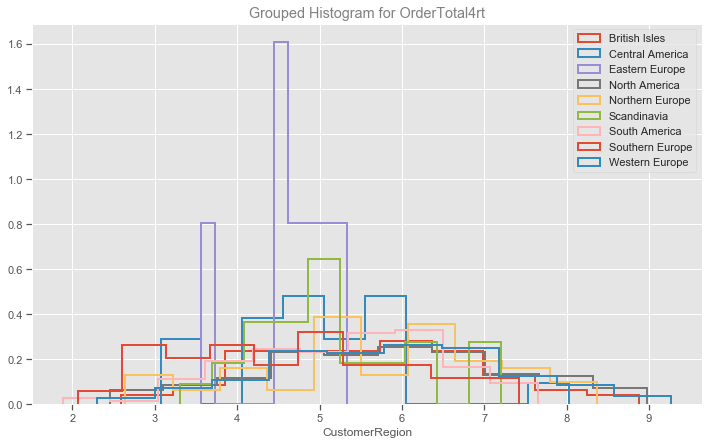

Showing stats for ItemCount4rt grouped by CustomerRegion


Mean    Median       Std  Size
British Isles    2.628073  2.665747  0.517929    74
Central America  2.305342  2.320596  0.342968    21
Eastern Europe   2.208090  2.300327  0.468620     7
North America    2.716987  2.753526  0.621143   146
Northern Europe  2.680536  2.783158  0.477842    54
Scandinavia      2.367123  2.369013  0.423559    28
South America    2.544916  2.604291  0.463874   126
Southern Europe  2.224987  2.300327  0.525649    64
Western Europe   2.746359  2.710806  0.567446   265

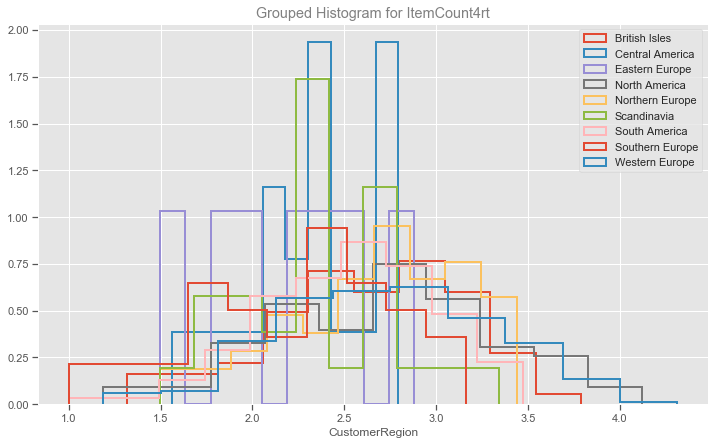

In [297]:
for target in ['OrderTotal4rt','ItemCount4rt']:
    group_hist(tukey_df, 'CustomerRegion', target)

In [268]:
tukey_df.OrderDate.head(15)

0     2012-07-04
1     2012-07-05
2     2012-07-08
3     2012-07-08
4     2012-07-09
5     2012-07-10
6     2012-07-11
7     2012-07-12
8     2012-07-15
9     2012-07-16
10    2012-07-17
11    2012-07-18
12    2012-07-19
13    2012-07-19
14    2012-07-22
Name: OrderDate, dtype: object

In [269]:
# Looking at sales by month
tukey_df['OrderMonth'] = tukey_df.OrderDate.map(lambda x: x.split('-')[1])
tukey_df.OrderMonth.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    07
1    07
2    07
3    07
4    07
Name: OrderMonth, dtype: object

Showing stats for OrderTotal grouped by OrderMonth


Mean     Median          Std  Size
01  1393.678340   967.8190  1197.429455    81
02  1269.056433   851.2000  1376.334876    75
03  1155.517268   799.2000  1045.793957    97
04  1360.202725   867.8625  1361.694808   100
05  1377.268821   937.3750  1244.338857    42
06  1182.096638   890.0000   832.754428    29
07  1452.939861   938.2500  1525.944646    54
08  1228.263289  1170.3750  1066.408502    57
09  1441.144682  1050.6000  1365.933463    55
10  1508.139532  1179.6000  1295.591476    62
11  1407.868286  1093.2000  1391.678052    56
12  1375.273747  1193.0100  1187.081219    77

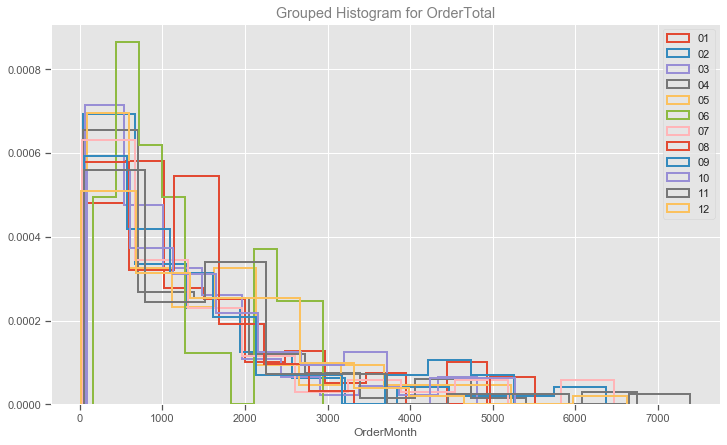

In [270]:
group_stats = group_hist(tukey_df, 'OrderMonth', 'OrderTotal')

Showing stats for OrderTotal grouped by OrderMonth


Mean     Median          Std  Size
01  1393.678340   967.8190  1197.429455    81
02  1269.056433   851.2000  1376.334876    75
03  1155.517268   799.2000  1045.793957    97
04  1360.202725   867.8625  1361.694808   100
05  1377.268821   937.3750  1244.338857    42
06  1182.096638   890.0000   832.754428    29
07  1452.939861   938.2500  1525.944646    54
08  1228.263289  1170.3750  1066.408502    57
09  1441.144682  1050.6000  1365.933463    55
10  1508.139532  1179.6000  1295.591476    62
11  1407.868286  1093.2000  1391.678052    56
12  1375.273747  1193.0100  1187.081219    77

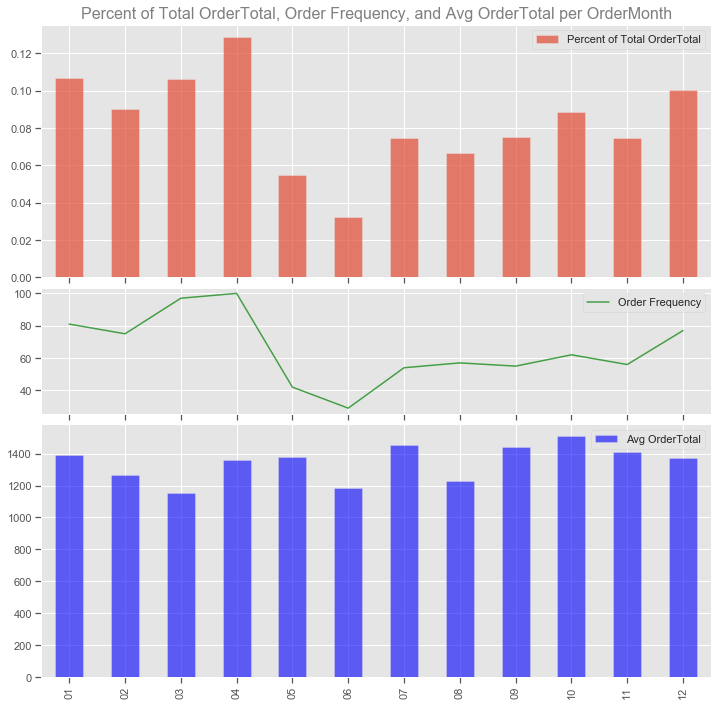

In [271]:
explore_groups(tukey_df, 'OrderMonth', 'OrderTotal');

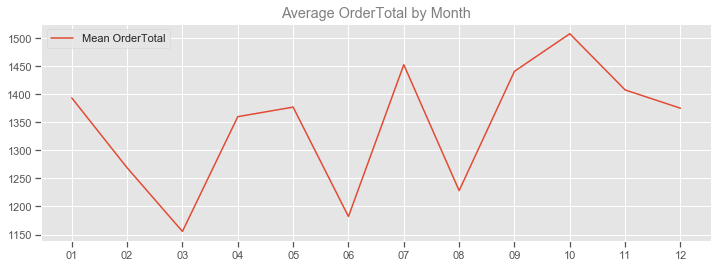

In [272]:
xs = list(group_stats.index)
ys = group_stats.Mean
plt.figure(figsize=(12,4))
plt.plot(xs,ys,label='Mean OrderTotal')
plt.legend()
plt.title('Average OrderTotal by Month', color='gray');

Showing stats for OrderTotal grouped by EmployeeId


Mean     Median          Std  Size
1  1460.128662  1044.5800  1292.198336   120
2  1335.655056   970.4400  1192.420121    90
3  1270.814475  1085.8500  1146.030395   118
4  1394.797640  1021.8725  1285.941886   150
5  1453.204451   923.8750  1390.669905    41
6  1094.034250   782.0000   942.655473    64
7  1403.013042   773.4250  1506.058476    60
8  1199.642175   814.5000  1070.598190   100
9  1569.715869   982.4095  1721.404649    42

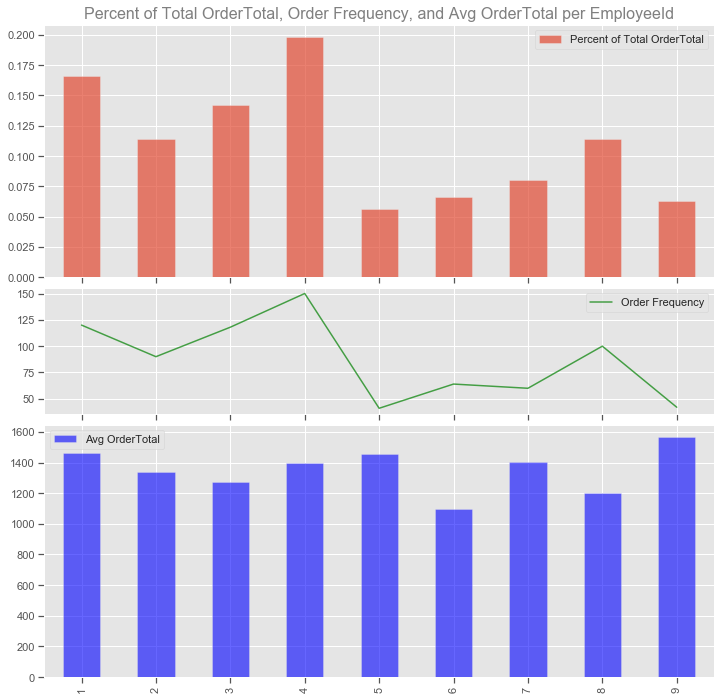

Mean     Median          Std  Size  Percent of Total OrderTotal
1  1460.128662  1044.5800  1292.198336   120                     0.166196
2  1335.655056   970.4400  1192.420121    90                     0.114021
3  1270.814475  1085.8500  1146.030395   118                     0.142237
4  1394.797640  1021.8725  1285.941886   150                     0.198449
5  1453.204451   923.8750  1390.669905    41                     0.056514
6  1094.034250   782.0000   942.655473    64                     0.066414
7  1403.013042   773.4250  1506.058476    60                     0.079847
8  1199.642175   814.5000  1070.598190   100                     0.113789
9  1569.715869   982.4095  1721.404649    42                     0.062534

In [273]:
explore_groups(tukey_df, 'EmployeeId', 'OrderTotal')

In [274]:
# Over how many years is the data taken?
tukey_df['OrderYear'] = tukey_df.OrderDate.map(lambda x: x.split('-')[0])
tukey_df.OrderYear.unique()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array(['2012', '2013', '2014'], dtype=object)

In [275]:
# A look at average sale totals by year:
group_hist(tukey_df, 'OrderYear', 'OrderTotal4rt');

Showing stats for OrderTotal4rt grouped by OrderYear


Mean    Median       Std  Size
2012  5.525928  5.698507  1.372306   148
2013  5.617924  5.619191  1.405288   385
2014  5.522734  5.416446  1.432629   252

Showing stats for OrderTotal4rt grouped by OrderMonth


Mean    Median       Std  Size
07  5.659802  5.772735  1.134140    22
08  5.259605  5.397449  1.297968    25
09  5.422145  5.400028  1.365905    22
10  5.611342  5.860434  1.567876    26
11  5.731664  5.551763  1.561699    23
12  5.494040  5.742845  1.332606    30

Showing stats for OrderTotal4rt grouped by OrderMonth


Mean    Median       Std  Size
01  5.596689  5.651322  1.394690    29
02  5.606449  5.499004  1.315802    29
03  5.255353  5.209664  1.129911    28
04  5.366538  5.155823  1.443015    28
05  5.809259  6.226439  1.229173    29
06  5.593600  5.461947  1.044880    29
07  5.557020  5.335246  1.796695    32
08  5.716454  5.913001  1.292196    32
09  5.819100  5.960107  1.498932    33
10  5.853291  5.772037  1.375807    36
11  5.502344  6.134311  1.463478    33
12  5.634825  6.044638  1.632214    47

Showing stats for OrderTotal4rt grouped by OrderMonth


Mean    Median       Std  Size
01  5.734886  5.551446  1.316401    52
02  5.303675  5.197594  1.552682    46
03  5.471757  5.318296  1.341482    69
04  5.606261  5.505210  1.490124    72
05  5.257225  4.724209  1.636123    13

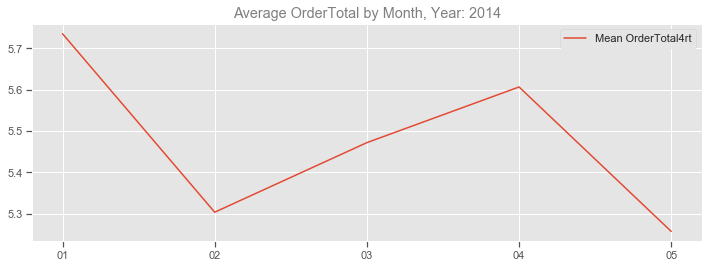

In [276]:
# Lets see the means by month grouped by year:
year_groups = tukey_df.groupby('OrderYear')
for group in year_groups:
    stats_ = group_hist(group[1], 'OrderMonth', 'OrderTotal4rt', show_hist=False)
    xs = list(stats_.index)
    ys = stats_.Mean
    plt.figure(figsize=(12,4))
    plt.plot(xs,ys,label='Mean OrderTotal4rt')
    plt.legend()
    plt.title('Average OrderTotal by Month, Year: {}'.format(group[0]), color='gray')
    plt.show()

In [277]:
# There's not really enough overlap between the three years to see if there are repetitive trends
# However, from the overall month groups it appears that there is a spike in May and October

In [278]:
# There is another feature RequiredDate that I am interested in looking at
tukey_df.RequiredDate.head()

0    2012-08-01
1    2012-08-16
2    2012-08-05
3    2012-08-05
4    2012-08-06
Name: RequiredDate, dtype: object

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Showing stats for OrderTotal4rt grouped by RequiredMonth


Mean    Median       Std  Size
01  5.552726  5.790424  1.496723    78
02  5.726230  5.587933  1.370952    65
03  5.373848  5.275507  1.403174    90
04  5.491311  5.401419  1.296550    99
05  5.510098  5.427595  1.526498    94
06  5.660157  5.685526  1.258084    38
07  5.469982  5.381078  1.212453    33
08  5.573848  5.711306  1.538042    53
09  5.526772  5.482695  1.253017    57
10  5.718392  5.782172  1.404196    63
11  5.660685  5.617781  1.511996    51
12  5.733210  5.813769  1.486579    64

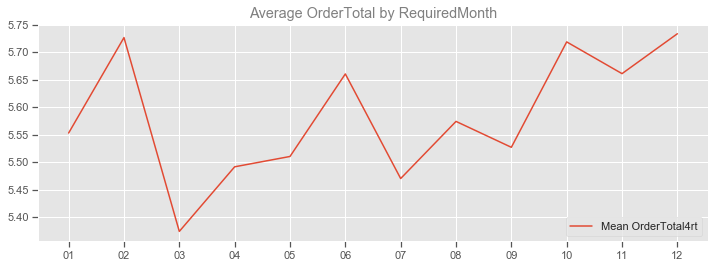

In [279]:
tukey_df['RequiredMonth'] = tukey_df.RequiredDate.map(lambda x: x.split('-')[1])
stats_ = group_hist(tukey_df, 'RequiredMonth', 'OrderTotal4rt', show_hist=False)
xs = list(stats.index)
ys = stats.Mean
plt.figure(figsize=(12,4))
plt.plot(xs,ys,label='Mean OrderTotal4rt')
plt.legend()
plt.title('Average OrderTotal by RequiredMonth', color='gray');

In [280]:
# This is probably more indicative of what demand the orders are intended to prepare for, and
# it seems to show that the customers need larger orders ready for summer, and for the holiday
# season from October through December, as well as a large spike around February

Showing stats for OrderTotal4rt grouped by EmployeeId


Mean    Median       Std  Size
1  5.736556  5.684972  1.373866   120
2  5.590434  5.581371  1.382712    90
3  5.515635  5.739064  1.366029   118
4  5.648806  5.653880  1.384642   150
5  5.717121  5.513194  1.368820    41
6  5.341581  5.287576  1.278757    64
7  5.494336  5.273133  1.592942    60
8  5.424758  5.342217  1.368187   100
9  5.580397  5.598403  1.773577    42

Text(0.5, 0, 'Employee Id')

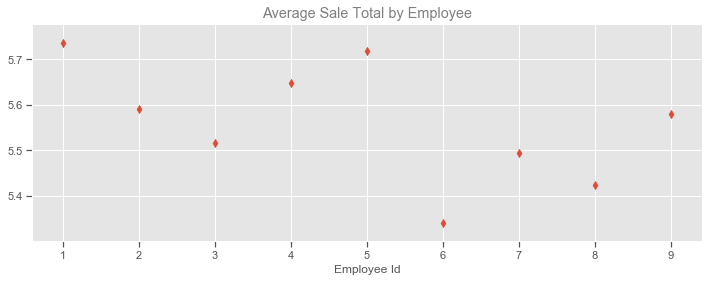

In [281]:
# I want to look at some employee-specific information
# Starting with mean OrderTotal4rt by employee
stats_ = group_hist(tukey_df, 'EmployeeId', 'OrderTotal4rt', show_hist=False)
xs = list(stats_.index)
ys = stats_.Mean
plt.figure(figsize=(12,4))
plt.scatter(xs,ys,marker='d')
plt.title('Average Sale Total by Employee', color='gray')
plt.xlabel('Employee Id')

In [282]:
# I want to see what kind of an impact an employee's hire date may have on their average sale
tukey_df.EmployeeHireDate.map(lambda x: x.split('-')[0]).unique()

array(['2025', '2024', '2026'], dtype=object)

In [283]:
# Interesting, it appears as though the employees in this company were hired in the future
# I can only assume that these were supposed to be in the 2000s, since even in the 2010s all of
# the orders would have happened before these employees were hired.
# I will make a new column for comparison, and another with normalization for a linreg
tukey_df['EmpHireYear'] = tukey_df.EmployeeHireDate.map(lambda x: int(x.split('-')[0]) - 20)
tukey_df['EmpHireYearNorm'] = tukey_df.EmpHireYear.map(lambda x: (x-2004)/2)
tukey_df.EmpHireYear.unique()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([2005, 2004, 2006], dtype=int64)

Showing stats for OrderTotal4rt grouped by EmpHireYear


Mean    Median       Std  Size
2004  5.616984  5.654580  1.372612   328
2005  5.582682  5.508302  1.358482   255
2006  5.477785  5.373279  1.520573   202

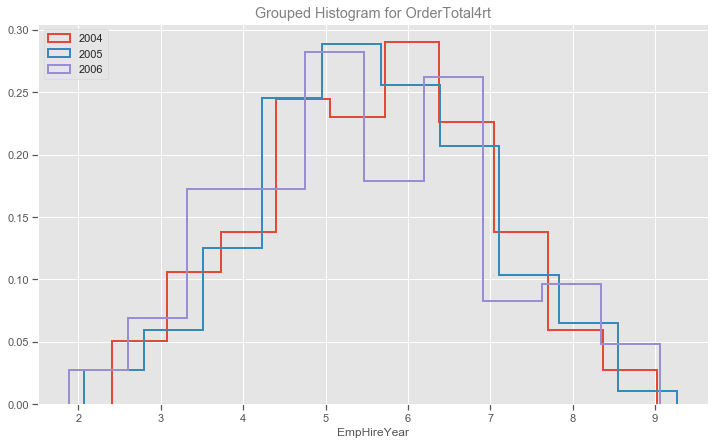

In [284]:
# A view of a histogram of average sales grouped by EmpHireYear
group_hist(tukey_df, 'EmpHireYear', 'OrderTotal4rt');

Linear Regression for OrderTotal4rt ~ EmpHireYearNorm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          OrderTotal4rt   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.148
Date:                Mon, 06 Apr 2020   Prob (F-statistic):              0.284
Time:                        03:08:05   Log-Likelihood:                -1380.8
No. Observations:                 785   AIC:                             2766.
Df Residuals:                     783   BIC:                             2775.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.6261      0.073     77.590      0.000       5.484       5.768
EmpHireYearNorm    -0.1335      0.125     -1.071      0.284      -0.378       0.111
==============================================================================
Omnibus:                        6.640   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                4.795
Skew:                           0.044   Prob(JB):                       0.0909
Kurtosis:                       2.628   Cond. No.                         2.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic    p_value
Goldfeld-Quandt     1.16655  0.0747404

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 0.095640 
 0.995915 
 
 
 p-value 
 0.000001 
 0.037495 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 0.482586 
 0.783

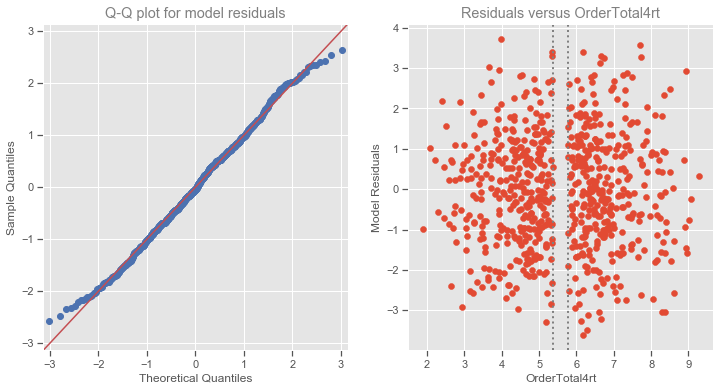

In [298]:
# From the limited data it seems there may be a slight negative linear relationship,
# indicating that employees hired longer ago get higher average sales.
# I will use the normalized year of hire to run a linear regression to see if this relationship
# can be established with significane level 0.05
do_a_linreg(tukey_df, 'EmpHireYearNorm', 'OrderTotal4rt')

In [299]:
# The linear regression does produce a negative coefficient, but not with significance
# Checking a pearson correlation test:
corr, pval = stats.pearsonr(tukey_df.EmpHireYearNorm, 
                            tukey_df.OrderTotal4rt)
print("Pearson r: {}\np-val: {}".format(corr,pval))

Pearson r: -0.03826361403895509
p-val: 0.28428274284530897


In [300]:
# Again, a similar non-significant p-value is shown for a slight negative correlation

Showing stats for OrderTotal grouped by EmployeeId


Mean     Median          Std  Size
1  1460.128662  1044.5800  1292.198336   120
2  1335.655056   970.4400  1192.420121    90
3  1270.814475  1085.8500  1146.030395   118
4  1394.797640  1021.8725  1285.941886   150
5  1453.204451   923.8750  1390.669905    41
6  1094.034250   782.0000   942.655473    64
7  1403.013042   773.4250  1506.058476    60
8  1199.642175   814.5000  1070.598190   100
9  1569.715869   982.4095  1721.404649    42

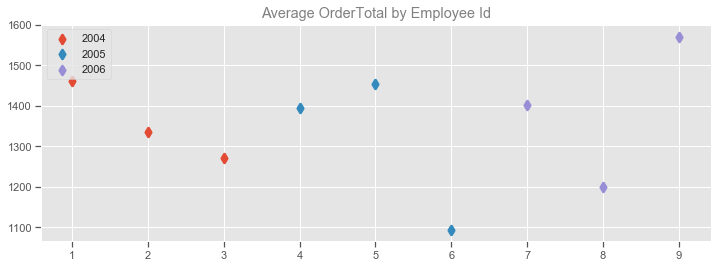

In [301]:
# Visualizing a different way to show year hired in color key:
groups = tukey_df.groupby('EmpHireYear')
fig, ax = plt.subplots(figsize=(12,4))
stats_ = group_hist(tukey_df, 'EmployeeId', 'OrderTotal', show_hist=False);

for name, group in groups:
    employees = group.groupby('EmployeeId').OrderTotal
    means = {}
    for Id, data in employees:
        means[Id] = data.mean()
    ax.scatter(means.keys(), means.values(), marker='d', linewidth=3, label=name)
        
plt.title('Average OrderTotal by Employee Id', color='gray')
ax.legend()
plt.show()

In [302]:
tukey_df.EmployeeSuper.unique()

array([ 2.,  5., nan])

Showing stats for OrderTotal4rt grouped by EmployeeSuper


Mean    Median       Std  Size
2.0  5.601947  5.561489  1.373410   529
5.0  5.457217  5.360035  1.524097   166

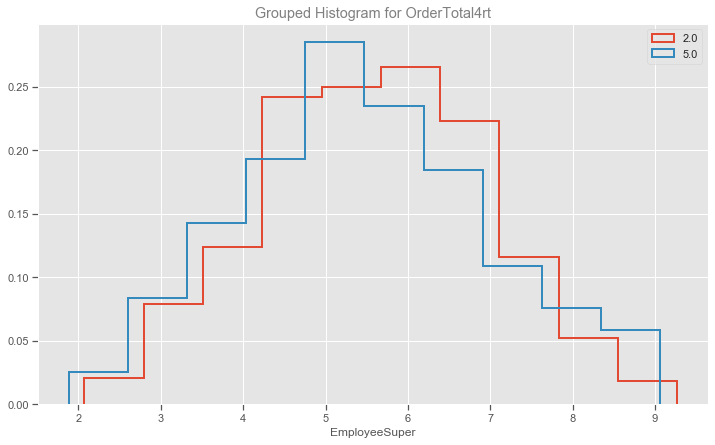

In [303]:
group_hist(tukey_df, 'EmployeeSuper', 'OrderTotal4rt');